# Integrating a Keras model into a Nengo network

Often we may want to define one part of our model in Nengo, and another part in TensorFlow.  For example, suppose we are building a biological reinforcement learning model, but we'd like the inputs to our model to be natural images rather than artificial vectors.  We could load a vision network from TensorFlow, insert it into our model using NengoDL, and then build the rest of our model using normal Nengo syntax.

NengoDL supports this through the [TensorNode](https://www.nengo.ai/nengo-dl/tensor_node.html) class.  This allows us to write code directly in TensorFlow, and then insert it easily into Nengo.  In this example we will demonstrate how to integrate a Keras network into a Nengo model in a series of stages. First, inserting an entire Keras model, second, inserting individual Keras layers, and third, using native Nengo objects.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nengo
import nengo_dl

# keras uses the global random seeds, so we set those here to
# ensure the example is reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

**Introduction to TensorNodes**

`nengo_dl.TensorNode` works very similarly to `nengo.Node`, except instead of using the node to insert Python code into our model we will use it to insert TensorFlow code.  

The first thing we need to do is define our TensorNode output.  This is a function that accepts the current simulation time (and, optionally, a batch of vectors) as input, and produces a batch of vectors as output.  All of these variables will be represented as `tf.Tensor` objects, and the internal operations of the TensorNode will be implemented with TensorFlow operations. For example, we could use a TensorNode to output a `sin` function:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

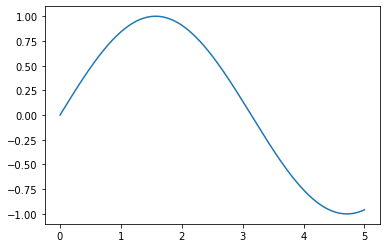

In [2]:
with nengo.Network() as net:
    def sin_func(t):
        # compute sin wave (based on simulation time)
        output = tf.sin(t)
        
        # convert output to the expected batched vector shape
        # (with batch size of 1 and vector dimensionality 1)
        output = tf.reshape(output, (1, 1))
        
        return output
    
    node = nengo_dl.TensorNode(sin_func)
    p = nengo.Probe(node)

with nengo_dl.Simulator(net) as sim:
    sim.run(5.0)
    
plt.figure()
plt.plot(sim.trange(), sim.data[p]);

However, outputting a `sin` function is something we could do more easily with a regular `nengo.Node`.  The main use case for `nengo_dl.TensorNode` is to allow us to write more complex TensorFlow code and insert it into a NengoDL model. For example, one thing we often want to do is take a deep network written in TensorFlow/Keras, and add it into a Nengo model, which is what we will focus on in this notebook.

## Inserting a whole Keras model

[Keras](https://www.tensorflow.org/guide/keras) is a popular software package for building and training deep learning style networks.  It is a higher-level API within TensorFlow to make it easier to construct and train deep networks.  And because it is all implemented as a TensorFlow network under the hood, we can define a network using Keras and then insert it into NengoDL using a TensorNode.

This example assumes familiarity with the Keras API. Specifically it is based on the [introduction in the Tensorflow documentation](https://www.tensorflow.org/tutorials/keras/classification), so if you are not yet familiar with Keras, you may find it helpful to read those tutorials first.

In this example we'll train a neural network to classify the fashion MNIST dataset.  This dataset contains images of clothing, and the goal of the network is to identify what type of clothing it is (e.g. t-shirt, trouser, coat, etc.).

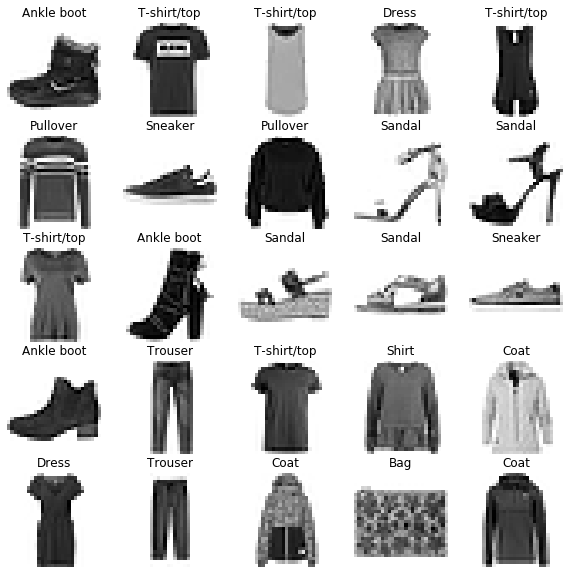

In [3]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.fashion_mnist.load_data())

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

Next we build and train a simple neural network, using Keras.  In this case we're building a simple two layer, densely connected network.

Note that alternatively we could define the network in Keras and then train it in NengoDL (using the `Simulator.fit` function).  But for now we'll show how to do everything in Keras.

In [4]:
inp = tf.keras.Input(train_images.shape[1:])
hidden = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(inp)
out = tf.keras.layers.Dense(units=num_classes)(hidden)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(optimizer=tf.optimizers.Adam(), 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5)

print("Test accuracy:", model.evaluate(test_images, test_labels, verbose=0)[1])

Train on 60000 samples
Epoch 1/5


   32/60000 [..............................] - ETA: 11:49 - loss: 2.4660 - accuracy: 0.1250

  928/60000 [..............................] - ETA: 27s - loss: 1.3921 - accuracy: 0.5420  

 1728/60000 [..............................] - ETA: 16s - loss: 1.1428 - accuracy: 0.6227

 2592/60000 [>.............................] - ETA: 11s - loss: 1.0279 - accuracy: 0.6578

 3392/60000 [>.............................] - ETA: 9s - loss: 0.9423 - accuracy: 0.6846 

 4288/60000 [=>............................] - ETA: 8s - loss: 0.8928 - accuracy: 0.7006

 4992/60000 [=>............................] - ETA: 7s - loss: 0.8575 - accuracy: 0.7137

 5760/60000 [=>............................] - ETA: 6s - loss: 0.8315 - accuracy: 0.7194

 6528/60000 [==>...........................] - ETA: 6s - loss: 0.8091 - accuracy: 0.7244

 7456/60000 [==>...........................] - ETA: 5s - loss: 0.7815 - accuracy: 0.7302

 8320/60000 [===>..........................] - ETA: 5s - loss: 0.7537 - accuracy: 0.7395

 9184/60000 [===>..........................] - ETA: 5s - loss: 0.7315 - accuracy: 0.7485

10016/60000 [====>.........................] - ETA: 4s - loss: 0.7162 - accuracy: 0.7550

10784/60000 [====>.........................] - ETA: 4s - loss: 0.7014 - accuracy: 0.7593

11616/60000 [====>.........................] - ETA: 4s - loss: 0.6946 - accuracy: 0.7625

12416/60000 [=====>........................] - ETA: 4s - loss: 0.6849 - accuracy: 0.7651

13248/60000 [=====>........................] - ETA: 4s - loss: 0.6703 - accuracy: 0.7702

14176/60000 [======>.......................] - ETA: 4s - loss: 0.6605 - accuracy: 0.7731

15072/60000 [======>.......................] - ETA: 3s - loss: 0.6516 - accuracy: 0.7760

16128/60000 [=======>......................] - ETA: 3s - loss: 0.6405 - accuracy: 0.7797

16960/60000 [=======>......................] - ETA: 3s - loss: 0.6335 - accuracy: 0.7822

17728/60000 [=======>......................] - ETA: 3s - loss: 0.6282 - accuracy: 0.7834

18528/60000 [========>.....................] - ETA: 3s - loss: 0.6225 - accuracy: 0.7850

19328/60000 [========>.....................] - ETA: 3s - loss: 0.6190 - accuracy: 0.7865

20096/60000 [=========>....................] - ETA: 3s - loss: 0.6153 - accuracy: 0.7879

20928/60000 [=========>....................] - ETA: 3s - loss: 0.6095 - accuracy: 0.7899

21824/60000 [=========>....................] - ETA: 2s - loss: 0.6016 - accuracy: 0.7930

22656/60000 [==========>...................] - ETA: 2s - loss: 0.5975 - accuracy: 0.7946

23424/60000 [==========>...................] - ETA: 2s - loss: 0.5930 - accuracy: 0.7963

24224/60000 [===========>..................] - ETA: 2s - loss: 0.5907 - accuracy: 0.7968

24928/60000 [===========>..................] - ETA: 2s - loss: 0.5891 - accuracy: 0.7973

25760/60000 [===========>..................] - ETA: 2s - loss: 0.5853 - accuracy: 0.7984

26592/60000 [============>.................] - ETA: 2s - loss: 0.5809 - accuracy: 0.8003

27296/60000 [============>.................] - ETA: 2s - loss: 0.5771 - accuracy: 0.8013

28064/60000 [=============>................] - ETA: 2s - loss: 0.5747 - accuracy: 0.8025

28736/60000 [=============>................] - ETA: 2s - loss: 0.5721 - accuracy: 0.8033

29344/60000 [=============>................] - ETA: 2s - loss: 0.5701 - accuracy: 0.8041

30016/60000 [==============>...............] - ETA: 2s - loss: 0.5669 - accuracy: 0.8048

30720/60000 [==============>...............] - ETA: 2s - loss: 0.5654 - accuracy: 0.8051

31328/60000 [==============>...............] - ETA: 2s - loss: 0.5633 - accuracy: 0.8056

31936/60000 [==============>...............] - ETA: 2s - loss: 0.5614 - accuracy: 0.8063

32672/60000 [===============>..............] - ETA: 2s - loss: 0.5585 - accuracy: 0.8073

33376/60000 [===============>..............] - ETA: 2s - loss: 0.5558 - accuracy: 0.8082

34080/60000 [================>.............] - ETA: 1s - loss: 0.5533 - accuracy: 0.8090

34752/60000 [================>.............] - ETA: 1s - loss: 0.5500 - accuracy: 0.8097

35456/60000 [================>.............] - ETA: 1s - loss: 0.5480 - accuracy: 0.8102

36128/60000 [=================>............] - ETA: 1s - loss: 0.5469 - accuracy: 0.8103

36768/60000 [=================>............] - ETA: 1s - loss: 0.5446 - accuracy: 0.8111

37408/60000 [=================>............] - ETA: 1s - loss: 0.5430 - accuracy: 0.8117

38048/60000 [==================>...........] - ETA: 1s - loss: 0.5411 - accuracy: 0.8123

38624/60000 [==================>...........] - ETA: 1s - loss: 0.5384 - accuracy: 0.8133

39328/60000 [==================>...........] - ETA: 1s - loss: 0.5369 - accuracy: 0.8138

40032/60000 [===================>..........] - ETA: 1s - loss: 0.5345 - accuracy: 0.8145

40736/60000 [===================>..........] - ETA: 1s - loss: 0.5332 - accuracy: 0.8149

41376/60000 [===================>..........] - ETA: 1s - loss: 0.5322 - accuracy: 0.8156

42080/60000 [====================>.........] - ETA: 1s - loss: 0.5301 - accuracy: 0.8164

42784/60000 [====================>.........] - ETA: 1s - loss: 0.5287 - accuracy: 0.8167

43456/60000 [====================>.........] - ETA: 1s - loss: 0.5269 - accuracy: 0.8171

44192/60000 [=====================>........] - ETA: 1s - loss: 0.5254 - accuracy: 0.8177

44864/60000 [=====================>........] - ETA: 1s - loss: 0.5233 - accuracy: 0.8184

45504/60000 [=====================>........] - ETA: 1s - loss: 0.5219 - accuracy: 0.8189

46208/60000 [======================>.......] - ETA: 1s - loss: 0.5211 - accuracy: 0.8192

46944/60000 [======================>.......] - ETA: 0s - loss: 0.5196 - accuracy: 0.8195

47616/60000 [======================>.......] - ETA: 0s - loss: 0.5180 - accuracy: 0.8199

48288/60000 [=======================>......] - ETA: 0s - loss: 0.5167 - accuracy: 0.8201

48960/60000 [=======================>......] - ETA: 0s - loss: 0.5159 - accuracy: 0.8204

49632/60000 [=======================>......] - ETA: 0s - loss: 0.5151 - accuracy: 0.8208

50304/60000 [========================>.....] - ETA: 0s - loss: 0.5135 - accuracy: 0.8213

50944/60000 [========================>.....] - ETA: 0s - loss: 0.5128 - accuracy: 0.8216

51616/60000 [========================>.....] - ETA: 0s - loss: 0.5118 - accuracy: 0.8220

52320/60000 [=========================>....] - ETA: 0s - loss: 0.5102 - accuracy: 0.8223

53024/60000 [=========================>....] - ETA: 0s - loss: 0.5083 - accuracy: 0.8230

53760/60000 [=========================>....] - ETA: 0s - loss: 0.5069 - accuracy: 0.8235

54432/60000 [==========================>...] - ETA: 0s - loss: 0.5056 - accuracy: 0.8240

55072/60000 [==========================>...] - ETA: 0s - loss: 0.5042 - accuracy: 0.8243

55744/60000 [==========================>...] - ETA: 0s - loss: 0.5028 - accuracy: 0.8249

56384/60000 [===========================>..] - ETA: 0s - loss: 0.5026 - accuracy: 0.8251

56960/60000 [===========================>..] - ETA: 0s - loss: 0.5013 - accuracy: 0.8255

57632/60000 [===========================>..] - ETA: 0s - loss: 0.5001 - accuracy: 0.8259

58304/60000 [============================>.] - ETA: 0s - loss: 0.4985 - accuracy: 0.8264

59008/60000 [============================>.] - ETA: 0s - loss: 0.4974 - accuracy: 0.8267

59712/60000 [============================>.] - ETA: 0s - loss: 0.4962 - accuracy: 0.8269

60000/60000 [==============================] - 5s 76us/sample - loss: 0.4954 - accuracy: 0.8272


Epoch 2/5
   32/60000 [..............................] - ETA: 7s - loss: 0.2882 - accuracy: 0.8750

  640/60000 [..............................] - ETA: 5s - loss: 0.3642 - accuracy: 0.8703

 1280/60000 [..............................] - ETA: 4s - loss: 0.3856 - accuracy: 0.8609

 1984/60000 [..............................] - ETA: 4s - loss: 0.3960 - accuracy: 0.8604

 2688/60000 [>.............................] - ETA: 4s - loss: 0.4043 - accuracy: 0.8575

 3456/60000 [>.............................] - ETA: 4s - loss: 0.3951 - accuracy: 0.8614

 4160/60000 [=>............................] - ETA: 4s - loss: 0.3980 - accuracy: 0.8596

 4832/60000 [=>............................] - ETA: 4s - loss: 0.4047 - accuracy: 0.8564

 5536/60000 [=>............................] - ETA: 4s - loss: 0.4027 - accuracy: 0.8566

 6208/60000 [==>...........................] - ETA: 3s - loss: 0.3968 - accuracy: 0.8581

 6784/60000 [==>...........................] - ETA: 4s - loss: 0.3987 - accuracy: 0.8580

 7456/60000 [==>...........................] - ETA: 3s - loss: 0.3950 - accuracy: 0.8582

 8128/60000 [===>..........................] - ETA: 3s - loss: 0.3949 - accuracy: 0.8581

 8800/60000 [===>..........................] - ETA: 3s - loss: 0.3954 - accuracy: 0.8578

 9504/60000 [===>..........................] - ETA: 3s - loss: 0.3984 - accuracy: 0.8556

10240/60000 [====>.........................] - ETA: 3s - loss: 0.3986 - accuracy: 0.8559

10912/60000 [====>.........................] - ETA: 3s - loss: 0.4001 - accuracy: 0.8555

11584/60000 [====>.........................] - ETA: 3s - loss: 0.3990 - accuracy: 0.8557

12288/60000 [=====>........................] - ETA: 3s - loss: 0.3984 - accuracy: 0.8559

12960/60000 [=====>........................] - ETA: 3s - loss: 0.3976 - accuracy: 0.8567

13600/60000 [=====>........................] - ETA: 3s - loss: 0.3976 - accuracy: 0.8572

14240/60000 [======>.......................] - ETA: 3s - loss: 0.3979 - accuracy: 0.8572

14944/60000 [======>.......................] - ETA: 3s - loss: 0.3969 - accuracy: 0.8579

15616/60000 [======>.......................] - ETA: 3s - loss: 0.3933 - accuracy: 0.8587

16288/60000 [=======>......................] - ETA: 3s - loss: 0.3955 - accuracy: 0.8579

16896/60000 [=======>......................] - ETA: 3s - loss: 0.3950 - accuracy: 0.8580

17536/60000 [=======>......................] - ETA: 3s - loss: 0.3937 - accuracy: 0.8587

18176/60000 [========>.....................] - ETA: 3s - loss: 0.3919 - accuracy: 0.8596

18816/60000 [========>.....................] - ETA: 3s - loss: 0.3900 - accuracy: 0.8602

19520/60000 [========>.....................] - ETA: 3s - loss: 0.3905 - accuracy: 0.8596

20160/60000 [=========>....................] - ETA: 3s - loss: 0.3910 - accuracy: 0.8591

20832/60000 [=========>....................] - ETA: 2s - loss: 0.3910 - accuracy: 0.8593

21536/60000 [=========>....................] - ETA: 2s - loss: 0.3908 - accuracy: 0.8592

22176/60000 [==========>...................] - ETA: 2s - loss: 0.3900 - accuracy: 0.8594

22784/60000 [==========>...................] - ETA: 2s - loss: 0.3901 - accuracy: 0.8597

23424/60000 [==========>...................] - ETA: 2s - loss: 0.3901 - accuracy: 0.8595

24096/60000 [===========>..................] - ETA: 2s - loss: 0.3898 - accuracy: 0.8591

24832/60000 [===========>..................] - ETA: 2s - loss: 0.3896 - accuracy: 0.8592

25472/60000 [===========>..................] - ETA: 2s - loss: 0.3902 - accuracy: 0.8589

26176/60000 [============>.................] - ETA: 2s - loss: 0.3897 - accuracy: 0.8589

26880/60000 [============>.................] - ETA: 2s - loss: 0.3887 - accuracy: 0.8594

27616/60000 [============>.................] - ETA: 2s - loss: 0.3885 - accuracy: 0.8596

28352/60000 [=============>................] - ETA: 2s - loss: 0.3868 - accuracy: 0.8602

28992/60000 [=============>................] - ETA: 2s - loss: 0.3860 - accuracy: 0.8606

29632/60000 [=============>................] - ETA: 2s - loss: 0.3850 - accuracy: 0.8607

30368/60000 [==============>...............] - ETA: 2s - loss: 0.3839 - accuracy: 0.8610

31072/60000 [==============>...............] - ETA: 2s - loss: 0.3829 - accuracy: 0.8615

31744/60000 [==============>...............] - ETA: 2s - loss: 0.3821 - accuracy: 0.8618

32416/60000 [===============>..............] - ETA: 2s - loss: 0.3818 - accuracy: 0.8620

33088/60000 [===============>..............] - ETA: 2s - loss: 0.3816 - accuracy: 0.8618

33760/60000 [===============>..............] - ETA: 1s - loss: 0.3822 - accuracy: 0.8614

34400/60000 [================>.............] - ETA: 1s - loss: 0.3823 - accuracy: 0.8614

35040/60000 [================>.............] - ETA: 1s - loss: 0.3830 - accuracy: 0.8613

35680/60000 [================>.............] - ETA: 1s - loss: 0.3828 - accuracy: 0.8614

36384/60000 [=================>............] - ETA: 1s - loss: 0.3824 - accuracy: 0.8618

36992/60000 [=================>............] - ETA: 1s - loss: 0.3815 - accuracy: 0.8622

37696/60000 [=================>............] - ETA: 1s - loss: 0.3806 - accuracy: 0.8626

38432/60000 [==================>...........] - ETA: 1s - loss: 0.3802 - accuracy: 0.8627

39136/60000 [==================>...........] - ETA: 1s - loss: 0.3796 - accuracy: 0.8628

39808/60000 [==================>...........] - ETA: 1s - loss: 0.3795 - accuracy: 0.8629

40544/60000 [===================>..........] - ETA: 1s - loss: 0.3794 - accuracy: 0.8630

41248/60000 [===================>..........] - ETA: 1s - loss: 0.3794 - accuracy: 0.8631

41920/60000 [===================>..........] - ETA: 1s - loss: 0.3805 - accuracy: 0.8626

42592/60000 [====================>.........] - ETA: 1s - loss: 0.3804 - accuracy: 0.8624

43264/60000 [====================>.........] - ETA: 1s - loss: 0.3809 - accuracy: 0.8623

43936/60000 [====================>.........] - ETA: 1s - loss: 0.3809 - accuracy: 0.8622

44608/60000 [=====================>........] - ETA: 1s - loss: 0.3802 - accuracy: 0.8623

45280/60000 [=====================>........] - ETA: 1s - loss: 0.3800 - accuracy: 0.8622

45888/60000 [=====================>........] - ETA: 1s - loss: 0.3790 - accuracy: 0.8627

46624/60000 [======================>.......] - ETA: 1s - loss: 0.3782 - accuracy: 0.8628

47328/60000 [======================>.......] - ETA: 0s - loss: 0.3777 - accuracy: 0.8630

48000/60000 [=======================>......] - ETA: 0s - loss: 0.3773 - accuracy: 0.8631

48672/60000 [=======================>......] - ETA: 0s - loss: 0.3770 - accuracy: 0.8633

49440/60000 [=======================>......] - ETA: 0s - loss: 0.3768 - accuracy: 0.8634

50080/60000 [========================>.....] - ETA: 0s - loss: 0.3765 - accuracy: 0.8636

50752/60000 [========================>.....] - ETA: 0s - loss: 0.3754 - accuracy: 0.8640

51424/60000 [========================>.....] - ETA: 0s - loss: 0.3751 - accuracy: 0.8642

52064/60000 [=========================>....] - ETA: 0s - loss: 0.3739 - accuracy: 0.8646

52672/60000 [=========================>....] - ETA: 0s - loss: 0.3743 - accuracy: 0.8645

53344/60000 [=========================>....] - ETA: 0s - loss: 0.3739 - accuracy: 0.8646

53984/60000 [=========================>....] - ETA: 0s - loss: 0.3734 - accuracy: 0.8647

54624/60000 [==========================>...] - ETA: 0s - loss: 0.3726 - accuracy: 0.8649

55232/60000 [==========================>...] - ETA: 0s - loss: 0.3729 - accuracy: 0.8650

55904/60000 [==========================>...] - ETA: 0s - loss: 0.3734 - accuracy: 0.8650

56672/60000 [===========================>..] - ETA: 0s - loss: 0.3728 - accuracy: 0.8652

57280/60000 [===========================>..] - ETA: 0s - loss: 0.3725 - accuracy: 0.8652

57952/60000 [===========================>..] - ETA: 0s - loss: 0.3724 - accuracy: 0.8652

58752/60000 [============================>.] - ETA: 0s - loss: 0.3723 - accuracy: 0.8653

59552/60000 [============================>.] - ETA: 0s - loss: 0.3718 - accuracy: 0.8653

60000/60000 [==============================] - 5s 76us/sample - loss: 0.3718 - accuracy: 0.8653


Epoch 3/5
   32/60000 [..............................] - ETA: 6s - loss: 0.3796 - accuracy: 0.8438

  800/60000 [..............................] - ETA: 4s - loss: 0.3580 - accuracy: 0.8737

 1472/60000 [..............................] - ETA: 4s - loss: 0.3357 - accuracy: 0.8798

 2208/60000 [>.............................] - ETA: 4s - loss: 0.3313 - accuracy: 0.8804

 2880/60000 [>.............................] - ETA: 4s - loss: 0.3420 - accuracy: 0.8778

 3616/60000 [>.............................] - ETA: 4s - loss: 0.3495 - accuracy: 0.8767

 4256/60000 [=>............................] - ETA: 4s - loss: 0.3466 - accuracy: 0.8773

 4864/60000 [=>............................] - ETA: 4s - loss: 0.3426 - accuracy: 0.8789

 5472/60000 [=>............................] - ETA: 4s - loss: 0.3453 - accuracy: 0.8783

 6080/60000 [==>...........................] - ETA: 4s - loss: 0.3423 - accuracy: 0.8791

 6688/60000 [==>...........................] - ETA: 4s - loss: 0.3409 - accuracy: 0.8798

 7360/60000 [==>...........................] - ETA: 4s - loss: 0.3404 - accuracy: 0.8787

 8032/60000 [===>..........................] - ETA: 4s - loss: 0.3429 - accuracy: 0.8784

 8704/60000 [===>..........................] - ETA: 3s - loss: 0.3454 - accuracy: 0.8776

 9344/60000 [===>..........................] - ETA: 3s - loss: 0.3401 - accuracy: 0.8790

10048/60000 [====>.........................] - ETA: 3s - loss: 0.3372 - accuracy: 0.8802

10720/60000 [====>.........................] - ETA: 3s - loss: 0.3372 - accuracy: 0.8801

11328/60000 [====>.........................] - ETA: 3s - loss: 0.3355 - accuracy: 0.8806

12000/60000 [=====>........................] - ETA: 3s - loss: 0.3373 - accuracy: 0.8800

12640/60000 [=====>........................] - ETA: 3s - loss: 0.3375 - accuracy: 0.8797

13344/60000 [=====>........................] - ETA: 3s - loss: 0.3342 - accuracy: 0.8811

14016/60000 [======>.......................] - ETA: 3s - loss: 0.3347 - accuracy: 0.8806

14752/60000 [======>.......................] - ETA: 3s - loss: 0.3341 - accuracy: 0.8804

15328/60000 [======>.......................] - ETA: 3s - loss: 0.3336 - accuracy: 0.8802

16032/60000 [=======>......................] - ETA: 3s - loss: 0.3343 - accuracy: 0.8796

16704/60000 [=======>......................] - ETA: 3s - loss: 0.3349 - accuracy: 0.8795

17376/60000 [=======>......................] - ETA: 3s - loss: 0.3333 - accuracy: 0.8798

18080/60000 [========>.....................] - ETA: 3s - loss: 0.3334 - accuracy: 0.8800

18720/60000 [========>.....................] - ETA: 3s - loss: 0.3346 - accuracy: 0.8794

19456/60000 [========>.....................] - ETA: 3s - loss: 0.3363 - accuracy: 0.8784

20096/60000 [=========>....................] - ETA: 3s - loss: 0.3388 - accuracy: 0.8773

20704/60000 [=========>....................] - ETA: 3s - loss: 0.3378 - accuracy: 0.8776

21376/60000 [=========>....................] - ETA: 2s - loss: 0.3365 - accuracy: 0.8783

22048/60000 [==========>...................] - ETA: 2s - loss: 0.3357 - accuracy: 0.8785

22784/60000 [==========>...................] - ETA: 2s - loss: 0.3353 - accuracy: 0.8786

23552/60000 [==========>...................] - ETA: 2s - loss: 0.3348 - accuracy: 0.8784

24256/60000 [===========>..................] - ETA: 2s - loss: 0.3354 - accuracy: 0.8781

24992/60000 [===========>..................] - ETA: 2s - loss: 0.3352 - accuracy: 0.8782

25664/60000 [===========>..................] - ETA: 2s - loss: 0.3345 - accuracy: 0.8787

26368/60000 [============>.................] - ETA: 2s - loss: 0.3345 - accuracy: 0.8788

27040/60000 [============>.................] - ETA: 2s - loss: 0.3334 - accuracy: 0.8790

27712/60000 [============>.................] - ETA: 2s - loss: 0.3354 - accuracy: 0.8787

28448/60000 [=============>................] - ETA: 2s - loss: 0.3341 - accuracy: 0.8793

29152/60000 [=============>................] - ETA: 2s - loss: 0.3344 - accuracy: 0.8794

29824/60000 [=============>................] - ETA: 2s - loss: 0.3347 - accuracy: 0.8790

30528/60000 [==============>...............] - ETA: 2s - loss: 0.3346 - accuracy: 0.8791

31168/60000 [==============>...............] - ETA: 2s - loss: 0.3343 - accuracy: 0.8792

31904/60000 [==============>...............] - ETA: 2s - loss: 0.3341 - accuracy: 0.8791

32608/60000 [===============>..............] - ETA: 2s - loss: 0.3333 - accuracy: 0.8796

33312/60000 [===============>..............] - ETA: 2s - loss: 0.3323 - accuracy: 0.8800

34048/60000 [================>.............] - ETA: 1s - loss: 0.3320 - accuracy: 0.8801

34720/60000 [================>.............] - ETA: 1s - loss: 0.3324 - accuracy: 0.8799

35424/60000 [================>.............] - ETA: 1s - loss: 0.3322 - accuracy: 0.8801

36064/60000 [=================>............] - ETA: 1s - loss: 0.3318 - accuracy: 0.8804

36736/60000 [=================>............] - ETA: 1s - loss: 0.3311 - accuracy: 0.8807

37408/60000 [=================>............] - ETA: 1s - loss: 0.3307 - accuracy: 0.8809

38048/60000 [==================>...........] - ETA: 1s - loss: 0.3304 - accuracy: 0.8810

38720/60000 [==================>...........] - ETA: 1s - loss: 0.3306 - accuracy: 0.8807

39424/60000 [==================>...........] - ETA: 1s - loss: 0.3318 - accuracy: 0.8803

40128/60000 [===================>..........] - ETA: 1s - loss: 0.3319 - accuracy: 0.8803

40736/60000 [===================>..........] - ETA: 1s - loss: 0.3324 - accuracy: 0.8800

41472/60000 [===================>..........] - ETA: 1s - loss: 0.3325 - accuracy: 0.8799

42112/60000 [====================>.........] - ETA: 1s - loss: 0.3326 - accuracy: 0.8799

42752/60000 [====================>.........] - ETA: 1s - loss: 0.3327 - accuracy: 0.8801

43488/60000 [====================>.........] - ETA: 1s - loss: 0.3323 - accuracy: 0.8801

44096/60000 [=====================>........] - ETA: 1s - loss: 0.3322 - accuracy: 0.8803

44832/60000 [=====================>........] - ETA: 1s - loss: 0.3321 - accuracy: 0.8802

45504/60000 [=====================>........] - ETA: 1s - loss: 0.3330 - accuracy: 0.8799

46144/60000 [======================>.......] - ETA: 1s - loss: 0.3329 - accuracy: 0.8800

46816/60000 [======================>.......] - ETA: 0s - loss: 0.3334 - accuracy: 0.8798

47520/60000 [======================>.......] - ETA: 0s - loss: 0.3333 - accuracy: 0.8799

48224/60000 [=======================>......] - ETA: 0s - loss: 0.3332 - accuracy: 0.8800

48928/60000 [=======================>......] - ETA: 0s - loss: 0.3336 - accuracy: 0.8798

49632/60000 [=======================>......] - ETA: 0s - loss: 0.3342 - accuracy: 0.8796

50272/60000 [========================>.....] - ETA: 0s - loss: 0.3347 - accuracy: 0.8795

51040/60000 [========================>.....] - ETA: 0s - loss: 0.3342 - accuracy: 0.8794

51744/60000 [========================>.....] - ETA: 0s - loss: 0.3339 - accuracy: 0.8795

52384/60000 [=========================>....] - ETA: 0s - loss: 0.3338 - accuracy: 0.8796

53088/60000 [=========================>....] - ETA: 0s - loss: 0.3345 - accuracy: 0.8792

53792/60000 [=========================>....] - ETA: 0s - loss: 0.3344 - accuracy: 0.8793

54464/60000 [==========================>...] - ETA: 0s - loss: 0.3345 - accuracy: 0.8791

55200/60000 [==========================>...] - ETA: 0s - loss: 0.3343 - accuracy: 0.8791

55872/60000 [==========================>...] - ETA: 0s - loss: 0.3340 - accuracy: 0.8792

56512/60000 [===========================>..] - ETA: 0s - loss: 0.3345 - accuracy: 0.8791

57216/60000 [===========================>..] - ETA: 0s - loss: 0.3340 - accuracy: 0.8793

57888/60000 [===========================>..] - ETA: 0s - loss: 0.3338 - accuracy: 0.8793

58592/60000 [============================>.] - ETA: 0s - loss: 0.3329 - accuracy: 0.8797

59296/60000 [============================>.] - ETA: 0s - loss: 0.3331 - accuracy: 0.8796

60000/60000 [==============================] - 5s 75us/sample - loss: 0.3336 - accuracy: 0.8794


Epoch 4/5
   32/60000 [..............................] - ETA: 5s - loss: 0.3291 - accuracy: 0.8438

  704/60000 [..............................] - ETA: 4s - loss: 0.2704 - accuracy: 0.9020

 1408/60000 [..............................] - ETA: 4s - loss: 0.2864 - accuracy: 0.8956

 2048/60000 [>.............................] - ETA: 4s - loss: 0.2963 - accuracy: 0.8936

 2720/60000 [>.............................] - ETA: 4s - loss: 0.3073 - accuracy: 0.8901

 3360/60000 [>.............................] - ETA: 4s - loss: 0.3058 - accuracy: 0.8893

 4096/60000 [=>............................] - ETA: 4s - loss: 0.3121 - accuracy: 0.8855

 4768/60000 [=>............................] - ETA: 4s - loss: 0.3173 - accuracy: 0.8844

 5440/60000 [=>............................] - ETA: 4s - loss: 0.3205 - accuracy: 0.8846

 6144/60000 [==>...........................] - ETA: 4s - loss: 0.3174 - accuracy: 0.8849

 6816/60000 [==>...........................] - ETA: 4s - loss: 0.3153 - accuracy: 0.8864

 7616/60000 [==>...........................] - ETA: 3s - loss: 0.3130 - accuracy: 0.8876

 8288/60000 [===>..........................] - ETA: 3s - loss: 0.3152 - accuracy: 0.8872

 8960/60000 [===>..........................] - ETA: 3s - loss: 0.3122 - accuracy: 0.8884

 9632/60000 [===>..........................] - ETA: 3s - loss: 0.3114 - accuracy: 0.8883

10304/60000 [====>.........................] - ETA: 3s - loss: 0.3096 - accuracy: 0.8891

10912/60000 [====>.........................] - ETA: 3s - loss: 0.3064 - accuracy: 0.8904

11584/60000 [====>.........................] - ETA: 3s - loss: 0.3070 - accuracy: 0.8898

12256/60000 [=====>........................] - ETA: 3s - loss: 0.3049 - accuracy: 0.8898

12960/60000 [=====>........................] - ETA: 3s - loss: 0.3067 - accuracy: 0.8894

13696/60000 [=====>........................] - ETA: 3s - loss: 0.3062 - accuracy: 0.8896

14400/60000 [======>.......................] - ETA: 3s - loss: 0.3067 - accuracy: 0.8897

15072/60000 [======>.......................] - ETA: 3s - loss: 0.3048 - accuracy: 0.8905

15680/60000 [======>.......................] - ETA: 3s - loss: 0.3058 - accuracy: 0.8904

16352/60000 [=======>......................] - ETA: 3s - loss: 0.3058 - accuracy: 0.8906

17120/60000 [=======>......................] - ETA: 3s - loss: 0.3053 - accuracy: 0.8907

17792/60000 [=======>......................] - ETA: 3s - loss: 0.3062 - accuracy: 0.8902

18496/60000 [========>.....................] - ETA: 3s - loss: 0.3067 - accuracy: 0.8902

19264/60000 [========>.....................] - ETA: 3s - loss: 0.3076 - accuracy: 0.8894

19968/60000 [========>.....................] - ETA: 2s - loss: 0.3067 - accuracy: 0.8898

20576/60000 [=========>....................] - ETA: 2s - loss: 0.3061 - accuracy: 0.8900

21280/60000 [=========>....................] - ETA: 2s - loss: 0.3055 - accuracy: 0.8903

21984/60000 [=========>....................] - ETA: 2s - loss: 0.3047 - accuracy: 0.8903

22624/60000 [==========>...................] - ETA: 2s - loss: 0.3036 - accuracy: 0.8907

23328/60000 [==========>...................] - ETA: 2s - loss: 0.3044 - accuracy: 0.8905

24032/60000 [===========>..................] - ETA: 2s - loss: 0.3050 - accuracy: 0.8899

24704/60000 [===========>..................] - ETA: 2s - loss: 0.3056 - accuracy: 0.8896

25376/60000 [===========>..................] - ETA: 2s - loss: 0.3061 - accuracy: 0.8891

26080/60000 [============>.................] - ETA: 2s - loss: 0.3056 - accuracy: 0.8898

26752/60000 [============>.................] - ETA: 2s - loss: 0.3056 - accuracy: 0.8896

27392/60000 [============>.................] - ETA: 2s - loss: 0.3057 - accuracy: 0.8893

28096/60000 [=============>................] - ETA: 2s - loss: 0.3064 - accuracy: 0.8889

28736/60000 [=============>................] - ETA: 2s - loss: 0.3049 - accuracy: 0.8896

29472/60000 [=============>................] - ETA: 2s - loss: 0.3063 - accuracy: 0.8889

30080/60000 [==============>...............] - ETA: 2s - loss: 0.3056 - accuracy: 0.8892

30720/60000 [==============>...............] - ETA: 2s - loss: 0.3052 - accuracy: 0.8895

31392/60000 [==============>...............] - ETA: 2s - loss: 0.3056 - accuracy: 0.8891

32096/60000 [===============>..............] - ETA: 2s - loss: 0.3051 - accuracy: 0.8893

32768/60000 [===============>..............] - ETA: 2s - loss: 0.3057 - accuracy: 0.8892

33408/60000 [===============>..............] - ETA: 1s - loss: 0.3066 - accuracy: 0.8890

34080/60000 [================>.............] - ETA: 1s - loss: 0.3070 - accuracy: 0.8888

34784/60000 [================>.............] - ETA: 1s - loss: 0.3069 - accuracy: 0.8886

35520/60000 [================>.............] - ETA: 1s - loss: 0.3068 - accuracy: 0.8885

36160/60000 [=================>............] - ETA: 1s - loss: 0.3055 - accuracy: 0.8889

36896/60000 [=================>............] - ETA: 1s - loss: 0.3058 - accuracy: 0.8887

37504/60000 [=================>............] - ETA: 1s - loss: 0.3060 - accuracy: 0.8884

38144/60000 [==================>...........] - ETA: 1s - loss: 0.3060 - accuracy: 0.8883

38720/60000 [==================>...........] - ETA: 1s - loss: 0.3065 - accuracy: 0.8882

39360/60000 [==================>...........] - ETA: 1s - loss: 0.3064 - accuracy: 0.8882

40096/60000 [===================>..........] - ETA: 1s - loss: 0.3069 - accuracy: 0.8882

40800/60000 [===================>..........] - ETA: 1s - loss: 0.3062 - accuracy: 0.8881

41408/60000 [===================>..........] - ETA: 1s - loss: 0.3064 - accuracy: 0.8881

42112/60000 [====================>.........] - ETA: 1s - loss: 0.3069 - accuracy: 0.8881

42848/60000 [====================>.........] - ETA: 1s - loss: 0.3074 - accuracy: 0.8878

43488/60000 [====================>.........] - ETA: 1s - loss: 0.3077 - accuracy: 0.8877

44160/60000 [=====================>........] - ETA: 1s - loss: 0.3080 - accuracy: 0.8875

44800/60000 [=====================>........] - ETA: 1s - loss: 0.3091 - accuracy: 0.8873

45472/60000 [=====================>........] - ETA: 1s - loss: 0.3088 - accuracy: 0.8875

46144/60000 [======================>.......] - ETA: 1s - loss: 0.3100 - accuracy: 0.8872

46880/60000 [======================>.......] - ETA: 0s - loss: 0.3096 - accuracy: 0.8875

47520/60000 [======================>.......] - ETA: 0s - loss: 0.3099 - accuracy: 0.8873

48224/60000 [=======================>......] - ETA: 0s - loss: 0.3094 - accuracy: 0.8875

48864/60000 [=======================>......] - ETA: 0s - loss: 0.3093 - accuracy: 0.8876

49568/60000 [=======================>......] - ETA: 0s - loss: 0.3092 - accuracy: 0.8875

50240/60000 [========================>.....] - ETA: 0s - loss: 0.3100 - accuracy: 0.8873

50944/60000 [========================>.....] - ETA: 0s - loss: 0.3098 - accuracy: 0.8874

51616/60000 [========================>.....] - ETA: 0s - loss: 0.3096 - accuracy: 0.8876

52288/60000 [=========================>....] - ETA: 0s - loss: 0.3100 - accuracy: 0.8875

52992/60000 [=========================>....] - ETA: 0s - loss: 0.3099 - accuracy: 0.8874

53664/60000 [=========================>....] - ETA: 0s - loss: 0.3099 - accuracy: 0.8875

54304/60000 [==========================>...] - ETA: 0s - loss: 0.3096 - accuracy: 0.8875

54976/60000 [==========================>...] - ETA: 0s - loss: 0.3096 - accuracy: 0.8876

55744/60000 [==========================>...] - ETA: 0s - loss: 0.3092 - accuracy: 0.8875

56416/60000 [===========================>..] - ETA: 0s - loss: 0.3090 - accuracy: 0.8875

57152/60000 [===========================>..] - ETA: 0s - loss: 0.3089 - accuracy: 0.8874

57824/60000 [===========================>..] - ETA: 0s - loss: 0.3092 - accuracy: 0.8873

58560/60000 [============================>.] - ETA: 0s - loss: 0.3088 - accuracy: 0.8874

59232/60000 [============================>.] - ETA: 0s - loss: 0.3087 - accuracy: 0.8874

59808/60000 [============================>.] - ETA: 0s - loss: 0.3086 - accuracy: 0.8876

60000/60000 [==============================] - 5s 75us/sample - loss: 0.3088 - accuracy: 0.8876


Epoch 5/5
   32/60000 [..............................] - ETA: 5s - loss: 0.4034 - accuracy: 0.8438

  800/60000 [..............................] - ETA: 4s - loss: 0.2642 - accuracy: 0.8975

 1472/60000 [..............................] - ETA: 4s - loss: 0.2552 - accuracy: 0.9001

 2304/60000 [>.............................] - ETA: 3s - loss: 0.2538 - accuracy: 0.9036

 2976/60000 [>.............................] - ETA: 3s - loss: 0.2597 - accuracy: 0.9009

 3648/60000 [>.............................] - ETA: 4s - loss: 0.2604 - accuracy: 0.9002

 4320/60000 [=>............................] - ETA: 4s - loss: 0.2616 - accuracy: 0.8993

 4960/60000 [=>............................] - ETA: 4s - loss: 0.2627 - accuracy: 0.8998

 5632/60000 [=>............................] - ETA: 3s - loss: 0.2617 - accuracy: 0.9020

 6240/60000 [==>...........................] - ETA: 3s - loss: 0.2612 - accuracy: 0.9014

 6976/60000 [==>...........................] - ETA: 3s - loss: 0.2636 - accuracy: 0.9001

 7808/60000 [==>...........................] - ETA: 3s - loss: 0.2680 - accuracy: 0.8988

 8512/60000 [===>..........................] - ETA: 3s - loss: 0.2708 - accuracy: 0.8977

 9216/60000 [===>..........................] - ETA: 3s - loss: 0.2751 - accuracy: 0.8968

 9920/60000 [===>..........................] - ETA: 3s - loss: 0.2782 - accuracy: 0.8957

10592/60000 [====>.........................] - ETA: 3s - loss: 0.2796 - accuracy: 0.8951

11232/60000 [====>.........................] - ETA: 3s - loss: 0.2803 - accuracy: 0.8948

11936/60000 [====>.........................] - ETA: 3s - loss: 0.2810 - accuracy: 0.8946

12576/60000 [=====>........................] - ETA: 3s - loss: 0.2815 - accuracy: 0.8943

13216/60000 [=====>........................] - ETA: 3s - loss: 0.2827 - accuracy: 0.8940

13824/60000 [=====>........................] - ETA: 3s - loss: 0.2833 - accuracy: 0.8940

14496/60000 [======>.......................] - ETA: 3s - loss: 0.2819 - accuracy: 0.8944

15200/60000 [======>.......................] - ETA: 3s - loss: 0.2815 - accuracy: 0.8951

15904/60000 [======>.......................] - ETA: 3s - loss: 0.2821 - accuracy: 0.8949

16640/60000 [=======>......................] - ETA: 3s - loss: 0.2835 - accuracy: 0.8946

17344/60000 [=======>......................] - ETA: 3s - loss: 0.2831 - accuracy: 0.8946

18048/60000 [========>.....................] - ETA: 3s - loss: 0.2845 - accuracy: 0.8944

18752/60000 [========>.....................] - ETA: 3s - loss: 0.2872 - accuracy: 0.8931

19456/60000 [========>.....................] - ETA: 2s - loss: 0.2875 - accuracy: 0.8931

20160/60000 [=========>....................] - ETA: 2s - loss: 0.2884 - accuracy: 0.8933

20832/60000 [=========>....................] - ETA: 2s - loss: 0.2888 - accuracy: 0.8934

21600/60000 [=========>....................] - ETA: 2s - loss: 0.2870 - accuracy: 0.8942

22368/60000 [==========>...................] - ETA: 2s - loss: 0.2868 - accuracy: 0.8941

23104/60000 [==========>...................] - ETA: 2s - loss: 0.2887 - accuracy: 0.8937

23936/60000 [==========>...................] - ETA: 2s - loss: 0.2895 - accuracy: 0.8929

24736/60000 [===========>..................] - ETA: 2s - loss: 0.2894 - accuracy: 0.8929

25600/60000 [===========>..................] - ETA: 2s - loss: 0.2897 - accuracy: 0.8926

26336/60000 [============>.................] - ETA: 2s - loss: 0.2896 - accuracy: 0.8929

27200/60000 [============>.................] - ETA: 2s - loss: 0.2904 - accuracy: 0.8926

28000/60000 [=============>................] - ETA: 2s - loss: 0.2902 - accuracy: 0.8929

28832/60000 [=============>................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8928

29632/60000 [=============>................] - ETA: 2s - loss: 0.2890 - accuracy: 0.8935

30432/60000 [==============>...............] - ETA: 2s - loss: 0.2886 - accuracy: 0.8935

31264/60000 [==============>...............] - ETA: 2s - loss: 0.2885 - accuracy: 0.8937

32128/60000 [===============>..............] - ETA: 1s - loss: 0.2883 - accuracy: 0.8936

32992/60000 [===============>..............] - ETA: 1s - loss: 0.2878 - accuracy: 0.8936

33792/60000 [===============>..............] - ETA: 1s - loss: 0.2870 - accuracy: 0.8939

34688/60000 [================>.............] - ETA: 1s - loss: 0.2873 - accuracy: 0.8937

35520/60000 [================>.............] - ETA: 1s - loss: 0.2866 - accuracy: 0.8939

36352/60000 [=================>............] - ETA: 1s - loss: 0.2873 - accuracy: 0.8939

37216/60000 [=================>............] - ETA: 1s - loss: 0.2877 - accuracy: 0.8939

38112/60000 [==================>...........] - ETA: 1s - loss: 0.2884 - accuracy: 0.8933

38944/60000 [==================>...........] - ETA: 1s - loss: 0.2885 - accuracy: 0.8933

39744/60000 [==================>...........] - ETA: 1s - loss: 0.2881 - accuracy: 0.8934

40480/60000 [===================>..........] - ETA: 1s - loss: 0.2881 - accuracy: 0.8933

41152/60000 [===================>..........] - ETA: 1s - loss: 0.2886 - accuracy: 0.8931

41856/60000 [===================>..........] - ETA: 1s - loss: 0.2887 - accuracy: 0.8931

42592/60000 [====================>.........] - ETA: 1s - loss: 0.2889 - accuracy: 0.8931

43264/60000 [====================>.........] - ETA: 1s - loss: 0.2891 - accuracy: 0.8931

43904/60000 [====================>.........] - ETA: 1s - loss: 0.2894 - accuracy: 0.8929

44576/60000 [=====================>........] - ETA: 1s - loss: 0.2888 - accuracy: 0.8931

45248/60000 [=====================>........] - ETA: 1s - loss: 0.2886 - accuracy: 0.8931

45952/60000 [=====================>........] - ETA: 0s - loss: 0.2883 - accuracy: 0.8933

46656/60000 [======================>.......] - ETA: 0s - loss: 0.2888 - accuracy: 0.8933

47328/60000 [======================>.......] - ETA: 0s - loss: 0.2882 - accuracy: 0.8936

47968/60000 [======================>.......] - ETA: 0s - loss: 0.2881 - accuracy: 0.8939

48608/60000 [=======================>......] - ETA: 0s - loss: 0.2881 - accuracy: 0.8938

49312/60000 [=======================>......] - ETA: 0s - loss: 0.2885 - accuracy: 0.8939

50016/60000 [========================>.....] - ETA: 0s - loss: 0.2878 - accuracy: 0.8940

50720/60000 [========================>.....] - ETA: 0s - loss: 0.2881 - accuracy: 0.8938

51488/60000 [========================>.....] - ETA: 0s - loss: 0.2882 - accuracy: 0.8936

52128/60000 [=========================>....] - ETA: 0s - loss: 0.2884 - accuracy: 0.8935

52800/60000 [=========================>....] - ETA: 0s - loss: 0.2888 - accuracy: 0.8934

53440/60000 [=========================>....] - ETA: 0s - loss: 0.2892 - accuracy: 0.8932

54080/60000 [==========================>...] - ETA: 0s - loss: 0.2891 - accuracy: 0.8932

54752/60000 [==========================>...] - ETA: 0s - loss: 0.2895 - accuracy: 0.8932

55424/60000 [==========================>...] - ETA: 0s - loss: 0.2896 - accuracy: 0.8932

56096/60000 [===========================>..] - ETA: 0s - loss: 0.2891 - accuracy: 0.8934

56768/60000 [===========================>..] - ETA: 0s - loss: 0.2887 - accuracy: 0.8936

57472/60000 [===========================>..] - ETA: 0s - loss: 0.2881 - accuracy: 0.8937

58112/60000 [============================>.] - ETA: 0s - loss: 0.2885 - accuracy: 0.8936

58784/60000 [============================>.] - ETA: 0s - loss: 0.2885 - accuracy: 0.8937

59360/60000 [============================>.] - ETA: 0s - loss: 0.2890 - accuracy: 0.8935

60000/60000 [==============================] - 4s 71us/sample - loss: 0.2888 - accuracy: 0.8936


Test accuracy: 0.8757


We'll save the trained weights, so that we can load them later within our TensorNode.

In [5]:
model_weights = "keras_weights"
model.save_weights(model_weights)

Now we're ready to create our TensorNode.  Our TensorNode needs to be a bit more complicated in this case, since we need to load in the model from above and the pretrained weights.  We can accomplish this by creating a custom Keras Layer, which allows us to define `build` and `call` methods.

We'll use the `build` function to call the Keras `clone_model` function.  This effectively reruns the Keras model definition from above, but because we're calling it within the `build` stage it will be naturally integrated into the NengoDL model that is being built.

The `call` function is where we do the main job of constructing the TensorFlow elements that will implement our node.  It will take TensorFlow Tensors as input and produce a `tf.Tensor` as output, as with the `tf.sin` example above.  In this case we apply the Keras model to the TensorNode inputs.  This adds the TensorFlow elements that implement that Keras model into the simulation graph.

In [6]:
class KerasWrapper(tf.keras.layers.Layer):
    def __init__(self, keras_model):
        super().__init__()
        
        self.model = keras_model
        
    def build(self, input_shapes):
        super().build(input_shapes)
        
        # we use clone_model to re-build the model
        # within the TensorNode context
        self.model = tf.keras.models.clone_model(self.model)
        
        # load the weights we saved above
        self.model.load_weights(model_weights)
        
    def call(self, inputs):
        # apply the model to the inputs
        return self.model(inputs)

Now that we have our `KerasWrapper` class, we can use it to insert our Keras model into a Nengo network via a `TensorNode`. We simply instantiate a `KerasWrapper` (passing in our Keras model from above), and then pass that Layer object to the `TensorNode`.

In [7]:
with nengo.Network() as net:
    # create a normal input node to feed in our test image.
    # the `np.ones` array is a placeholder, these
    # values will be replaced with the Fashion MNIST images
    # when we run the Simulator.
    input_node = nengo.Node(output=np.ones(28 * 28))

    # create an instance of the custom layer class we created,
    # passing it the Keras model
    layer = KerasWrapper(model)
    
    # create a TensorNode and pass it the new layer
    keras_node = nengo_dl.TensorNode(
        layer,
        shape_in=(28*28,),  # shape of input (the flattened images)
        shape_out=(num_classes,),  # shape of output (# of classes)
        pass_time=False,  # this node doesn't require time as input
    )

    # connect up our input to our keras node
    nengo.Connection(input_node, keras_node, synapse=None)

    # add a probe to collect output of keras node
    keras_p = nengo.Probe(keras_node)

At this point we could add any other Nengo components we like to the network, and connect them up to the Keras node (for example, if we wanted to take the classified image labels and use them as input to a spiking neural model).  But to keep things simple, we'll stop here.

Now we can evaluate the performance of the Nengo network, to see if we have successfully loaded the source Keras model.

In [8]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [9]:
minibatch_size = 20
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and evaluate, as we did with the Keras model
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

Test accuracy: 0.8757


We can see that we're getting the same performance in Nengo as we were in Keras, indicating that we have successfully inserted the Keras model into Nengo.

## Inserting Keras layers

Rather than inserting an entire Keras model as a single block, we might want to integrate a Keras model into Nengo by inserting the individual layers.  This requires more manual translation work, but it makes it easier to make changes to the model later on (for example, adding some spiking neuron layers).

We'll keep everything the same as above (same data, same network structure), but this time we will recreate the Keras model one layer at a time.

As we saw above, we can wrap Keras Layers in a TensorNode by passing the layer object to the TensorNode.  However, we can make this construction process even simpler by using `nengo_dl.Layer`.  This is a different syntax for creating TensorNodes that mimics the Keras functional layer API. Under the hood it's doing the same thing (creating TensorNodes and Connections), but it allows us to define the model in a way that looks very similar to the original Keras model definition.

In [10]:
with nengo.Network(seed=seed) as net:
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the Dense layers, as in the Keras model
    hidden = nengo_dl.Layer(
        tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(inp)
    out = nengo_dl.Layer(
        tf.keras.layers.Dense(units=num_classes))(hidden)

    # add a probe to collect output
    out_p = nengo.Probe(out)

Since we're rebuilding the network within Nengo, we'll need to train it within NengoDL this time. Fortunately, the API is essentially the same:

In [11]:
# we'll disable some features we don't need in this example, to improve
# the training speed
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

Train on 60000 samples
Epoch 1/5
   20/60000 [..............................] - ETA: 3:04 - loss: 2.6718 - probe_loss: 2.6718 - probe_accuracy: 0.0500

  500/60000 [..............................] - ETA: 13s - loss: 1.6799 - probe_loss: 1.6799 - probe_accuracy: 0.4200 

  940/60000 [..............................] - ETA: 10s - loss: 1.3769 - probe_loss: 1.3769 - probe_accuracy: 0.5191

 1380/60000 [..............................] - ETA: 9s - loss: 1.2160 - probe_loss: 1.2160 - probe_accuracy: 0.5739 

 1780/60000 [..............................] - ETA: 8s - loss: 1.1103 - probe_loss: 1.1103 - probe_accuracy: 0.6096

 2180/60000 [>.............................] - ETA: 8s - loss: 1.0213 - probe_loss: 1.0213 - probe_accuracy: 0.6422

 2580/60000 [>.............................] - ETA: 8s - loss: 0.9831 - probe_loss: 0.9831 - probe_accuracy: 0.6554

 2980/60000 [>.............................] - ETA: 8s - loss: 0.9612 - probe_loss: 0.9612 - probe_accuracy: 0.6614

 3360/60000 [>.............................] - ETA: 7s - loss: 0.9351 - probe_loss: 0.9351 - probe_accuracy: 0.6699

 3780/60000 [>.............................] - ETA: 7s - loss: 0.9001 - probe_loss: 0.9001 - probe_accuracy: 0.6836

 4220/60000 [=>............................] - ETA: 7s - loss: 0.8787 - probe_loss: 0.8787 - probe_accuracy: 0.6922

 4640/60000 [=>............................] - ETA: 7s - loss: 0.8529 - probe_loss: 0.8529 - probe_accuracy: 0.7017

 5040/60000 [=>............................] - ETA: 7s - loss: 0.8356 - probe_loss: 0.8356 - probe_accuracy: 0.7085

 5480/60000 [=>............................] - ETA: 7s - loss: 0.8130 - probe_loss: 0.8130 - probe_accuracy: 0.7159

 5860/60000 [=>............................] - ETA: 7s - loss: 0.7967 - probe_loss: 0.7967 - probe_accuracy: 0.7220

 6300/60000 [==>...........................] - ETA: 7s - loss: 0.7843 - probe_loss: 0.7843 - probe_accuracy: 0.7259

 6700/60000 [==>...........................] - ETA: 7s - loss: 0.7723 - probe_loss: 0.7723 - probe_accuracy: 0.7310

 7100/60000 [==>...........................] - ETA: 6s - loss: 0.7578 - probe_loss: 0.7578 - probe_accuracy: 0.7362

 7500/60000 [==>...........................] - ETA: 6s - loss: 0.7451 - probe_loss: 0.7451 - probe_accuracy: 0.7400

 7920/60000 [==>...........................] - ETA: 6s - loss: 0.7329 - probe_loss: 0.7329 - probe_accuracy: 0.7452

 8320/60000 [===>..........................] - ETA: 6s - loss: 0.7250 - probe_loss: 0.7250 - probe_accuracy: 0.7484

 8760/60000 [===>..........................] - ETA: 6s - loss: 0.7145 - probe_loss: 0.7145 - probe_accuracy: 0.7515

 9160/60000 [===>..........................] - ETA: 6s - loss: 0.7078 - probe_loss: 0.7078 - probe_accuracy: 0.7529

 9580/60000 [===>..........................] - ETA: 6s - loss: 0.6995 - probe_loss: 0.6995 - probe_accuracy: 0.7559

 9960/60000 [===>..........................] - ETA: 6s - loss: 0.6923 - probe_loss: 0.6923 - probe_accuracy: 0.7576

10360/60000 [====>.........................] - ETA: 6s - loss: 0.6880 - probe_loss: 0.6880 - probe_accuracy: 0.7597

10800/60000 [====>.........................] - ETA: 6s - loss: 0.6853 - probe_loss: 0.6853 - probe_accuracy: 0.7604

11220/60000 [====>.........................] - ETA: 6s - loss: 0.6803 - probe_loss: 0.6803 - probe_accuracy: 0.7630

11640/60000 [====>.........................] - ETA: 6s - loss: 0.6750 - probe_loss: 0.6750 - probe_accuracy: 0.7661

12020/60000 [=====>........................] - ETA: 6s - loss: 0.6693 - probe_loss: 0.6693 - probe_accuracy: 0.7676

12440/60000 [=====>........................] - ETA: 6s - loss: 0.6659 - probe_loss: 0.6659 - probe_accuracy: 0.7687

12840/60000 [=====>........................] - ETA: 6s - loss: 0.6624 - probe_loss: 0.6624 - probe_accuracy: 0.7696

13220/60000 [=====>........................] - ETA: 6s - loss: 0.6574 - probe_loss: 0.6574 - probe_accuracy: 0.7719

13620/60000 [=====>........................] - ETA: 5s - loss: 0.6529 - probe_loss: 0.6529 - probe_accuracy: 0.7732

14020/60000 [======>.......................] - ETA: 5s - loss: 0.6488 - probe_loss: 0.6488 - probe_accuracy: 0.7743

14440/60000 [======>.......................] - ETA: 5s - loss: 0.6460 - probe_loss: 0.6460 - probe_accuracy: 0.7753

14880/60000 [======>.......................] - ETA: 5s - loss: 0.6438 - probe_loss: 0.6438 - probe_accuracy: 0.7763

15320/60000 [======>.......................] - ETA: 5s - loss: 0.6403 - probe_loss: 0.6403 - probe_accuracy: 0.7770

15720/60000 [======>.......................] - ETA: 5s - loss: 0.6377 - probe_loss: 0.6377 - probe_accuracy: 0.7778

16200/60000 [=======>......................] - ETA: 5s - loss: 0.6344 - probe_loss: 0.6344 - probe_accuracy: 0.7794

16680/60000 [=======>......................] - ETA: 5s - loss: 0.6303 - probe_loss: 0.6303 - probe_accuracy: 0.7807

17140/60000 [=======>......................] - ETA: 5s - loss: 0.6265 - probe_loss: 0.6265 - probe_accuracy: 0.7816

17600/60000 [=======>......................] - ETA: 5s - loss: 0.6235 - probe_loss: 0.6235 - probe_accuracy: 0.7827

18060/60000 [========>.....................] - ETA: 5s - loss: 0.6217 - probe_loss: 0.6217 - probe_accuracy: 0.7827

18580/60000 [========>.....................] - ETA: 5s - loss: 0.6174 - probe_loss: 0.6174 - probe_accuracy: 0.7842

19060/60000 [========>.....................] - ETA: 5s - loss: 0.6130 - probe_loss: 0.6130 - probe_accuracy: 0.7859

19520/60000 [========>.....................] - ETA: 5s - loss: 0.6113 - probe_loss: 0.6113 - probe_accuracy: 0.7864

20000/60000 [=========>....................] - ETA: 4s - loss: 0.6077 - probe_loss: 0.6077 - probe_accuracy: 0.7875

20400/60000 [=========>....................] - ETA: 4s - loss: 0.6050 - probe_loss: 0.6050 - probe_accuracy: 0.7883

20800/60000 [=========>....................] - ETA: 4s - loss: 0.6019 - probe_loss: 0.6019 - probe_accuracy: 0.7893

21220/60000 [=========>....................] - ETA: 4s - loss: 0.5986 - probe_loss: 0.5986 - probe_accuracy: 0.7904

21580/60000 [=========>....................] - ETA: 4s - loss: 0.5964 - probe_loss: 0.5964 - probe_accuracy: 0.7910

22000/60000 [==========>...................] - ETA: 4s - loss: 0.5945 - probe_loss: 0.5945 - probe_accuracy: 0.7917

22400/60000 [==========>...................] - ETA: 4s - loss: 0.5930 - probe_loss: 0.5930 - probe_accuracy: 0.7923

22840/60000 [==========>...................] - ETA: 4s - loss: 0.5898 - probe_loss: 0.5898 - probe_accuracy: 0.7932

23260/60000 [==========>...................] - ETA: 4s - loss: 0.5878 - probe_loss: 0.5878 - probe_accuracy: 0.7942

23680/60000 [==========>...................] - ETA: 4s - loss: 0.5857 - probe_loss: 0.5857 - probe_accuracy: 0.7950

24080/60000 [===========>..................] - ETA: 4s - loss: 0.5829 - probe_loss: 0.5829 - probe_accuracy: 0.7956

24480/60000 [===========>..................] - ETA: 4s - loss: 0.5813 - probe_loss: 0.5813 - probe_accuracy: 0.7962

24860/60000 [===========>..................] - ETA: 4s - loss: 0.5785 - probe_loss: 0.5785 - probe_accuracy: 0.7971

25280/60000 [===========>..................] - ETA: 4s - loss: 0.5763 - probe_loss: 0.5763 - probe_accuracy: 0.7977

25720/60000 [===========>..................] - ETA: 4s - loss: 0.5745 - probe_loss: 0.5745 - probe_accuracy: 0.7981

26120/60000 [============>.................] - ETA: 4s - loss: 0.5737 - probe_loss: 0.5737 - probe_accuracy: 0.7983

26500/60000 [============>.................] - ETA: 4s - loss: 0.5713 - probe_loss: 0.5713 - probe_accuracy: 0.7989

26900/60000 [============>.................] - ETA: 4s - loss: 0.5697 - probe_loss: 0.5697 - probe_accuracy: 0.7995

27300/60000 [============>.................] - ETA: 4s - loss: 0.5679 - probe_loss: 0.5679 - probe_accuracy: 0.8004

27680/60000 [============>.................] - ETA: 4s - loss: 0.5659 - probe_loss: 0.5659 - probe_accuracy: 0.8009

28060/60000 [=============>................] - ETA: 3s - loss: 0.5645 - probe_loss: 0.5645 - probe_accuracy: 0.8016

28440/60000 [=============>................] - ETA: 3s - loss: 0.5628 - probe_loss: 0.5628 - probe_accuracy: 0.8021

28840/60000 [=============>................] - ETA: 3s - loss: 0.5616 - probe_loss: 0.5616 - probe_accuracy: 0.8027

29220/60000 [=============>................] - ETA: 3s - loss: 0.5605 - probe_loss: 0.5605 - probe_accuracy: 0.8032

29660/60000 [=============>................] - ETA: 3s - loss: 0.5594 - probe_loss: 0.5594 - probe_accuracy: 0.8038

30080/60000 [==============>...............] - ETA: 3s - loss: 0.5595 - probe_loss: 0.5595 - probe_accuracy: 0.8039

30480/60000 [==============>...............] - ETA: 3s - loss: 0.5582 - probe_loss: 0.5582 - probe_accuracy: 0.8044

30900/60000 [==============>...............] - ETA: 3s - loss: 0.5573 - probe_loss: 0.5573 - probe_accuracy: 0.8049

31320/60000 [==============>...............] - ETA: 3s - loss: 0.5570 - probe_loss: 0.5570 - probe_accuracy: 0.8049

31700/60000 [==============>...............] - ETA: 3s - loss: 0.5556 - probe_loss: 0.5556 - probe_accuracy: 0.8052

32140/60000 [===============>..............] - ETA: 3s - loss: 0.5540 - probe_loss: 0.5540 - probe_accuracy: 0.8058

32540/60000 [===============>..............] - ETA: 3s - loss: 0.5526 - probe_loss: 0.5526 - probe_accuracy: 0.8062

32940/60000 [===============>..............] - ETA: 3s - loss: 0.5510 - probe_loss: 0.5510 - probe_accuracy: 0.8068

33340/60000 [===============>..............] - ETA: 3s - loss: 0.5486 - probe_loss: 0.5486 - probe_accuracy: 0.8075

33720/60000 [===============>..............] - ETA: 3s - loss: 0.5473 - probe_loss: 0.5473 - probe_accuracy: 0.8078

34120/60000 [================>.............] - ETA: 3s - loss: 0.5465 - probe_loss: 0.5465 - probe_accuracy: 0.8082

34520/60000 [================>.............] - ETA: 3s - loss: 0.5458 - probe_loss: 0.5458 - probe_accuracy: 0.8087

34920/60000 [================>.............] - ETA: 3s - loss: 0.5446 - probe_loss: 0.5446 - probe_accuracy: 0.8091

35340/60000 [================>.............] - ETA: 3s - loss: 0.5441 - probe_loss: 0.5441 - probe_accuracy: 0.8091

35720/60000 [================>.............] - ETA: 3s - loss: 0.5435 - probe_loss: 0.5435 - probe_accuracy: 0.8093

36160/60000 [=================>............] - ETA: 2s - loss: 0.5431 - probe_loss: 0.5431 - probe_accuracy: 0.8092

36540/60000 [=================>............] - ETA: 2s - loss: 0.5429 - probe_loss: 0.5429 - probe_accuracy: 0.8093

36920/60000 [=================>............] - ETA: 2s - loss: 0.5413 - probe_loss: 0.5413 - probe_accuracy: 0.8099

37320/60000 [=================>............] - ETA: 2s - loss: 0.5404 - probe_loss: 0.5404 - probe_accuracy: 0.8103

37720/60000 [=================>............] - ETA: 2s - loss: 0.5395 - probe_loss: 0.5395 - probe_accuracy: 0.8106

38120/60000 [==================>...........] - ETA: 2s - loss: 0.5374 - probe_loss: 0.5374 - probe_accuracy: 0.8113

38540/60000 [==================>...........] - ETA: 2s - loss: 0.5352 - probe_loss: 0.5352 - probe_accuracy: 0.8122

38980/60000 [==================>...........] - ETA: 2s - loss: 0.5339 - probe_loss: 0.5339 - probe_accuracy: 0.8126

39420/60000 [==================>...........] - ETA: 2s - loss: 0.5332 - probe_loss: 0.5332 - probe_accuracy: 0.8131

39820/60000 [==================>...........] - ETA: 2s - loss: 0.5321 - probe_loss: 0.5321 - probe_accuracy: 0.8133

40220/60000 [===================>..........] - ETA: 2s - loss: 0.5310 - probe_loss: 0.5310 - probe_accuracy: 0.8136

40640/60000 [===================>..........] - ETA: 2s - loss: 0.5297 - probe_loss: 0.5297 - probe_accuracy: 0.8138

41040/60000 [===================>..........] - ETA: 2s - loss: 0.5290 - probe_loss: 0.5290 - probe_accuracy: 0.8139

41440/60000 [===================>..........] - ETA: 2s - loss: 0.5277 - probe_loss: 0.5277 - probe_accuracy: 0.8142

41840/60000 [===================>..........] - ETA: 2s - loss: 0.5268 - probe_loss: 0.5268 - probe_accuracy: 0.8145

42240/60000 [====================>.........] - ETA: 2s - loss: 0.5253 - probe_loss: 0.5253 - probe_accuracy: 0.8152

42660/60000 [====================>.........] - ETA: 2s - loss: 0.5246 - probe_loss: 0.5246 - probe_accuracy: 0.8155

43060/60000 [====================>.........] - ETA: 2s - loss: 0.5237 - probe_loss: 0.5237 - probe_accuracy: 0.8159

43480/60000 [====================>.........] - ETA: 2s - loss: 0.5225 - probe_loss: 0.5225 - probe_accuracy: 0.8164

43880/60000 [====================>.........] - ETA: 2s - loss: 0.5219 - probe_loss: 0.5219 - probe_accuracy: 0.8165

44300/60000 [=====================>........] - ETA: 1s - loss: 0.5207 - probe_loss: 0.5207 - probe_accuracy: 0.8170

44700/60000 [=====================>........] - ETA: 1s - loss: 0.5198 - probe_loss: 0.5198 - probe_accuracy: 0.8174

45060/60000 [=====================>........] - ETA: 1s - loss: 0.5189 - probe_loss: 0.5189 - probe_accuracy: 0.8177

45480/60000 [=====================>........] - ETA: 1s - loss: 0.5174 - probe_loss: 0.5174 - probe_accuracy: 0.8182

45860/60000 [=====================>........] - ETA: 1s - loss: 0.5164 - probe_loss: 0.5164 - probe_accuracy: 0.8185

46260/60000 [======================>.......] - ETA: 1s - loss: 0.5156 - probe_loss: 0.5156 - probe_accuracy: 0.8186

46680/60000 [======================>.......] - ETA: 1s - loss: 0.5148 - probe_loss: 0.5148 - probe_accuracy: 0.8187

47080/60000 [======================>.......] - ETA: 1s - loss: 0.5137 - probe_loss: 0.5137 - probe_accuracy: 0.8192

47440/60000 [======================>.......] - ETA: 1s - loss: 0.5126 - probe_loss: 0.5126 - probe_accuracy: 0.8195

47840/60000 [======================>.......] - ETA: 1s - loss: 0.5118 - probe_loss: 0.5118 - probe_accuracy: 0.8197

48260/60000 [=======================>......] - ETA: 1s - loss: 0.5110 - probe_loss: 0.5110 - probe_accuracy: 0.8199

48680/60000 [=======================>......] - ETA: 1s - loss: 0.5101 - probe_loss: 0.5101 - probe_accuracy: 0.8202

49100/60000 [=======================>......] - ETA: 1s - loss: 0.5093 - probe_loss: 0.5093 - probe_accuracy: 0.8203

49520/60000 [=======================>......] - ETA: 1s - loss: 0.5085 - probe_loss: 0.5085 - probe_accuracy: 0.8206

49920/60000 [=======================>......] - ETA: 1s - loss: 0.5080 - probe_loss: 0.5080 - probe_accuracy: 0.8208

50320/60000 [========================>.....] - ETA: 1s - loss: 0.5075 - probe_loss: 0.5075 - probe_accuracy: 0.8208

50740/60000 [========================>.....] - ETA: 1s - loss: 0.5064 - probe_loss: 0.5064 - probe_accuracy: 0.8212

51120/60000 [========================>.....] - ETA: 1s - loss: 0.5054 - probe_loss: 0.5054 - probe_accuracy: 0.8215

51500/60000 [========================>.....] - ETA: 1s - loss: 0.5047 - probe_loss: 0.5047 - probe_accuracy: 0.8217

51920/60000 [========================>.....] - ETA: 1s - loss: 0.5042 - probe_loss: 0.5042 - probe_accuracy: 0.8219

52320/60000 [=========================>....] - ETA: 0s - loss: 0.5037 - probe_loss: 0.5037 - probe_accuracy: 0.8219

52700/60000 [=========================>....] - ETA: 0s - loss: 0.5029 - probe_loss: 0.5029 - probe_accuracy: 0.8223

53080/60000 [=========================>....] - ETA: 0s - loss: 0.5026 - probe_loss: 0.5026 - probe_accuracy: 0.8223

53500/60000 [=========================>....] - ETA: 0s - loss: 0.5015 - probe_loss: 0.5015 - probe_accuracy: 0.8227

53900/60000 [=========================>....] - ETA: 0s - loss: 0.5006 - probe_loss: 0.5006 - probe_accuracy: 0.8228

54280/60000 [==========================>...] - ETA: 0s - loss: 0.4998 - probe_loss: 0.4998 - probe_accuracy: 0.8232

54660/60000 [==========================>...] - ETA: 0s - loss: 0.4994 - probe_loss: 0.4994 - probe_accuracy: 0.8233

55040/60000 [==========================>...] - ETA: 0s - loss: 0.4987 - probe_loss: 0.4987 - probe_accuracy: 0.8236

55440/60000 [==========================>...] - ETA: 0s - loss: 0.4988 - probe_loss: 0.4988 - probe_accuracy: 0.8235

55820/60000 [==========================>...] - ETA: 0s - loss: 0.4982 - probe_loss: 0.4982 - probe_accuracy: 0.8237

56220/60000 [===========================>..] - ETA: 0s - loss: 0.4978 - probe_loss: 0.4978 - probe_accuracy: 0.8239

56600/60000 [===========================>..] - ETA: 0s - loss: 0.4976 - probe_loss: 0.4976 - probe_accuracy: 0.8239

57000/60000 [===========================>..] - ETA: 0s - loss: 0.4970 - probe_loss: 0.4970 - probe_accuracy: 0.8242

57420/60000 [===========================>..] - ETA: 0s - loss: 0.4963 - probe_loss: 0.4963 - probe_accuracy: 0.8244

57840/60000 [===========================>..] - ETA: 0s - loss: 0.4956 - probe_loss: 0.4956 - probe_accuracy: 0.8247

58240/60000 [============================>.] - ETA: 0s - loss: 0.4957 - probe_loss: 0.4957 - probe_accuracy: 0.8245

58640/60000 [============================>.] - ETA: 0s - loss: 0.4955 - probe_loss: 0.4955 - probe_accuracy: 0.8246

59040/60000 [============================>.] - ETA: 0s - loss: 0.4953 - probe_loss: 0.4953 - probe_accuracy: 0.8247

59420/60000 [============================>.] - ETA: 0s - loss: 0.4946 - probe_loss: 0.4946 - probe_accuracy: 0.8249

59840/60000 [============================>.] - ETA: 0s - loss: 0.4940 - probe_loss: 0.4940 - probe_accuracy: 0.8251

60000/60000 [==============================] - 8s 126us/sample - loss: 0.4939 - probe_loss: 0.4939 - probe_accuracy: 0.8252


Epoch 2/5
   20/60000 [..............................] - ETA: 22s - loss: 0.3497 - probe_loss: 0.3497 - probe_accuracy: 0.8000

  420/60000 [..............................] - ETA: 8s - loss: 0.3491 - probe_loss: 0.3491 - probe_accuracy: 0.8786 

  840/60000 [..............................] - ETA: 7s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8702

 1220/60000 [..............................] - ETA: 7s - loss: 0.3797 - probe_loss: 0.3797 - probe_accuracy: 0.8615

 1640/60000 [..............................] - ETA: 7s - loss: 0.3811 - probe_loss: 0.3811 - probe_accuracy: 0.8591

 2080/60000 [>.............................] - ETA: 7s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8649

 2480/60000 [>.............................] - ETA: 7s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8645

 2900/60000 [>.............................] - ETA: 7s - loss: 0.3784 - probe_loss: 0.3784 - probe_accuracy: 0.8648

 3320/60000 [>.............................] - ETA: 7s - loss: 0.3814 - probe_loss: 0.3814 - probe_accuracy: 0.8669

 3760/60000 [>.............................] - ETA: 6s - loss: 0.3839 - probe_loss: 0.3839 - probe_accuracy: 0.8638

 4180/60000 [=>............................] - ETA: 6s - loss: 0.3787 - probe_loss: 0.3787 - probe_accuracy: 0.8646

 4580/60000 [=>............................] - ETA: 6s - loss: 0.3793 - probe_loss: 0.3793 - probe_accuracy: 0.8648

 5000/60000 [=>............................] - ETA: 6s - loss: 0.3780 - probe_loss: 0.3780 - probe_accuracy: 0.8646

 5420/60000 [=>............................] - ETA: 6s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8675

 5840/60000 [=>............................] - ETA: 6s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8690

 6240/60000 [==>...........................] - ETA: 6s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8679

 6640/60000 [==>...........................] - ETA: 6s - loss: 0.3685 - probe_loss: 0.3685 - probe_accuracy: 0.8676

 7060/60000 [==>...........................] - ETA: 6s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8657

 7480/60000 [==>...........................] - ETA: 6s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8670

 7880/60000 [==>...........................] - ETA: 6s - loss: 0.3679 - probe_loss: 0.3679 - probe_accuracy: 0.8676

 8280/60000 [===>..........................] - ETA: 6s - loss: 0.3671 - probe_loss: 0.3671 - probe_accuracy: 0.8688

 8680/60000 [===>..........................] - ETA: 6s - loss: 0.3674 - probe_loss: 0.3674 - probe_accuracy: 0.8681

 9100/60000 [===>..........................] - ETA: 6s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8677

 9500/60000 [===>..........................] - ETA: 6s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8678

 9880/60000 [===>..........................] - ETA: 6s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8678

10280/60000 [====>.........................] - ETA: 6s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8681

10660/60000 [====>.........................] - ETA: 6s - loss: 0.3693 - probe_loss: 0.3693 - probe_accuracy: 0.8672

11060/60000 [====>.........................] - ETA: 6s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8672

11440/60000 [====>.........................] - ETA: 6s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8672

11860/60000 [====>.........................] - ETA: 6s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8671

12240/60000 [=====>........................] - ETA: 5s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8667

12640/60000 [=====>........................] - ETA: 5s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8659

13040/60000 [=====>........................] - ETA: 5s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8663

13460/60000 [=====>........................] - ETA: 5s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8666

13860/60000 [=====>........................] - ETA: 5s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8659

14260/60000 [======>.......................] - ETA: 5s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8662

14680/60000 [======>.......................] - ETA: 5s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8659

15100/60000 [======>.......................] - ETA: 5s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8666

15460/60000 [======>.......................] - ETA: 5s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8668

15860/60000 [======>.......................] - ETA: 5s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8663

16280/60000 [=======>......................] - ETA: 5s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8659

16700/60000 [=======>......................] - ETA: 5s - loss: 0.3771 - probe_loss: 0.3771 - probe_accuracy: 0.8654

17080/60000 [=======>......................] - ETA: 5s - loss: 0.3785 - probe_loss: 0.3785 - probe_accuracy: 0.8648

17500/60000 [=======>......................] - ETA: 5s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8642

17880/60000 [=======>......................] - ETA: 5s - loss: 0.3797 - probe_loss: 0.3797 - probe_accuracy: 0.8637

18300/60000 [========>.....................] - ETA: 5s - loss: 0.3793 - probe_loss: 0.3793 - probe_accuracy: 0.8638

18700/60000 [========>.....................] - ETA: 5s - loss: 0.3796 - probe_loss: 0.3796 - probe_accuracy: 0.8639

19120/60000 [========>.....................] - ETA: 5s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8640

19540/60000 [========>.....................] - ETA: 5s - loss: 0.3787 - probe_loss: 0.3787 - probe_accuracy: 0.8644

19960/60000 [========>.....................] - ETA: 5s - loss: 0.3800 - probe_loss: 0.3800 - probe_accuracy: 0.8637

20340/60000 [=========>....................] - ETA: 4s - loss: 0.3793 - probe_loss: 0.3793 - probe_accuracy: 0.8639

20760/60000 [=========>....................] - ETA: 4s - loss: 0.3800 - probe_loss: 0.3800 - probe_accuracy: 0.8636

21200/60000 [=========>....................] - ETA: 4s - loss: 0.3797 - probe_loss: 0.3797 - probe_accuracy: 0.8636

21600/60000 [=========>....................] - ETA: 4s - loss: 0.3813 - probe_loss: 0.3813 - probe_accuracy: 0.8634

22020/60000 [==========>...................] - ETA: 4s - loss: 0.3807 - probe_loss: 0.3807 - probe_accuracy: 0.8635

22440/60000 [==========>...................] - ETA: 4s - loss: 0.3808 - probe_loss: 0.3808 - probe_accuracy: 0.8631

22860/60000 [==========>...................] - ETA: 4s - loss: 0.3818 - probe_loss: 0.3818 - probe_accuracy: 0.8623

23260/60000 [==========>...................] - ETA: 4s - loss: 0.3810 - probe_loss: 0.3810 - probe_accuracy: 0.8630

23720/60000 [==========>...................] - ETA: 4s - loss: 0.3813 - probe_loss: 0.3813 - probe_accuracy: 0.8626

24140/60000 [===========>..................] - ETA: 4s - loss: 0.3811 - probe_loss: 0.3811 - probe_accuracy: 0.8624

24520/60000 [===========>..................] - ETA: 4s - loss: 0.3809 - probe_loss: 0.3809 - probe_accuracy: 0.8624

24940/60000 [===========>..................] - ETA: 4s - loss: 0.3807 - probe_loss: 0.3807 - probe_accuracy: 0.8624

25340/60000 [===========>..................] - ETA: 4s - loss: 0.3806 - probe_loss: 0.3806 - probe_accuracy: 0.8623

25760/60000 [===========>..................] - ETA: 4s - loss: 0.3800 - probe_loss: 0.3800 - probe_accuracy: 0.8621

26180/60000 [============>.................] - ETA: 4s - loss: 0.3786 - probe_loss: 0.3786 - probe_accuracy: 0.8626

26600/60000 [============>.................] - ETA: 4s - loss: 0.3774 - probe_loss: 0.3774 - probe_accuracy: 0.8632

27020/60000 [============>.................] - ETA: 4s - loss: 0.3786 - probe_loss: 0.3786 - probe_accuracy: 0.8629

27440/60000 [============>.................] - ETA: 4s - loss: 0.3784 - probe_loss: 0.3784 - probe_accuracy: 0.8628

27840/60000 [============>.................] - ETA: 4s - loss: 0.3775 - probe_loss: 0.3775 - probe_accuracy: 0.8635

28220/60000 [=============>................] - ETA: 3s - loss: 0.3772 - probe_loss: 0.3772 - probe_accuracy: 0.8636

28640/60000 [=============>................] - ETA: 3s - loss: 0.3761 - probe_loss: 0.3761 - probe_accuracy: 0.8639

29040/60000 [=============>................] - ETA: 3s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8640

29420/60000 [=============>................] - ETA: 3s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8643

29780/60000 [=============>................] - ETA: 3s - loss: 0.3753 - probe_loss: 0.3753 - probe_accuracy: 0.8642

30200/60000 [==============>...............] - ETA: 3s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8644

30620/60000 [==============>...............] - ETA: 3s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8641

31000/60000 [==============>...............] - ETA: 3s - loss: 0.3756 - probe_loss: 0.3756 - probe_accuracy: 0.8641

31380/60000 [==============>...............] - ETA: 3s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8639

31800/60000 [==============>...............] - ETA: 3s - loss: 0.3756 - probe_loss: 0.3756 - probe_accuracy: 0.8639

32200/60000 [===============>..............] - ETA: 3s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8641

32620/60000 [===============>..............] - ETA: 3s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8642

33020/60000 [===============>..............] - ETA: 3s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8643

33420/60000 [===============>..............] - ETA: 3s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8641

33800/60000 [===============>..............] - ETA: 3s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8640

34220/60000 [================>.............] - ETA: 3s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8641

34600/60000 [================>.............] - ETA: 3s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8642

34980/60000 [================>.............] - ETA: 3s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8645

35360/60000 [================>.............] - ETA: 3s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8645

35800/60000 [================>.............] - ETA: 3s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8643

36220/60000 [=================>............] - ETA: 2s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8641

36600/60000 [=================>............] - ETA: 2s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8641

36960/60000 [=================>............] - ETA: 2s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8644

37380/60000 [=================>............] - ETA: 2s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8648

37760/60000 [=================>............] - ETA: 2s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8648

38160/60000 [==================>...........] - ETA: 2s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8649

38540/60000 [==================>...........] - ETA: 2s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8648

38940/60000 [==================>...........] - ETA: 2s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8643

39340/60000 [==================>...........] - ETA: 2s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8643

39760/60000 [==================>...........] - ETA: 2s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8647

40140/60000 [===================>..........] - ETA: 2s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8645

40540/60000 [===================>..........] - ETA: 2s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8646

40940/60000 [===================>..........] - ETA: 2s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8645

41380/60000 [===================>..........] - ETA: 2s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8645

41760/60000 [===================>..........] - ETA: 2s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8647

42160/60000 [====================>.........] - ETA: 2s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8646

42560/60000 [====================>.........] - ETA: 2s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8648

42960/60000 [====================>.........] - ETA: 2s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8648

43400/60000 [====================>.........] - ETA: 2s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8648

43800/60000 [====================>.........] - ETA: 2s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8649

44180/60000 [=====================>........] - ETA: 2s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8647

44580/60000 [=====================>........] - ETA: 1s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8646

45020/60000 [=====================>........] - ETA: 1s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8647

45420/60000 [=====================>........] - ETA: 1s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8648

45820/60000 [=====================>........] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8645

46200/60000 [======================>.......] - ETA: 1s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8643

46620/60000 [======================>.......] - ETA: 1s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8642

47060/60000 [======================>.......] - ETA: 1s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8643

47460/60000 [======================>.......] - ETA: 1s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8646

47880/60000 [======================>.......] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8645

48280/60000 [=======================>......] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8644

48700/60000 [=======================>......] - ETA: 1s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8646

49080/60000 [=======================>......] - ETA: 1s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8648

49480/60000 [=======================>......] - ETA: 1s - loss: 0.3701 - probe_loss: 0.3701 - probe_accuracy: 0.8648

49900/60000 [=======================>......] - ETA: 1s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8651

50300/60000 [========================>.....] - ETA: 1s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8652

50700/60000 [========================>.....] - ETA: 1s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8651

51100/60000 [========================>.....] - ETA: 1s - loss: 0.3701 - probe_loss: 0.3701 - probe_accuracy: 0.8651

51500/60000 [========================>.....] - ETA: 1s - loss: 0.3701 - probe_loss: 0.3701 - probe_accuracy: 0.8651

51900/60000 [========================>.....] - ETA: 1s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8651

52300/60000 [=========================>....] - ETA: 0s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8651

52700/60000 [=========================>....] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8653

53100/60000 [=========================>....] - ETA: 0s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8654

53520/60000 [=========================>....] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8653

53920/60000 [=========================>....] - ETA: 0s - loss: 0.3693 - probe_loss: 0.3693 - probe_accuracy: 0.8654

54320/60000 [==========================>...] - ETA: 0s - loss: 0.3693 - probe_loss: 0.3693 - probe_accuracy: 0.8652

54700/60000 [==========================>...] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8653

55060/60000 [==========================>...] - ETA: 0s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8652

55440/60000 [==========================>...] - ETA: 0s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8653

55840/60000 [==========================>...] - ETA: 0s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8652

56240/60000 [===========================>..] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8655

56660/60000 [===========================>..] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8656

57060/60000 [===========================>..] - ETA: 0s - loss: 0.3686 - probe_loss: 0.3686 - probe_accuracy: 0.8657

57460/60000 [===========================>..] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8659

57880/60000 [===========================>..] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8658

58280/60000 [============================>.] - ETA: 0s - loss: 0.3679 - probe_loss: 0.3679 - probe_accuracy: 0.8660

58700/60000 [============================>.] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8657

59100/60000 [============================>.] - ETA: 0s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8656

59520/60000 [============================>.] - ETA: 0s - loss: 0.3678 - probe_loss: 0.3678 - probe_accuracy: 0.8657

59920/60000 [============================>.] - ETA: 0s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8658

60000/60000 [==============================] - 8s 127us/sample - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8657


Epoch 3/5
   20/60000 [..............................] - ETA: 19s - loss: 0.2227 - probe_loss: 0.2227 - probe_accuracy: 0.9500

  420/60000 [..............................] - ETA: 8s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8619 

  860/60000 [..............................] - ETA: 7s - loss: 0.3475 - probe_loss: 0.3475 - probe_accuracy: 0.8721

 1260/60000 [..............................] - ETA: 7s - loss: 0.3432 - probe_loss: 0.3432 - probe_accuracy: 0.8778

 1680/60000 [..............................] - ETA: 7s - loss: 0.3474 - probe_loss: 0.3474 - probe_accuracy: 0.8714

 2100/60000 [>.............................] - ETA: 7s - loss: 0.3424 - probe_loss: 0.3424 - probe_accuracy: 0.8757

 2500/60000 [>.............................] - ETA: 7s - loss: 0.3503 - probe_loss: 0.3503 - probe_accuracy: 0.8716

 2880/60000 [>.............................] - ETA: 7s - loss: 0.3583 - probe_loss: 0.3583 - probe_accuracy: 0.8681

 3280/60000 [>.............................] - ETA: 7s - loss: 0.3556 - probe_loss: 0.3556 - probe_accuracy: 0.8698

 3700/60000 [>.............................] - ETA: 7s - loss: 0.3569 - probe_loss: 0.3569 - probe_accuracy: 0.8695

 4100/60000 [=>............................] - ETA: 7s - loss: 0.3484 - probe_loss: 0.3484 - probe_accuracy: 0.8734

 4480/60000 [=>............................] - ETA: 7s - loss: 0.3479 - probe_loss: 0.3479 - probe_accuracy: 0.8730

 4900/60000 [=>............................] - ETA: 6s - loss: 0.3480 - probe_loss: 0.3480 - probe_accuracy: 0.8737

 5280/60000 [=>............................] - ETA: 6s - loss: 0.3468 - probe_loss: 0.3468 - probe_accuracy: 0.8759

 5660/60000 [=>............................] - ETA: 6s - loss: 0.3517 - probe_loss: 0.3517 - probe_accuracy: 0.8742

 6040/60000 [==>...........................] - ETA: 6s - loss: 0.3541 - probe_loss: 0.3541 - probe_accuracy: 0.8743

 6440/60000 [==>...........................] - ETA: 6s - loss: 0.3539 - probe_loss: 0.3539 - probe_accuracy: 0.8739

 6860/60000 [==>...........................] - ETA: 6s - loss: 0.3533 - probe_loss: 0.3533 - probe_accuracy: 0.8742

 7280/60000 [==>...........................] - ETA: 6s - loss: 0.3513 - probe_loss: 0.3513 - probe_accuracy: 0.8749

 7660/60000 [==>...........................] - ETA: 6s - loss: 0.3502 - probe_loss: 0.3502 - probe_accuracy: 0.8751

 8060/60000 [===>..........................] - ETA: 6s - loss: 0.3480 - probe_loss: 0.3480 - probe_accuracy: 0.8761

 8460/60000 [===>..........................] - ETA: 6s - loss: 0.3459 - probe_loss: 0.3459 - probe_accuracy: 0.8764

 8880/60000 [===>..........................] - ETA: 6s - loss: 0.3472 - probe_loss: 0.3472 - probe_accuracy: 0.8758

 9300/60000 [===>..........................] - ETA: 6s - loss: 0.3473 - probe_loss: 0.3473 - probe_accuracy: 0.8756

 9680/60000 [===>..........................] - ETA: 6s - loss: 0.3439 - probe_loss: 0.3439 - probe_accuracy: 0.8772

10080/60000 [====>.........................] - ETA: 6s - loss: 0.3447 - probe_loss: 0.3447 - probe_accuracy: 0.8759

10500/60000 [====>.........................] - ETA: 6s - loss: 0.3428 - probe_loss: 0.3428 - probe_accuracy: 0.8766

10920/60000 [====>.........................] - ETA: 6s - loss: 0.3435 - probe_loss: 0.3435 - probe_accuracy: 0.8760

11340/60000 [====>.........................] - ETA: 6s - loss: 0.3433 - probe_loss: 0.3433 - probe_accuracy: 0.8757

11760/60000 [====>.........................] - ETA: 6s - loss: 0.3419 - probe_loss: 0.3419 - probe_accuracy: 0.8764

12160/60000 [=====>........................] - ETA: 6s - loss: 0.3402 - probe_loss: 0.3402 - probe_accuracy: 0.8766

12580/60000 [=====>........................] - ETA: 5s - loss: 0.3405 - probe_loss: 0.3405 - probe_accuracy: 0.8762

12980/60000 [=====>........................] - ETA: 5s - loss: 0.3405 - probe_loss: 0.3405 - probe_accuracy: 0.8763

13400/60000 [=====>........................] - ETA: 5s - loss: 0.3401 - probe_loss: 0.3401 - probe_accuracy: 0.8766

13800/60000 [=====>........................] - ETA: 5s - loss: 0.3385 - probe_loss: 0.3385 - probe_accuracy: 0.8770

14200/60000 [======>.......................] - ETA: 5s - loss: 0.3396 - probe_loss: 0.3396 - probe_accuracy: 0.8767

14580/60000 [======>.......................] - ETA: 5s - loss: 0.3404 - probe_loss: 0.3404 - probe_accuracy: 0.8761

14980/60000 [======>.......................] - ETA: 5s - loss: 0.3417 - probe_loss: 0.3417 - probe_accuracy: 0.8756

15420/60000 [======>.......................] - ETA: 5s - loss: 0.3403 - probe_loss: 0.3403 - probe_accuracy: 0.8758

15840/60000 [======>.......................] - ETA: 5s - loss: 0.3407 - probe_loss: 0.3407 - probe_accuracy: 0.8757

16260/60000 [=======>......................] - ETA: 5s - loss: 0.3387 - probe_loss: 0.3387 - probe_accuracy: 0.8767

16680/60000 [=======>......................] - ETA: 5s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8775

17080/60000 [=======>......................] - ETA: 5s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8775

17460/60000 [=======>......................] - ETA: 5s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8773

17880/60000 [=======>......................] - ETA: 5s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8776

18280/60000 [========>.....................] - ETA: 5s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8776

18700/60000 [========>.....................] - ETA: 5s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8774

19100/60000 [========>.....................] - ETA: 5s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8776

19480/60000 [========>.....................] - ETA: 5s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8779

19900/60000 [========>.....................] - ETA: 5s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8775

20300/60000 [=========>....................] - ETA: 5s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8772

20700/60000 [=========>....................] - ETA: 4s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8772

21100/60000 [=========>....................] - ETA: 4s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8773

21520/60000 [=========>....................] - ETA: 4s - loss: 0.3373 - probe_loss: 0.3373 - probe_accuracy: 0.8768

21920/60000 [=========>....................] - ETA: 4s - loss: 0.3376 - probe_loss: 0.3376 - probe_accuracy: 0.8766

22320/60000 [==========>...................] - ETA: 4s - loss: 0.3374 - probe_loss: 0.3374 - probe_accuracy: 0.8766

22720/60000 [==========>...................] - ETA: 4s - loss: 0.3368 - probe_loss: 0.3368 - probe_accuracy: 0.8767

23100/60000 [==========>...................] - ETA: 4s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8772

23520/60000 [==========>...................] - ETA: 4s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8775

23920/60000 [==========>...................] - ETA: 4s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8772

24280/60000 [===========>..................] - ETA: 4s - loss: 0.3362 - probe_loss: 0.3362 - probe_accuracy: 0.8769

24680/60000 [===========>..................] - ETA: 4s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8771

25100/60000 [===========>..................] - ETA: 4s - loss: 0.3357 - probe_loss: 0.3357 - probe_accuracy: 0.8771

25520/60000 [===========>..................] - ETA: 4s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8770

25920/60000 [===========>..................] - ETA: 4s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8765

26320/60000 [============>.................] - ETA: 4s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8767

26740/60000 [============>.................] - ETA: 4s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8766

27120/60000 [============>.................] - ETA: 4s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8769

27520/60000 [============>.................] - ETA: 4s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8767

27900/60000 [============>.................] - ETA: 4s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8770

28280/60000 [=============>................] - ETA: 4s - loss: 0.3366 - probe_loss: 0.3366 - probe_accuracy: 0.8767

28660/60000 [=============>................] - ETA: 3s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8768

29060/60000 [=============>................] - ETA: 3s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8768

29500/60000 [=============>................] - ETA: 3s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8770

29900/60000 [=============>................] - ETA: 3s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8770

30300/60000 [==============>...............] - ETA: 3s - loss: 0.3358 - probe_loss: 0.3358 - probe_accuracy: 0.8771

30720/60000 [==============>...............] - ETA: 3s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8771

31120/60000 [==============>...............] - ETA: 3s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8772

31540/60000 [==============>...............] - ETA: 3s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8774

31960/60000 [==============>...............] - ETA: 3s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8776

32380/60000 [===============>..............] - ETA: 3s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8778

32800/60000 [===============>..............] - ETA: 3s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8777

33220/60000 [===============>..............] - ETA: 3s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8779

33620/60000 [===============>..............] - ETA: 3s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8780

34000/60000 [================>.............] - ETA: 3s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8784

34400/60000 [================>.............] - ETA: 3s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8785

34800/60000 [================>.............] - ETA: 3s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8784

35180/60000 [================>.............] - ETA: 3s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8787

35600/60000 [================>.............] - ETA: 3s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8790

36020/60000 [=================>............] - ETA: 3s - loss: 0.3309 - probe_loss: 0.3309 - probe_accuracy: 0.8789

36440/60000 [=================>............] - ETA: 2s - loss: 0.3306 - probe_loss: 0.3306 - probe_accuracy: 0.8792

36860/60000 [=================>............] - ETA: 2s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8792

37260/60000 [=================>............] - ETA: 2s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8787

37660/60000 [=================>............] - ETA: 2s - loss: 0.3303 - probe_loss: 0.3303 - probe_accuracy: 0.8789

38020/60000 [==================>...........] - ETA: 2s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8790

38420/60000 [==================>...........] - ETA: 2s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8789

38820/60000 [==================>...........] - ETA: 2s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8787

39200/60000 [==================>...........] - ETA: 2s - loss: 0.3303 - probe_loss: 0.3303 - probe_accuracy: 0.8789

39600/60000 [==================>...........] - ETA: 2s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8786

40020/60000 [===================>..........] - ETA: 2s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8786

40440/60000 [===================>..........] - ETA: 2s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8787

40860/60000 [===================>..........] - ETA: 2s - loss: 0.3305 - probe_loss: 0.3305 - probe_accuracy: 0.8788

41280/60000 [===================>..........] - ETA: 2s - loss: 0.3306 - probe_loss: 0.3306 - probe_accuracy: 0.8789

41740/60000 [===================>..........] - ETA: 2s - loss: 0.3308 - probe_loss: 0.3308 - probe_accuracy: 0.8789

42140/60000 [====================>.........] - ETA: 2s - loss: 0.3308 - probe_loss: 0.3308 - probe_accuracy: 0.8787

42540/60000 [====================>.........] - ETA: 2s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8787

42940/60000 [====================>.........] - ETA: 2s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8789

43360/60000 [====================>.........] - ETA: 2s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8790

43780/60000 [====================>.........] - ETA: 2s - loss: 0.3303 - probe_loss: 0.3303 - probe_accuracy: 0.8791

44180/60000 [=====================>........] - ETA: 1s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8792

44580/60000 [=====================>........] - ETA: 1s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8793

44980/60000 [=====================>........] - ETA: 1s - loss: 0.3295 - probe_loss: 0.3295 - probe_accuracy: 0.8795

45380/60000 [=====================>........] - ETA: 1s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8794

45780/60000 [=====================>........] - ETA: 1s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8793

46180/60000 [======================>.......] - ETA: 1s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8793

46600/60000 [======================>.......] - ETA: 1s - loss: 0.3294 - probe_loss: 0.3294 - probe_accuracy: 0.8793

47000/60000 [======================>.......] - ETA: 1s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8791

47400/60000 [======================>.......] - ETA: 1s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8793

47820/60000 [======================>.......] - ETA: 1s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8794

48240/60000 [=======================>......] - ETA: 1s - loss: 0.3295 - probe_loss: 0.3295 - probe_accuracy: 0.8794

48680/60000 [=======================>......] - ETA: 1s - loss: 0.3294 - probe_loss: 0.3294 - probe_accuracy: 0.8793

49060/60000 [=======================>......] - ETA: 1s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8789

49480/60000 [=======================>......] - ETA: 1s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8790

49900/60000 [=======================>......] - ETA: 1s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8790

50300/60000 [========================>.....] - ETA: 1s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8791

50720/60000 [========================>.....] - ETA: 1s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8793

51160/60000 [========================>.....] - ETA: 1s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8793

51540/60000 [========================>.....] - ETA: 1s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8792

51940/60000 [========================>.....] - ETA: 1s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8792

52340/60000 [=========================>....] - ETA: 0s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8793

52760/60000 [=========================>....] - ETA: 0s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8795

53160/60000 [=========================>....] - ETA: 0s - loss: 0.3296 - probe_loss: 0.3296 - probe_accuracy: 0.8796

53560/60000 [=========================>....] - ETA: 0s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8794

53940/60000 [=========================>....] - ETA: 0s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8792

54360/60000 [==========================>...] - ETA: 0s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8791

54780/60000 [==========================>...] - ETA: 0s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8792

55200/60000 [==========================>...] - ETA: 0s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8792

55600/60000 [==========================>...] - ETA: 0s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8791

55980/60000 [==========================>...] - ETA: 0s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8791

56400/60000 [===========================>..] - ETA: 0s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8791

56800/60000 [===========================>..] - ETA: 0s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8792

57220/60000 [===========================>..] - ETA: 0s - loss: 0.3299 - probe_loss: 0.3299 - probe_accuracy: 0.8793

57600/60000 [===========================>..] - ETA: 0s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8794

58000/60000 [============================>.] - ETA: 0s - loss: 0.3294 - probe_loss: 0.3294 - probe_accuracy: 0.8794

58400/60000 [============================>.] - ETA: 0s - loss: 0.3296 - probe_loss: 0.3296 - probe_accuracy: 0.8793

58820/60000 [============================>.] - ETA: 0s - loss: 0.3294 - probe_loss: 0.3294 - probe_accuracy: 0.8794

59220/60000 [============================>.] - ETA: 0s - loss: 0.3292 - probe_loss: 0.3292 - probe_accuracy: 0.8795

59660/60000 [============================>.] - ETA: 0s - loss: 0.3290 - probe_loss: 0.3290 - probe_accuracy: 0.8795

60000/60000 [==============================] - 8s 126us/sample - loss: 0.3294 - probe_loss: 0.3294 - probe_accuracy: 0.8794


Epoch 4/5


   20/60000 [..............................] - ETA: 17s - loss: 0.4119 - probe_loss: 0.4119 - probe_accuracy: 0.8500

  400/60000 [..............................] - ETA: 8s - loss: 0.2746 - probe_loss: 0.2746 - probe_accuracy: 0.8975 

  800/60000 [..............................] - ETA: 8s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8938

 1200/60000 [..............................] - ETA: 7s - loss: 0.2740 - probe_loss: 0.2740 - probe_accuracy: 0.8975

 1600/60000 [..............................] - ETA: 7s - loss: 0.2774 - probe_loss: 0.2774 - probe_accuracy: 0.8969

 1980/60000 [..............................] - ETA: 7s - loss: 0.2770 - probe_loss: 0.2770 - probe_accuracy: 0.8975

 2400/60000 [>.............................] - ETA: 7s - loss: 0.2774 - probe_loss: 0.2774 - probe_accuracy: 0.8950

 2780/60000 [>.............................] - ETA: 7s - loss: 0.2849 - probe_loss: 0.2849 - probe_accuracy: 0.8917

 3160/60000 [>.............................] - ETA: 7s - loss: 0.2877 - probe_loss: 0.2877 - probe_accuracy: 0.8902

 3580/60000 [>.............................] - ETA: 7s - loss: 0.2886 - probe_loss: 0.2886 - probe_accuracy: 0.8897

 4000/60000 [=>............................] - ETA: 7s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8880

 4380/60000 [=>............................] - ETA: 7s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8872

 4780/60000 [=>............................] - ETA: 7s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8887

 5220/60000 [=>............................] - ETA: 7s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8868

 5620/60000 [=>............................] - ETA: 6s - loss: 0.2972 - probe_loss: 0.2972 - probe_accuracy: 0.8872

 6020/60000 [==>...........................] - ETA: 6s - loss: 0.2974 - probe_loss: 0.2974 - probe_accuracy: 0.8884

 6460/60000 [==>...........................] - ETA: 6s - loss: 0.2967 - probe_loss: 0.2967 - probe_accuracy: 0.8890

 6840/60000 [==>...........................] - ETA: 6s - loss: 0.2994 - probe_loss: 0.2994 - probe_accuracy: 0.8880

 7300/60000 [==>...........................] - ETA: 6s - loss: 0.2987 - probe_loss: 0.2987 - probe_accuracy: 0.8884

 7740/60000 [==>...........................] - ETA: 6s - loss: 0.3010 - probe_loss: 0.3010 - probe_accuracy: 0.8872

 8140/60000 [===>..........................] - ETA: 6s - loss: 0.2991 - probe_loss: 0.2991 - probe_accuracy: 0.8885

 8520/60000 [===>..........................] - ETA: 6s - loss: 0.2985 - probe_loss: 0.2985 - probe_accuracy: 0.8887

 8900/60000 [===>..........................] - ETA: 6s - loss: 0.2994 - probe_loss: 0.2994 - probe_accuracy: 0.8885

 9280/60000 [===>..........................] - ETA: 6s - loss: 0.2992 - probe_loss: 0.2992 - probe_accuracy: 0.8886

 9720/60000 [===>..........................] - ETA: 6s - loss: 0.2984 - probe_loss: 0.2984 - probe_accuracy: 0.8887

10100/60000 [====>.........................] - ETA: 6s - loss: 0.2993 - probe_loss: 0.2993 - probe_accuracy: 0.8880

10500/60000 [====>.........................] - ETA: 6s - loss: 0.2994 - probe_loss: 0.2994 - probe_accuracy: 0.8882

10920/60000 [====>.........................] - ETA: 6s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8883

11320/60000 [====>.........................] - ETA: 6s - loss: 0.3002 - probe_loss: 0.3002 - probe_accuracy: 0.8882

11720/60000 [====>.........................] - ETA: 6s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8889

12120/60000 [=====>........................] - ETA: 6s - loss: 0.2989 - probe_loss: 0.2989 - probe_accuracy: 0.8894

12520/60000 [=====>........................] - ETA: 6s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8890

12920/60000 [=====>........................] - ETA: 5s - loss: 0.2990 - probe_loss: 0.2990 - probe_accuracy: 0.8893

13340/60000 [=====>........................] - ETA: 5s - loss: 0.3010 - probe_loss: 0.3010 - probe_accuracy: 0.8888

13720/60000 [=====>........................] - ETA: 5s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8884

14140/60000 [======>.......................] - ETA: 5s - loss: 0.2978 - probe_loss: 0.2978 - probe_accuracy: 0.8894

14540/60000 [======>.......................] - ETA: 5s - loss: 0.2965 - probe_loss: 0.2965 - probe_accuracy: 0.8902

14920/60000 [======>.......................] - ETA: 5s - loss: 0.2982 - probe_loss: 0.2982 - probe_accuracy: 0.8891

15340/60000 [======>.......................] - ETA: 5s - loss: 0.2981 - probe_loss: 0.2981 - probe_accuracy: 0.8892

15720/60000 [======>.......................] - ETA: 5s - loss: 0.2971 - probe_loss: 0.2971 - probe_accuracy: 0.8896

16120/60000 [=======>......................] - ETA: 5s - loss: 0.2999 - probe_loss: 0.2999 - probe_accuracy: 0.8890

16540/60000 [=======>......................] - ETA: 5s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8886

16980/60000 [=======>......................] - ETA: 5s - loss: 0.3019 - probe_loss: 0.3019 - probe_accuracy: 0.8885

17380/60000 [=======>......................] - ETA: 5s - loss: 0.3021 - probe_loss: 0.3021 - probe_accuracy: 0.8883

17780/60000 [=======>......................] - ETA: 5s - loss: 0.3011 - probe_loss: 0.3011 - probe_accuracy: 0.8884

18200/60000 [========>.....................] - ETA: 5s - loss: 0.3009 - probe_loss: 0.3009 - probe_accuracy: 0.8882

18600/60000 [========>.....................] - ETA: 5s - loss: 0.3012 - probe_loss: 0.3012 - probe_accuracy: 0.8878

19000/60000 [========>.....................] - ETA: 5s - loss: 0.3012 - probe_loss: 0.3012 - probe_accuracy: 0.8877

19420/60000 [========>.....................] - ETA: 5s - loss: 0.3027 - probe_loss: 0.3027 - probe_accuracy: 0.8873

19820/60000 [========>.....................] - ETA: 5s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8868

20240/60000 [=========>....................] - ETA: 5s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8871

20660/60000 [=========>....................] - ETA: 4s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8869

21100/60000 [=========>....................] - ETA: 4s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8869

21520/60000 [=========>....................] - ETA: 4s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8871

21920/60000 [=========>....................] - ETA: 4s - loss: 0.3050 - probe_loss: 0.3050 - probe_accuracy: 0.8867

22340/60000 [==========>...................] - ETA: 4s - loss: 0.3058 - probe_loss: 0.3058 - probe_accuracy: 0.8868

22740/60000 [==========>...................] - ETA: 4s - loss: 0.3054 - probe_loss: 0.3054 - probe_accuracy: 0.8871

23160/60000 [==========>...................] - ETA: 4s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8876

23560/60000 [==========>...................] - ETA: 4s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8879

23960/60000 [==========>...................] - ETA: 4s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8877

24360/60000 [===========>..................] - ETA: 4s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8876

24800/60000 [===========>..................] - ETA: 4s - loss: 0.3049 - probe_loss: 0.3049 - probe_accuracy: 0.8875

25200/60000 [===========>..................] - ETA: 4s - loss: 0.3045 - probe_loss: 0.3045 - probe_accuracy: 0.8878

25620/60000 [===========>..................] - ETA: 4s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8884

26020/60000 [============>.................] - ETA: 4s - loss: 0.3038 - probe_loss: 0.3038 - probe_accuracy: 0.8879

26420/60000 [============>.................] - ETA: 4s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8880

26820/60000 [============>.................] - ETA: 4s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8878

27220/60000 [============>.................] - ETA: 4s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8876

27620/60000 [============>.................] - ETA: 4s - loss: 0.3051 - probe_loss: 0.3051 - probe_accuracy: 0.8873

28040/60000 [=============>................] - ETA: 4s - loss: 0.3054 - probe_loss: 0.3054 - probe_accuracy: 0.8871

28440/60000 [=============>................] - ETA: 3s - loss: 0.3065 - probe_loss: 0.3065 - probe_accuracy: 0.8866

28860/60000 [=============>................] - ETA: 3s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8866

29260/60000 [=============>................] - ETA: 3s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8866

29660/60000 [=============>................] - ETA: 3s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8864

30080/60000 [==============>...............] - ETA: 3s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8866

30480/60000 [==============>...............] - ETA: 3s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8866

30920/60000 [==============>...............] - ETA: 3s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8865

31340/60000 [==============>...............] - ETA: 3s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8868

31740/60000 [==============>...............] - ETA: 3s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8867

32160/60000 [===============>..............] - ETA: 3s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8867

32560/60000 [===============>..............] - ETA: 3s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8869

32980/60000 [===============>..............] - ETA: 3s - loss: 0.3063 - probe_loss: 0.3063 - probe_accuracy: 0.8869

33380/60000 [===============>..............] - ETA: 3s - loss: 0.3060 - probe_loss: 0.3060 - probe_accuracy: 0.8871

33800/60000 [===============>..............] - ETA: 3s - loss: 0.3058 - probe_loss: 0.3058 - probe_accuracy: 0.8872

34200/60000 [================>.............] - ETA: 3s - loss: 0.3058 - probe_loss: 0.3058 - probe_accuracy: 0.8872

34600/60000 [================>.............] - ETA: 3s - loss: 0.3060 - probe_loss: 0.3060 - probe_accuracy: 0.8871

35000/60000 [================>.............] - ETA: 3s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8867

35400/60000 [================>.............] - ETA: 3s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8867

35780/60000 [================>.............] - ETA: 3s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8865

36160/60000 [=================>............] - ETA: 3s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8868

36560/60000 [=================>............] - ETA: 2s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8865

36980/60000 [=================>............] - ETA: 2s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8864

37400/60000 [=================>............] - ETA: 2s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8861

37840/60000 [=================>............] - ETA: 2s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8866

38220/60000 [==================>...........] - ETA: 2s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8866

38640/60000 [==================>...........] - ETA: 2s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8868

39040/60000 [==================>...........] - ETA: 2s - loss: 0.3066 - probe_loss: 0.3066 - probe_accuracy: 0.8869

39460/60000 [==================>...........] - ETA: 2s - loss: 0.3062 - probe_loss: 0.3062 - probe_accuracy: 0.8871

39860/60000 [==================>...........] - ETA: 2s - loss: 0.3056 - probe_loss: 0.3056 - probe_accuracy: 0.8874

40260/60000 [===================>..........] - ETA: 2s - loss: 0.3060 - probe_loss: 0.3060 - probe_accuracy: 0.8872

40680/60000 [===================>..........] - ETA: 2s - loss: 0.3062 - probe_loss: 0.3062 - probe_accuracy: 0.8870

41100/60000 [===================>..........] - ETA: 2s - loss: 0.3067 - probe_loss: 0.3067 - probe_accuracy: 0.8868

41520/60000 [===================>..........] - ETA: 2s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8867

41900/60000 [===================>..........] - ETA: 2s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8864

42300/60000 [====================>.........] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8862

42720/60000 [====================>.........] - ETA: 2s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8864

43140/60000 [====================>.........] - ETA: 2s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8864

43540/60000 [====================>.........] - ETA: 2s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8866

43980/60000 [====================>.........] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8863

44380/60000 [=====================>........] - ETA: 1s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8862

44780/60000 [=====================>........] - ETA: 1s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8860

45180/60000 [=====================>........] - ETA: 1s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8861

45580/60000 [=====================>........] - ETA: 1s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8862

46000/60000 [======================>.......] - ETA: 1s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8862

46380/60000 [======================>.......] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8859

46760/60000 [======================>.......] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8860

47180/60000 [======================>.......] - ETA: 1s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8862

47600/60000 [======================>.......] - ETA: 1s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8866

48000/60000 [=======================>......] - ETA: 1s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8867

48420/60000 [=======================>......] - ETA: 1s - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8868

48840/60000 [=======================>......] - ETA: 1s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8867

49260/60000 [=======================>......] - ETA: 1s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8867

49660/60000 [=======================>......] - ETA: 1s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8870

50060/60000 [========================>.....] - ETA: 1s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8868

50440/60000 [========================>.....] - ETA: 1s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8868

50840/60000 [========================>.....] - ETA: 1s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8866

51260/60000 [========================>.....] - ETA: 1s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8866

51640/60000 [========================>.....] - ETA: 1s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8867

52060/60000 [=========================>....] - ETA: 0s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8866

52440/60000 [=========================>....] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8867

52860/60000 [=========================>....] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8868

53300/60000 [=========================>....] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8868

53780/60000 [=========================>....] - ETA: 0s - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8869

54180/60000 [==========================>...] - ETA: 0s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8870

54580/60000 [==========================>...] - ETA: 0s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8868

55000/60000 [==========================>...] - ETA: 0s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8870

55420/60000 [==========================>...] - ETA: 0s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8869

55860/60000 [==========================>...] - ETA: 0s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8867

56240/60000 [===========================>..] - ETA: 0s - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8869

56640/60000 [===========================>..] - ETA: 0s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8869

57040/60000 [===========================>..] - ETA: 0s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8868

57460/60000 [===========================>..] - ETA: 0s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8869

57880/60000 [===========================>..] - ETA: 0s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8868

58300/60000 [============================>.] - ETA: 0s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8869

58700/60000 [============================>.] - ETA: 0s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8869

59100/60000 [============================>.] - ETA: 0s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8871

59500/60000 [============================>.] - ETA: 0s - loss: 0.3072 - probe_loss: 0.3072 - probe_accuracy: 0.8872

59900/60000 [============================>.] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8872

60000/60000 [==============================] - 8s 126us/sample - loss: 0.3076 - probe_loss: 0.3076 - probe_accuracy: 0.8871


Epoch 5/5
   20/60000 [..............................] - ETA: 18s - loss: 0.1878 - probe_loss: 0.1878 - probe_accuracy: 0.9500

  440/60000 [..............................] - ETA: 7s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8932 

  840/60000 [..............................] - ETA: 7s - loss: 0.2811 - probe_loss: 0.2811 - probe_accuracy: 0.8952

 1260/60000 [..............................] - ETA: 7s - loss: 0.2614 - probe_loss: 0.2614 - probe_accuracy: 0.9032

 1660/60000 [..............................] - ETA: 7s - loss: 0.2701 - probe_loss: 0.2701 - probe_accuracy: 0.9018

 2060/60000 [>.............................] - ETA: 7s - loss: 0.2789 - probe_loss: 0.2789 - probe_accuracy: 0.8985

 2480/60000 [>.............................] - ETA: 7s - loss: 0.2733 - probe_loss: 0.2733 - probe_accuracy: 0.8992

 2900/60000 [>.............................] - ETA: 7s - loss: 0.2761 - probe_loss: 0.2761 - probe_accuracy: 0.8966

 3320/60000 [>.............................] - ETA: 7s - loss: 0.2788 - probe_loss: 0.2788 - probe_accuracy: 0.8961

 3720/60000 [>.............................] - ETA: 7s - loss: 0.2802 - probe_loss: 0.2802 - probe_accuracy: 0.8938

 4100/60000 [=>............................] - ETA: 7s - loss: 0.2802 - probe_loss: 0.2802 - probe_accuracy: 0.8949

 4480/60000 [=>............................] - ETA: 7s - loss: 0.2847 - probe_loss: 0.2847 - probe_accuracy: 0.8944

 4920/60000 [=>............................] - ETA: 6s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8947

 5320/60000 [=>............................] - ETA: 6s - loss: 0.2835 - probe_loss: 0.2835 - probe_accuracy: 0.8961

 5720/60000 [=>............................] - ETA: 6s - loss: 0.2852 - probe_loss: 0.2852 - probe_accuracy: 0.8956

 6120/60000 [==>...........................] - ETA: 6s - loss: 0.2822 - probe_loss: 0.2822 - probe_accuracy: 0.8969

 6540/60000 [==>...........................] - ETA: 6s - loss: 0.2829 - probe_loss: 0.2829 - probe_accuracy: 0.8971

 6940/60000 [==>...........................] - ETA: 6s - loss: 0.2834 - probe_loss: 0.2834 - probe_accuracy: 0.8971

 7380/60000 [==>...........................] - ETA: 6s - loss: 0.2837 - probe_loss: 0.2837 - probe_accuracy: 0.8967

 7800/60000 [==>...........................] - ETA: 6s - loss: 0.2831 - probe_loss: 0.2831 - probe_accuracy: 0.8968

 8220/60000 [===>..........................] - ETA: 6s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8957

 8660/60000 [===>..........................] - ETA: 6s - loss: 0.2850 - probe_loss: 0.2850 - probe_accuracy: 0.8962

 9080/60000 [===>..........................] - ETA: 6s - loss: 0.2853 - probe_loss: 0.2853 - probe_accuracy: 0.8966

 9480/60000 [===>..........................] - ETA: 6s - loss: 0.2846 - probe_loss: 0.2846 - probe_accuracy: 0.8977

 9880/60000 [===>..........................] - ETA: 6s - loss: 0.2825 - probe_loss: 0.2825 - probe_accuracy: 0.8978

10320/60000 [====>.........................] - ETA: 6s - loss: 0.2859 - probe_loss: 0.2859 - probe_accuracy: 0.8967

10720/60000 [====>.........................] - ETA: 6s - loss: 0.2845 - probe_loss: 0.2845 - probe_accuracy: 0.8972

11120/60000 [====>.........................] - ETA: 6s - loss: 0.2837 - probe_loss: 0.2837 - probe_accuracy: 0.8975

11520/60000 [====>.........................] - ETA: 6s - loss: 0.2835 - probe_loss: 0.2835 - probe_accuracy: 0.8977

11940/60000 [====>.........................] - ETA: 6s - loss: 0.2843 - probe_loss: 0.2843 - probe_accuracy: 0.8977

12340/60000 [=====>........................] - ETA: 5s - loss: 0.2844 - probe_loss: 0.2844 - probe_accuracy: 0.8970

12800/60000 [=====>........................] - ETA: 5s - loss: 0.2838 - probe_loss: 0.2838 - probe_accuracy: 0.8970

13220/60000 [=====>........................] - ETA: 5s - loss: 0.2852 - probe_loss: 0.2852 - probe_accuracy: 0.8963

13640/60000 [=====>........................] - ETA: 5s - loss: 0.2838 - probe_loss: 0.2838 - probe_accuracy: 0.8972

14040/60000 [======>.......................] - ETA: 5s - loss: 0.2828 - probe_loss: 0.2828 - probe_accuracy: 0.8978

14440/60000 [======>.......................] - ETA: 5s - loss: 0.2826 - probe_loss: 0.2826 - probe_accuracy: 0.8979

14820/60000 [======>.......................] - ETA: 5s - loss: 0.2825 - probe_loss: 0.2825 - probe_accuracy: 0.8978

15220/60000 [======>.......................] - ETA: 5s - loss: 0.2818 - probe_loss: 0.2818 - probe_accuracy: 0.8979

15620/60000 [======>.......................] - ETA: 5s - loss: 0.2820 - probe_loss: 0.2820 - probe_accuracy: 0.8978

16000/60000 [=======>......................] - ETA: 5s - loss: 0.2822 - probe_loss: 0.2822 - probe_accuracy: 0.8977

16420/60000 [=======>......................] - ETA: 5s - loss: 0.2821 - probe_loss: 0.2821 - probe_accuracy: 0.8973

16780/60000 [=======>......................] - ETA: 5s - loss: 0.2827 - probe_loss: 0.2827 - probe_accuracy: 0.8972

17200/60000 [=======>......................] - ETA: 5s - loss: 0.2831 - probe_loss: 0.2831 - probe_accuracy: 0.8963

17620/60000 [=======>......................] - ETA: 5s - loss: 0.2837 - probe_loss: 0.2837 - probe_accuracy: 0.8961

18020/60000 [========>.....................] - ETA: 5s - loss: 0.2838 - probe_loss: 0.2838 - probe_accuracy: 0.8961

18420/60000 [========>.....................] - ETA: 5s - loss: 0.2834 - probe_loss: 0.2834 - probe_accuracy: 0.8960

18840/60000 [========>.....................] - ETA: 5s - loss: 0.2827 - probe_loss: 0.2827 - probe_accuracy: 0.8963

19260/60000 [========>.....................] - ETA: 5s - loss: 0.2821 - probe_loss: 0.2821 - probe_accuracy: 0.8968

19700/60000 [========>.....................] - ETA: 5s - loss: 0.2844 - probe_loss: 0.2844 - probe_accuracy: 0.8960

20100/60000 [=========>....................] - ETA: 4s - loss: 0.2847 - probe_loss: 0.2847 - probe_accuracy: 0.8960

20520/60000 [=========>....................] - ETA: 4s - loss: 0.2854 - probe_loss: 0.2854 - probe_accuracy: 0.8957

20940/60000 [=========>....................] - ETA: 4s - loss: 0.2867 - probe_loss: 0.2867 - probe_accuracy: 0.8949

21340/60000 [=========>....................] - ETA: 4s - loss: 0.2869 - probe_loss: 0.2869 - probe_accuracy: 0.8947

21800/60000 [=========>....................] - ETA: 4s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8946

22220/60000 [==========>...................] - ETA: 4s - loss: 0.2873 - probe_loss: 0.2873 - probe_accuracy: 0.8948

22620/60000 [==========>...................] - ETA: 4s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.8951

23040/60000 [==========>...................] - ETA: 4s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.8946

23440/60000 [==========>...................] - ETA: 4s - loss: 0.2866 - probe_loss: 0.2866 - probe_accuracy: 0.8945

23840/60000 [==========>...................] - ETA: 4s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8942

24260/60000 [===========>..................] - ETA: 4s - loss: 0.2868 - probe_loss: 0.2868 - probe_accuracy: 0.8946

24680/60000 [===========>..................] - ETA: 4s - loss: 0.2862 - probe_loss: 0.2862 - probe_accuracy: 0.8950

25100/60000 [===========>..................] - ETA: 4s - loss: 0.2854 - probe_loss: 0.2854 - probe_accuracy: 0.8953

25480/60000 [===========>..................] - ETA: 4s - loss: 0.2858 - probe_loss: 0.2858 - probe_accuracy: 0.8956

25880/60000 [===========>..................] - ETA: 4s - loss: 0.2859 - probe_loss: 0.2859 - probe_accuracy: 0.8956

26300/60000 [============>.................] - ETA: 4s - loss: 0.2857 - probe_loss: 0.2857 - probe_accuracy: 0.8957

26720/60000 [============>.................] - ETA: 4s - loss: 0.2858 - probe_loss: 0.2858 - probe_accuracy: 0.8956

27120/60000 [============>.................] - ETA: 4s - loss: 0.2857 - probe_loss: 0.2857 - probe_accuracy: 0.8956

27520/60000 [============>.................] - ETA: 4s - loss: 0.2851 - probe_loss: 0.2851 - probe_accuracy: 0.8960

27940/60000 [============>.................] - ETA: 4s - loss: 0.2860 - probe_loss: 0.2860 - probe_accuracy: 0.8957

28320/60000 [=============>................] - ETA: 3s - loss: 0.2858 - probe_loss: 0.2858 - probe_accuracy: 0.8957

28740/60000 [=============>................] - ETA: 3s - loss: 0.2855 - probe_loss: 0.2855 - probe_accuracy: 0.8959

29120/60000 [=============>................] - ETA: 3s - loss: 0.2853 - probe_loss: 0.2853 - probe_accuracy: 0.8960

29540/60000 [=============>................] - ETA: 3s - loss: 0.2859 - probe_loss: 0.2859 - probe_accuracy: 0.8959

29940/60000 [=============>................] - ETA: 3s - loss: 0.2855 - probe_loss: 0.2855 - probe_accuracy: 0.8959

30360/60000 [==============>...............] - ETA: 3s - loss: 0.2857 - probe_loss: 0.2857 - probe_accuracy: 0.8958

30760/60000 [==============>...............] - ETA: 3s - loss: 0.2862 - probe_loss: 0.2862 - probe_accuracy: 0.8955

31140/60000 [==============>...............] - ETA: 3s - loss: 0.2862 - probe_loss: 0.2862 - probe_accuracy: 0.8955

31540/60000 [==============>...............] - ETA: 3s - loss: 0.2868 - probe_loss: 0.2868 - probe_accuracy: 0.8953

31940/60000 [==============>...............] - ETA: 3s - loss: 0.2874 - probe_loss: 0.2874 - probe_accuracy: 0.8951

32360/60000 [===============>..............] - ETA: 3s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8949

32760/60000 [===============>..............] - ETA: 3s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8947

33160/60000 [===============>..............] - ETA: 3s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8948

33580/60000 [===============>..............] - ETA: 3s - loss: 0.2881 - probe_loss: 0.2881 - probe_accuracy: 0.8947

34000/60000 [================>.............] - ETA: 3s - loss: 0.2883 - probe_loss: 0.2883 - probe_accuracy: 0.8946

34400/60000 [================>.............] - ETA: 3s - loss: 0.2883 - probe_loss: 0.2883 - probe_accuracy: 0.8946

34820/60000 [================>.............] - ETA: 3s - loss: 0.2885 - probe_loss: 0.2885 - probe_accuracy: 0.8946

35200/60000 [================>.............] - ETA: 3s - loss: 0.2885 - probe_loss: 0.2885 - probe_accuracy: 0.8947

35600/60000 [================>.............] - ETA: 3s - loss: 0.2882 - probe_loss: 0.2882 - probe_accuracy: 0.8948

36000/60000 [=================>............] - ETA: 3s - loss: 0.2885 - probe_loss: 0.2885 - probe_accuracy: 0.8946

36420/60000 [=================>............] - ETA: 2s - loss: 0.2883 - probe_loss: 0.2883 - probe_accuracy: 0.8946

36820/60000 [=================>............] - ETA: 2s - loss: 0.2882 - probe_loss: 0.2882 - probe_accuracy: 0.8945

37200/60000 [=================>............] - ETA: 2s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8946

37600/60000 [=================>............] - ETA: 2s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8947

37980/60000 [=================>............] - ETA: 2s - loss: 0.2881 - probe_loss: 0.2881 - probe_accuracy: 0.8944

38400/60000 [==================>...........] - ETA: 2s - loss: 0.2880 - probe_loss: 0.2880 - probe_accuracy: 0.8945

38800/60000 [==================>...........] - ETA: 2s - loss: 0.2878 - probe_loss: 0.2878 - probe_accuracy: 0.8947

39200/60000 [==================>...........] - ETA: 2s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.8948

39580/60000 [==================>...........] - ETA: 2s - loss: 0.2866 - probe_loss: 0.2866 - probe_accuracy: 0.8948

40000/60000 [===================>..........] - ETA: 2s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8946

40420/60000 [===================>..........] - ETA: 2s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8945

40820/60000 [===================>..........] - ETA: 2s - loss: 0.2873 - probe_loss: 0.2873 - probe_accuracy: 0.8945

41240/60000 [===================>..........] - ETA: 2s - loss: 0.2877 - probe_loss: 0.2877 - probe_accuracy: 0.8944

41640/60000 [===================>..........] - ETA: 2s - loss: 0.2880 - probe_loss: 0.2880 - probe_accuracy: 0.8943

42000/60000 [====================>.........] - ETA: 2s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8945

42400/60000 [====================>.........] - ETA: 2s - loss: 0.2877 - probe_loss: 0.2877 - probe_accuracy: 0.8944

42800/60000 [====================>.........] - ETA: 2s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8946

43180/60000 [====================>.........] - ETA: 2s - loss: 0.2874 - probe_loss: 0.2874 - probe_accuracy: 0.8946

43580/60000 [====================>.........] - ETA: 2s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.8948

44000/60000 [=====================>........] - ETA: 2s - loss: 0.2874 - probe_loss: 0.2874 - probe_accuracy: 0.8947

44400/60000 [=====================>........] - ETA: 1s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8946

44840/60000 [=====================>........] - ETA: 1s - loss: 0.2869 - probe_loss: 0.2869 - probe_accuracy: 0.8945

45240/60000 [=====================>........] - ETA: 1s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8945

45680/60000 [=====================>........] - ETA: 1s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.8945

46080/60000 [======================>.......] - ETA: 1s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.8945

46480/60000 [======================>.......] - ETA: 1s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8943

46920/60000 [======================>.......] - ETA: 1s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8944

47320/60000 [======================>.......] - ETA: 1s - loss: 0.2874 - probe_loss: 0.2874 - probe_accuracy: 0.8941

47720/60000 [======================>.......] - ETA: 1s - loss: 0.2875 - probe_loss: 0.2875 - probe_accuracy: 0.8939

48160/60000 [=======================>......] - ETA: 1s - loss: 0.2886 - probe_loss: 0.2886 - probe_accuracy: 0.8935

48560/60000 [=======================>......] - ETA: 1s - loss: 0.2886 - probe_loss: 0.2886 - probe_accuracy: 0.8937

48960/60000 [=======================>......] - ETA: 1s - loss: 0.2888 - probe_loss: 0.2888 - probe_accuracy: 0.8935

49380/60000 [=======================>......] - ETA: 1s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8935

49780/60000 [=======================>......] - ETA: 1s - loss: 0.2899 - probe_loss: 0.2899 - probe_accuracy: 0.8934

50180/60000 [========================>.....] - ETA: 1s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8931

50600/60000 [========================>.....] - ETA: 1s - loss: 0.2909 - probe_loss: 0.2909 - probe_accuracy: 0.8930

51040/60000 [========================>.....] - ETA: 1s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8930

51420/60000 [========================>.....] - ETA: 1s - loss: 0.2910 - probe_loss: 0.2910 - probe_accuracy: 0.8931

51820/60000 [========================>.....] - ETA: 1s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8933

52220/60000 [=========================>....] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8934

52620/60000 [=========================>....] - ETA: 0s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8935

53060/60000 [=========================>....] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8934

53480/60000 [=========================>....] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8934

53960/60000 [=========================>....] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8933

54360/60000 [==========================>...] - ETA: 0s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8932

54760/60000 [==========================>...] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8932

55160/60000 [==========================>...] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8932

55600/60000 [==========================>...] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8931

56000/60000 [===========================>..] - ETA: 0s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8932

56420/60000 [===========================>..] - ETA: 0s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8931

56800/60000 [===========================>..] - ETA: 0s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8932

57200/60000 [===========================>..] - ETA: 0s - loss: 0.2901 - probe_loss: 0.2901 - probe_accuracy: 0.8933

57600/60000 [===========================>..] - ETA: 0s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8933

57980/60000 [===========================>..] - ETA: 0s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8934

58400/60000 [============================>.] - ETA: 0s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8933

58780/60000 [============================>.] - ETA: 0s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8933

59180/60000 [============================>.] - ETA: 0s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8931

59580/60000 [============================>.] - ETA: 0s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8930

59980/60000 [============================>.] - ETA: 0s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8929

60000/60000 [==============================] - 8s 126us/sample - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8929


Test accuracy: 0.88


We can see that we're getting basically the same performance as before (with minor differences due to a different random initialization).

## Building an equivalent network with Nengo objects

In the above examples we used TensorNodes to insert TensorFlow code into Nengo, starting with a whole model and then with individual layers. The next thing we might want to do is directly define an equivalent network using native Nengo objects, rather than doing everything through TensorNodes.  One advantage of this approach is that a native Nengo network will be able to run on any Nengo-supported platform (e.g., custom neuromorphic hardware), whereas TensorNodes will only work within NengoDL.

We can create the same network structure (two densely connected layers), by using `nengo.Ensemble` and `nengo.Connection`:

In [12]:
with nengo.Network(seed=seed) as net:
    # set up some default parameters to match the Keras defaults
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Connection].transform = nengo_dl.dists.Glorot()
    
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the first dense layer
    hidden = nengo.Ensemble(128, 1, neuron_type=nengo.RectifiedLinear()).neurons
    nengo.Connection(inp, hidden)
    
    # add the linear output layer (using nengo.Node since there is
    # no nonlinearity)
    out = nengo.Node(size_in=num_classes)
    nengo.Connection(hidden, out)

    # add a probe to collect output
    out_p = nengo.Probe(out)

And then the training works exactly the same as before:

In [13]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

Train on 60000 samples
Epoch 1/5
   20/60000 [..............................] - ETA: 3:20 - loss: 2.4015 - probe_loss: 2.4015 - probe_accuracy: 0.1500

  460/60000 [..............................] - ETA: 15s - loss: 1.4570 - probe_loss: 1.4570 - probe_accuracy: 0.5196 

  860/60000 [..............................] - ETA: 11s - loss: 1.2327 - probe_loss: 1.2327 - probe_accuracy: 0.5930

 1260/60000 [..............................] - ETA: 10s - loss: 1.1452 - probe_loss: 1.1452 - probe_accuracy: 0.6198

 1620/60000 [..............................] - ETA: 9s - loss: 1.0673 - probe_loss: 1.0673 - probe_accuracy: 0.6426 

 2000/60000 [>.............................] - ETA: 9s - loss: 1.0068 - probe_loss: 1.0068 - probe_accuracy: 0.6630

 2380/60000 [>.............................] - ETA: 9s - loss: 0.9632 - probe_loss: 0.9632 - probe_accuracy: 0.6765

 2820/60000 [>.............................] - ETA: 8s - loss: 0.9080 - probe_loss: 0.9080 - probe_accuracy: 0.6982

 3220/60000 [>.............................] - ETA: 8s - loss: 0.8887 - probe_loss: 0.8887 - probe_accuracy: 0.7025

 3640/60000 [>.............................] - ETA: 8s - loss: 0.8631 - probe_loss: 0.8631 - probe_accuracy: 0.7099

 4060/60000 [=>............................] - ETA: 7s - loss: 0.8453 - probe_loss: 0.8453 - probe_accuracy: 0.7170

 4480/60000 [=>............................] - ETA: 7s - loss: 0.8200 - probe_loss: 0.8200 - probe_accuracy: 0.7261

 4880/60000 [=>............................] - ETA: 7s - loss: 0.8011 - probe_loss: 0.8011 - probe_accuracy: 0.7316

 5240/60000 [=>............................] - ETA: 7s - loss: 0.7869 - probe_loss: 0.7869 - probe_accuracy: 0.7374

 5620/60000 [=>............................] - ETA: 7s - loss: 0.7711 - probe_loss: 0.7711 - probe_accuracy: 0.7429

 6020/60000 [==>...........................] - ETA: 7s - loss: 0.7590 - probe_loss: 0.7590 - probe_accuracy: 0.7458

 6420/60000 [==>...........................] - ETA: 7s - loss: 0.7497 - probe_loss: 0.7497 - probe_accuracy: 0.7489

 6840/60000 [==>...........................] - ETA: 7s - loss: 0.7349 - probe_loss: 0.7349 - probe_accuracy: 0.7528

 7240/60000 [==>...........................] - ETA: 7s - loss: 0.7314 - probe_loss: 0.7314 - probe_accuracy: 0.7540

 7620/60000 [==>...........................] - ETA: 7s - loss: 0.7244 - probe_loss: 0.7244 - probe_accuracy: 0.7550

 8020/60000 [===>..........................] - ETA: 7s - loss: 0.7145 - probe_loss: 0.7145 - probe_accuracy: 0.7585

 8380/60000 [===>..........................] - ETA: 7s - loss: 0.7073 - probe_loss: 0.7073 - probe_accuracy: 0.7616

 8760/60000 [===>..........................] - ETA: 6s - loss: 0.6995 - probe_loss: 0.6995 - probe_accuracy: 0.7635

 9140/60000 [===>..........................] - ETA: 6s - loss: 0.6934 - probe_loss: 0.6934 - probe_accuracy: 0.7651

 9540/60000 [===>..........................] - ETA: 6s - loss: 0.6914 - probe_loss: 0.6914 - probe_accuracy: 0.7662

 9920/60000 [===>..........................] - ETA: 6s - loss: 0.6851 - probe_loss: 0.6851 - probe_accuracy: 0.7677

10300/60000 [====>.........................] - ETA: 6s - loss: 0.6796 - probe_loss: 0.6796 - probe_accuracy: 0.7700

10720/60000 [====>.........................] - ETA: 6s - loss: 0.6722 - probe_loss: 0.6722 - probe_accuracy: 0.7717

11200/60000 [====>.........................] - ETA: 6s - loss: 0.6651 - probe_loss: 0.6651 - probe_accuracy: 0.7740

11640/60000 [====>.........................] - ETA: 6s - loss: 0.6595 - probe_loss: 0.6595 - probe_accuracy: 0.7754

12120/60000 [=====>........................] - ETA: 6s - loss: 0.6546 - probe_loss: 0.6546 - probe_accuracy: 0.7771

12580/60000 [=====>........................] - ETA: 6s - loss: 0.6496 - probe_loss: 0.6496 - probe_accuracy: 0.7785

13000/60000 [=====>........................] - ETA: 6s - loss: 0.6474 - probe_loss: 0.6474 - probe_accuracy: 0.7788

13480/60000 [=====>........................] - ETA: 6s - loss: 0.6424 - probe_loss: 0.6424 - probe_accuracy: 0.7800

13920/60000 [=====>........................] - ETA: 5s - loss: 0.6396 - probe_loss: 0.6396 - probe_accuracy: 0.7805

14360/60000 [======>.......................] - ETA: 5s - loss: 0.6339 - probe_loss: 0.6339 - probe_accuracy: 0.7823

14800/60000 [======>.......................] - ETA: 5s - loss: 0.6292 - probe_loss: 0.6292 - probe_accuracy: 0.7834

15280/60000 [======>.......................] - ETA: 5s - loss: 0.6237 - probe_loss: 0.6237 - probe_accuracy: 0.7850

15780/60000 [======>.......................] - ETA: 5s - loss: 0.6195 - probe_loss: 0.6195 - probe_accuracy: 0.7868

16120/60000 [=======>......................] - ETA: 5s - loss: 0.6172 - probe_loss: 0.6172 - probe_accuracy: 0.7876

16540/60000 [=======>......................] - ETA: 5s - loss: 0.6133 - probe_loss: 0.6133 - probe_accuracy: 0.7888

17140/60000 [=======>......................] - ETA: 5s - loss: 0.6068 - probe_loss: 0.6068 - probe_accuracy: 0.7910

17620/60000 [=======>......................] - ETA: 5s - loss: 0.6016 - probe_loss: 0.6016 - probe_accuracy: 0.7929

18100/60000 [========>.....................] - ETA: 5s - loss: 0.5985 - probe_loss: 0.5985 - probe_accuracy: 0.7938

18560/60000 [========>.....................] - ETA: 5s - loss: 0.5961 - probe_loss: 0.5961 - probe_accuracy: 0.7950

19020/60000 [========>.....................] - ETA: 5s - loss: 0.5953 - probe_loss: 0.5953 - probe_accuracy: 0.7953

19480/60000 [========>.....................] - ETA: 5s - loss: 0.5927 - probe_loss: 0.5927 - probe_accuracy: 0.7959

20000/60000 [=========>....................] - ETA: 4s - loss: 0.5914 - probe_loss: 0.5914 - probe_accuracy: 0.7965

20560/60000 [=========>....................] - ETA: 4s - loss: 0.5881 - probe_loss: 0.5881 - probe_accuracy: 0.7976

21020/60000 [=========>....................] - ETA: 4s - loss: 0.5846 - probe_loss: 0.5846 - probe_accuracy: 0.7986

21420/60000 [=========>....................] - ETA: 4s - loss: 0.5831 - probe_loss: 0.5831 - probe_accuracy: 0.7987

21880/60000 [=========>....................] - ETA: 4s - loss: 0.5819 - probe_loss: 0.5819 - probe_accuracy: 0.7994

22300/60000 [==========>...................] - ETA: 4s - loss: 0.5816 - probe_loss: 0.5816 - probe_accuracy: 0.7996

22700/60000 [==========>...................] - ETA: 4s - loss: 0.5798 - probe_loss: 0.5798 - probe_accuracy: 0.8000

23100/60000 [==========>...................] - ETA: 4s - loss: 0.5794 - probe_loss: 0.5794 - probe_accuracy: 0.8001

23460/60000 [==========>...................] - ETA: 4s - loss: 0.5771 - probe_loss: 0.5771 - probe_accuracy: 0.8009

23880/60000 [==========>...................] - ETA: 4s - loss: 0.5744 - probe_loss: 0.5744 - probe_accuracy: 0.8016

24280/60000 [===========>..................] - ETA: 4s - loss: 0.5718 - probe_loss: 0.5718 - probe_accuracy: 0.8028

24680/60000 [===========>..................] - ETA: 4s - loss: 0.5704 - probe_loss: 0.5704 - probe_accuracy: 0.8034

25080/60000 [===========>..................] - ETA: 4s - loss: 0.5695 - probe_loss: 0.5695 - probe_accuracy: 0.8036

25460/60000 [===========>..................] - ETA: 4s - loss: 0.5681 - probe_loss: 0.5681 - probe_accuracy: 0.8042

25880/60000 [===========>..................] - ETA: 4s - loss: 0.5672 - probe_loss: 0.5672 - probe_accuracy: 0.8045

26320/60000 [============>.................] - ETA: 4s - loss: 0.5651 - probe_loss: 0.5651 - probe_accuracy: 0.8051

26740/60000 [============>.................] - ETA: 4s - loss: 0.5641 - probe_loss: 0.5641 - probe_accuracy: 0.8053

27120/60000 [============>.................] - ETA: 4s - loss: 0.5622 - probe_loss: 0.5622 - probe_accuracy: 0.8058

27500/60000 [============>.................] - ETA: 4s - loss: 0.5610 - probe_loss: 0.5610 - probe_accuracy: 0.8061

27900/60000 [============>.................] - ETA: 3s - loss: 0.5585 - probe_loss: 0.5585 - probe_accuracy: 0.8069

28300/60000 [=============>................] - ETA: 3s - loss: 0.5562 - probe_loss: 0.5562 - probe_accuracy: 0.8075

28740/60000 [=============>................] - ETA: 3s - loss: 0.5544 - probe_loss: 0.5544 - probe_accuracy: 0.8077

29180/60000 [=============>................] - ETA: 3s - loss: 0.5523 - probe_loss: 0.5523 - probe_accuracy: 0.8083

29620/60000 [=============>................] - ETA: 3s - loss: 0.5507 - probe_loss: 0.5507 - probe_accuracy: 0.8086

30000/60000 [==============>...............] - ETA: 3s - loss: 0.5501 - probe_loss: 0.5501 - probe_accuracy: 0.8088

30400/60000 [==============>...............] - ETA: 3s - loss: 0.5492 - probe_loss: 0.5492 - probe_accuracy: 0.8091

30840/60000 [==============>...............] - ETA: 3s - loss: 0.5473 - probe_loss: 0.5473 - probe_accuracy: 0.8099

31300/60000 [==============>...............] - ETA: 3s - loss: 0.5460 - probe_loss: 0.5460 - probe_accuracy: 0.8101

31700/60000 [==============>...............] - ETA: 3s - loss: 0.5451 - probe_loss: 0.5451 - probe_accuracy: 0.8103

32060/60000 [===============>..............] - ETA: 3s - loss: 0.5438 - probe_loss: 0.5438 - probe_accuracy: 0.8107

32460/60000 [===============>..............] - ETA: 3s - loss: 0.5430 - probe_loss: 0.5430 - probe_accuracy: 0.8112

32860/60000 [===============>..............] - ETA: 3s - loss: 0.5411 - probe_loss: 0.5411 - probe_accuracy: 0.8116

33240/60000 [===============>..............] - ETA: 3s - loss: 0.5411 - probe_loss: 0.5411 - probe_accuracy: 0.8114

33620/60000 [===============>..............] - ETA: 3s - loss: 0.5409 - probe_loss: 0.5409 - probe_accuracy: 0.8113

34040/60000 [================>.............] - ETA: 3s - loss: 0.5396 - probe_loss: 0.5396 - probe_accuracy: 0.8118

34460/60000 [================>.............] - ETA: 3s - loss: 0.5385 - probe_loss: 0.5385 - probe_accuracy: 0.8121

34940/60000 [================>.............] - ETA: 3s - loss: 0.5365 - probe_loss: 0.5365 - probe_accuracy: 0.8128

35360/60000 [================>.............] - ETA: 3s - loss: 0.5359 - probe_loss: 0.5359 - probe_accuracy: 0.8128

35760/60000 [================>.............] - ETA: 3s - loss: 0.5347 - probe_loss: 0.5347 - probe_accuracy: 0.8132

36140/60000 [=================>............] - ETA: 2s - loss: 0.5345 - probe_loss: 0.5345 - probe_accuracy: 0.8133

36580/60000 [=================>............] - ETA: 2s - loss: 0.5329 - probe_loss: 0.5329 - probe_accuracy: 0.8139

36960/60000 [=================>............] - ETA: 2s - loss: 0.5316 - probe_loss: 0.5316 - probe_accuracy: 0.8141

37360/60000 [=================>............] - ETA: 2s - loss: 0.5309 - probe_loss: 0.5309 - probe_accuracy: 0.8142

37760/60000 [=================>............] - ETA: 2s - loss: 0.5312 - probe_loss: 0.5312 - probe_accuracy: 0.8138

38140/60000 [==================>...........] - ETA: 2s - loss: 0.5298 - probe_loss: 0.5298 - probe_accuracy: 0.8145

38580/60000 [==================>...........] - ETA: 2s - loss: 0.5294 - probe_loss: 0.5294 - probe_accuracy: 0.8146

38980/60000 [==================>...........] - ETA: 2s - loss: 0.5285 - probe_loss: 0.5285 - probe_accuracy: 0.8149

39360/60000 [==================>...........] - ETA: 2s - loss: 0.5274 - probe_loss: 0.5274 - probe_accuracy: 0.8153

39760/60000 [==================>...........] - ETA: 2s - loss: 0.5266 - probe_loss: 0.5266 - probe_accuracy: 0.8155

40160/60000 [===================>..........] - ETA: 2s - loss: 0.5255 - probe_loss: 0.5255 - probe_accuracy: 0.8159

40560/60000 [===================>..........] - ETA: 2s - loss: 0.5251 - probe_loss: 0.5251 - probe_accuracy: 0.8160

40980/60000 [===================>..........] - ETA: 2s - loss: 0.5246 - probe_loss: 0.5246 - probe_accuracy: 0.8162

41420/60000 [===================>..........] - ETA: 2s - loss: 0.5230 - probe_loss: 0.5230 - probe_accuracy: 0.8168

41900/60000 [===================>..........] - ETA: 2s - loss: 0.5213 - probe_loss: 0.5213 - probe_accuracy: 0.8174

42280/60000 [====================>.........] - ETA: 2s - loss: 0.5206 - probe_loss: 0.5206 - probe_accuracy: 0.8175

42660/60000 [====================>.........] - ETA: 2s - loss: 0.5197 - probe_loss: 0.5197 - probe_accuracy: 0.8177

43080/60000 [====================>.........] - ETA: 2s - loss: 0.5183 - probe_loss: 0.5183 - probe_accuracy: 0.8183

43500/60000 [====================>.........] - ETA: 2s - loss: 0.5179 - probe_loss: 0.5179 - probe_accuracy: 0.8184

43880/60000 [====================>.........] - ETA: 2s - loss: 0.5173 - probe_loss: 0.5173 - probe_accuracy: 0.8184

44280/60000 [=====================>........] - ETA: 1s - loss: 0.5162 - probe_loss: 0.5162 - probe_accuracy: 0.8186

44700/60000 [=====================>........] - ETA: 1s - loss: 0.5156 - probe_loss: 0.5156 - probe_accuracy: 0.8187

45140/60000 [=====================>........] - ETA: 1s - loss: 0.5140 - probe_loss: 0.5140 - probe_accuracy: 0.8193

45580/60000 [=====================>........] - ETA: 1s - loss: 0.5132 - probe_loss: 0.5132 - probe_accuracy: 0.8195

46020/60000 [======================>.......] - ETA: 1s - loss: 0.5120 - probe_loss: 0.5120 - probe_accuracy: 0.8197

46420/60000 [======================>.......] - ETA: 1s - loss: 0.5107 - probe_loss: 0.5107 - probe_accuracy: 0.8200

46840/60000 [======================>.......] - ETA: 1s - loss: 0.5100 - probe_loss: 0.5100 - probe_accuracy: 0.8202

47220/60000 [======================>.......] - ETA: 1s - loss: 0.5088 - probe_loss: 0.5088 - probe_accuracy: 0.8206

47600/60000 [======================>.......] - ETA: 1s - loss: 0.5088 - probe_loss: 0.5088 - probe_accuracy: 0.8203

48000/60000 [=======================>......] - ETA: 1s - loss: 0.5084 - probe_loss: 0.5084 - probe_accuracy: 0.8205

48440/60000 [=======================>......] - ETA: 1s - loss: 0.5076 - probe_loss: 0.5076 - probe_accuracy: 0.8209

48880/60000 [=======================>......] - ETA: 1s - loss: 0.5064 - probe_loss: 0.5064 - probe_accuracy: 0.8212

49260/60000 [=======================>......] - ETA: 1s - loss: 0.5057 - probe_loss: 0.5057 - probe_accuracy: 0.8215

49680/60000 [=======================>......] - ETA: 1s - loss: 0.5049 - probe_loss: 0.5049 - probe_accuracy: 0.8216

50080/60000 [========================>.....] - ETA: 1s - loss: 0.5034 - probe_loss: 0.5034 - probe_accuracy: 0.8221

50460/60000 [========================>.....] - ETA: 1s - loss: 0.5030 - probe_loss: 0.5030 - probe_accuracy: 0.8221

50860/60000 [========================>.....] - ETA: 1s - loss: 0.5020 - probe_loss: 0.5020 - probe_accuracy: 0.8224

51300/60000 [========================>.....] - ETA: 1s - loss: 0.5010 - probe_loss: 0.5010 - probe_accuracy: 0.8227

51700/60000 [========================>.....] - ETA: 1s - loss: 0.5005 - probe_loss: 0.5005 - probe_accuracy: 0.8229

52120/60000 [=========================>....] - ETA: 0s - loss: 0.4999 - probe_loss: 0.4999 - probe_accuracy: 0.8232

52500/60000 [=========================>....] - ETA: 0s - loss: 0.4993 - probe_loss: 0.4993 - probe_accuracy: 0.8235

52880/60000 [=========================>....] - ETA: 0s - loss: 0.4987 - probe_loss: 0.4987 - probe_accuracy: 0.8238

53260/60000 [=========================>....] - ETA: 0s - loss: 0.4983 - probe_loss: 0.4983 - probe_accuracy: 0.8238

53640/60000 [=========================>....] - ETA: 0s - loss: 0.4972 - probe_loss: 0.4972 - probe_accuracy: 0.8240

54020/60000 [==========================>...] - ETA: 0s - loss: 0.4965 - probe_loss: 0.4965 - probe_accuracy: 0.8242

54420/60000 [==========================>...] - ETA: 0s - loss: 0.4958 - probe_loss: 0.4958 - probe_accuracy: 0.8244

54860/60000 [==========================>...] - ETA: 0s - loss: 0.4954 - probe_loss: 0.4954 - probe_accuracy: 0.8246

55240/60000 [==========================>...] - ETA: 0s - loss: 0.4946 - probe_loss: 0.4946 - probe_accuracy: 0.8249

55620/60000 [==========================>...] - ETA: 0s - loss: 0.4938 - probe_loss: 0.4938 - probe_accuracy: 0.8252

56000/60000 [===========================>..] - ETA: 0s - loss: 0.4936 - probe_loss: 0.4936 - probe_accuracy: 0.8254

56420/60000 [===========================>..] - ETA: 0s - loss: 0.4927 - probe_loss: 0.4927 - probe_accuracy: 0.8257

56840/60000 [===========================>..] - ETA: 0s - loss: 0.4923 - probe_loss: 0.4923 - probe_accuracy: 0.8259

57280/60000 [===========================>..] - ETA: 0s - loss: 0.4914 - probe_loss: 0.4914 - probe_accuracy: 0.8262

57660/60000 [===========================>..] - ETA: 0s - loss: 0.4910 - probe_loss: 0.4910 - probe_accuracy: 0.8263

58060/60000 [============================>.] - ETA: 0s - loss: 0.4907 - probe_loss: 0.4907 - probe_accuracy: 0.8263

58440/60000 [============================>.] - ETA: 0s - loss: 0.4900 - probe_loss: 0.4900 - probe_accuracy: 0.8265

58840/60000 [============================>.] - ETA: 0s - loss: 0.4898 - probe_loss: 0.4898 - probe_accuracy: 0.8266

59260/60000 [============================>.] - ETA: 0s - loss: 0.4890 - probe_loss: 0.4890 - probe_accuracy: 0.8269

59660/60000 [============================>.] - ETA: 0s - loss: 0.4888 - probe_loss: 0.4888 - probe_accuracy: 0.8269

60000/60000 [==============================] - 7s 125us/sample - loss: 0.4884 - probe_loss: 0.4884 - probe_accuracy: 0.8270


Epoch 2/5
   20/60000 [..............................] - ETA: 20s - loss: 0.1916 - probe_loss: 0.1916 - probe_accuracy: 0.9500

  460/60000 [..............................] - ETA: 7s - loss: 0.3626 - probe_loss: 0.3626 - probe_accuracy: 0.8739 

  860/60000 [..............................] - ETA: 7s - loss: 0.4177 - probe_loss: 0.4177 - probe_accuracy: 0.8535

 1300/60000 [..............................] - ETA: 7s - loss: 0.4126 - probe_loss: 0.4126 - probe_accuracy: 0.8523

 1720/60000 [..............................] - ETA: 7s - loss: 0.4003 - probe_loss: 0.4003 - probe_accuracy: 0.8576

 2140/60000 [>.............................] - ETA: 7s - loss: 0.3933 - probe_loss: 0.3933 - probe_accuracy: 0.8607

 2540/60000 [>.............................] - ETA: 7s - loss: 0.3775 - probe_loss: 0.3775 - probe_accuracy: 0.8657

 2980/60000 [>.............................] - ETA: 7s - loss: 0.3812 - probe_loss: 0.3812 - probe_accuracy: 0.8601

 3380/60000 [>.............................] - ETA: 7s - loss: 0.3883 - probe_loss: 0.3883 - probe_accuracy: 0.8580

 3780/60000 [>.............................] - ETA: 6s - loss: 0.3847 - probe_loss: 0.3847 - probe_accuracy: 0.8608

 4180/60000 [=>............................] - ETA: 6s - loss: 0.3854 - probe_loss: 0.3854 - probe_accuracy: 0.8624

 4580/60000 [=>............................] - ETA: 6s - loss: 0.3840 - probe_loss: 0.3840 - probe_accuracy: 0.8624

 5000/60000 [=>............................] - ETA: 6s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8652

 5420/60000 [=>............................] - ETA: 6s - loss: 0.3791 - probe_loss: 0.3791 - probe_accuracy: 0.8649

 5880/60000 [=>............................] - ETA: 6s - loss: 0.3769 - probe_loss: 0.3769 - probe_accuracy: 0.8663

 6280/60000 [==>...........................] - ETA: 6s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8662

 6680/60000 [==>...........................] - ETA: 6s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8665

 7120/60000 [==>...........................] - ETA: 6s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8660

 7540/60000 [==>...........................] - ETA: 6s - loss: 0.3776 - probe_loss: 0.3776 - probe_accuracy: 0.8653

 7920/60000 [==>...........................] - ETA: 6s - loss: 0.3762 - probe_loss: 0.3762 - probe_accuracy: 0.8657

 8360/60000 [===>..........................] - ETA: 6s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8658

 8740/60000 [===>..........................] - ETA: 6s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8669

 9120/60000 [===>..........................] - ETA: 6s - loss: 0.3743 - probe_loss: 0.3743 - probe_accuracy: 0.8663

 9500/60000 [===>..........................] - ETA: 6s - loss: 0.3768 - probe_loss: 0.3768 - probe_accuracy: 0.8663

 9900/60000 [===>..........................] - ETA: 6s - loss: 0.3769 - probe_loss: 0.3769 - probe_accuracy: 0.8666

10320/60000 [====>.........................] - ETA: 6s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8668

10780/60000 [====>.........................] - ETA: 6s - loss: 0.3758 - probe_loss: 0.3758 - probe_accuracy: 0.8660

11180/60000 [====>.........................] - ETA: 6s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8663

11540/60000 [====>.........................] - ETA: 6s - loss: 0.3748 - probe_loss: 0.3748 - probe_accuracy: 0.8659

11920/60000 [====>.........................] - ETA: 6s - loss: 0.3767 - probe_loss: 0.3767 - probe_accuracy: 0.8653

12300/60000 [=====>........................] - ETA: 6s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8660

12700/60000 [=====>........................] - ETA: 5s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8667

13100/60000 [=====>........................] - ETA: 5s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8665

13500/60000 [=====>........................] - ETA: 5s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8665

13880/60000 [=====>........................] - ETA: 5s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8662

14280/60000 [======>.......................] - ETA: 5s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8662

14680/60000 [======>.......................] - ETA: 5s - loss: 0.3743 - probe_loss: 0.3743 - probe_accuracy: 0.8661

15080/60000 [======>.......................] - ETA: 5s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8664

15460/60000 [======>.......................] - ETA: 5s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8668

15860/60000 [======>.......................] - ETA: 5s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8669

16220/60000 [=======>......................] - ETA: 5s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8670

16600/60000 [=======>......................] - ETA: 5s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8673

16980/60000 [=======>......................] - ETA: 5s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8666

17380/60000 [=======>......................] - ETA: 5s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8658

17740/60000 [=======>......................] - ETA: 5s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8656

18140/60000 [========>.....................] - ETA: 5s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8656

18520/60000 [========>.....................] - ETA: 5s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8654

18960/60000 [========>.....................] - ETA: 5s - loss: 0.3756 - probe_loss: 0.3756 - probe_accuracy: 0.8652

19340/60000 [========>.....................] - ETA: 5s - loss: 0.3764 - probe_loss: 0.3764 - probe_accuracy: 0.8650

19720/60000 [========>.....................] - ETA: 5s - loss: 0.3772 - probe_loss: 0.3772 - probe_accuracy: 0.8647

20140/60000 [=========>....................] - ETA: 5s - loss: 0.3768 - probe_loss: 0.3768 - probe_accuracy: 0.8647

20520/60000 [=========>....................] - ETA: 5s - loss: 0.3769 - probe_loss: 0.3769 - probe_accuracy: 0.8645

20980/60000 [=========>....................] - ETA: 4s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8650

21380/60000 [=========>....................] - ETA: 4s - loss: 0.3746 - probe_loss: 0.3746 - probe_accuracy: 0.8652

21760/60000 [=========>....................] - ETA: 4s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8653

22180/60000 [==========>...................] - ETA: 4s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8656

22600/60000 [==========>...................] - ETA: 4s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8657

23020/60000 [==========>...................] - ETA: 4s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8659

23400/60000 [==========>...................] - ETA: 4s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8663

23800/60000 [==========>...................] - ETA: 4s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8662

24220/60000 [===========>..................] - ETA: 4s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8666

24640/60000 [===========>..................] - ETA: 4s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8663

25060/60000 [===========>..................] - ETA: 4s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8665

25480/60000 [===========>..................] - ETA: 4s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8660

25900/60000 [===========>..................] - ETA: 4s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8662

26320/60000 [============>.................] - ETA: 4s - loss: 0.3737 - probe_loss: 0.3737 - probe_accuracy: 0.8657

26740/60000 [============>.................] - ETA: 4s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8655

27140/60000 [============>.................] - ETA: 4s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8660

27540/60000 [============>.................] - ETA: 4s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8662

27920/60000 [============>.................] - ETA: 4s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8659

28320/60000 [=============>................] - ETA: 4s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8657

28740/60000 [=============>................] - ETA: 3s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8659

29120/60000 [=============>................] - ETA: 3s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8656

29540/60000 [=============>................] - ETA: 3s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8653

29980/60000 [=============>................] - ETA: 3s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8654

30360/60000 [==============>...............] - ETA: 3s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8654

30760/60000 [==============>...............] - ETA: 3s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8655

31180/60000 [==============>...............] - ETA: 3s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8656

31640/60000 [==============>...............] - ETA: 3s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8654

32080/60000 [===============>..............] - ETA: 3s - loss: 0.3729 - probe_loss: 0.3729 - probe_accuracy: 0.8654

32480/60000 [===============>..............] - ETA: 3s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8655

32880/60000 [===============>..............] - ETA: 3s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8655

33260/60000 [===============>..............] - ETA: 3s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8657

33680/60000 [===============>..............] - ETA: 3s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8656

34080/60000 [================>.............] - ETA: 3s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8660

34500/60000 [================>.............] - ETA: 3s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8659

34940/60000 [================>.............] - ETA: 3s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8660

35360/60000 [================>.............] - ETA: 3s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8660

35760/60000 [================>.............] - ETA: 3s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8658

36200/60000 [=================>............] - ETA: 3s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8662

36600/60000 [=================>............] - ETA: 2s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8658

37040/60000 [=================>............] - ETA: 2s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8657

37460/60000 [=================>............] - ETA: 2s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8661

37860/60000 [=================>............] - ETA: 2s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8660

38260/60000 [==================>...........] - ETA: 2s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8659

38640/60000 [==================>...........] - ETA: 2s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8658

39060/60000 [==================>...........] - ETA: 2s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8657

39480/60000 [==================>...........] - ETA: 2s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8656

39940/60000 [==================>...........] - ETA: 2s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8655

40380/60000 [===================>..........] - ETA: 2s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8657

40740/60000 [===================>..........] - ETA: 2s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8656

41160/60000 [===================>..........] - ETA: 2s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8657

41560/60000 [===================>..........] - ETA: 2s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8659

42000/60000 [====================>.........] - ETA: 2s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8657

42420/60000 [====================>.........] - ETA: 2s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8659

42840/60000 [====================>.........] - ETA: 2s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8657

43240/60000 [====================>.........] - ETA: 2s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8655

43660/60000 [====================>.........] - ETA: 2s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8657

44060/60000 [=====================>........] - ETA: 2s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8657

44460/60000 [=====================>........] - ETA: 1s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8657

44840/60000 [=====================>........] - ETA: 1s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8657

45240/60000 [=====================>........] - ETA: 1s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8657

45640/60000 [=====================>........] - ETA: 1s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8656

46020/60000 [======================>.......] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8653

46400/60000 [======================>.......] - ETA: 1s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8653

46800/60000 [======================>.......] - ETA: 1s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8649

47220/60000 [======================>.......] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8650

47620/60000 [======================>.......] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8651

48020/60000 [=======================>......] - ETA: 1s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8650

48420/60000 [=======================>......] - ETA: 1s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8648

48820/60000 [=======================>......] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8648

49220/60000 [=======================>......] - ETA: 1s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8649

49620/60000 [=======================>......] - ETA: 1s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8650

50020/60000 [========================>.....] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8652

50420/60000 [========================>.....] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8651

50820/60000 [========================>.....] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8650

51260/60000 [========================>.....] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8652

51720/60000 [========================>.....] - ETA: 1s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8654

52160/60000 [=========================>....] - ETA: 0s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8657

52580/60000 [=========================>....] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8657

53040/60000 [=========================>....] - ETA: 0s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8656

53420/60000 [=========================>....] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8657

53780/60000 [=========================>....] - ETA: 0s - loss: 0.3698 - probe_loss: 0.3698 - probe_accuracy: 0.8656

54180/60000 [==========================>...] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8658

54620/60000 [==========================>...] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8658

55020/60000 [==========================>...] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8658

55400/60000 [==========================>...] - ETA: 0s - loss: 0.3690 - probe_loss: 0.3690 - probe_accuracy: 0.8658

55800/60000 [==========================>...] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8659

56180/60000 [===========================>..] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8659

56620/60000 [===========================>..] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8660

57020/60000 [===========================>..] - ETA: 0s - loss: 0.3685 - probe_loss: 0.3685 - probe_accuracy: 0.8658

57420/60000 [===========================>..] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8657

57860/60000 [===========================>..] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8661

58280/60000 [============================>.] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8660

58700/60000 [============================>.] - ETA: 0s - loss: 0.3685 - probe_loss: 0.3685 - probe_accuracy: 0.8660

59100/60000 [============================>.] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8660

59520/60000 [============================>.] - ETA: 0s - loss: 0.3683 - probe_loss: 0.3683 - probe_accuracy: 0.8659

59940/60000 [============================>.] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8660

60000/60000 [==============================] - 8s 126us/sample - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8661


Epoch 3/5
   20/60000 [..............................] - ETA: 16s - loss: 0.4181 - probe_loss: 0.4181 - probe_accuracy: 0.8500

  440/60000 [..............................] - ETA: 7s - loss: 0.3471 - probe_loss: 0.3471 - probe_accuracy: 0.8750 

  860/60000 [..............................] - ETA: 7s - loss: 0.3174 - probe_loss: 0.3174 - probe_accuracy: 0.8942

 1240/60000 [..............................] - ETA: 7s - loss: 0.3254 - probe_loss: 0.3254 - probe_accuracy: 0.8895

 1660/60000 [..............................] - ETA: 7s - loss: 0.3401 - probe_loss: 0.3401 - probe_accuracy: 0.8831

 2040/60000 [>.............................] - ETA: 7s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8868

 2440/60000 [>.............................] - ETA: 7s - loss: 0.3257 - probe_loss: 0.3257 - probe_accuracy: 0.8873

 2880/60000 [>.............................] - ETA: 7s - loss: 0.3204 - probe_loss: 0.3204 - probe_accuracy: 0.8847

 3300/60000 [>.............................] - ETA: 7s - loss: 0.3287 - probe_loss: 0.3287 - probe_accuracy: 0.8806

 3680/60000 [>.............................] - ETA: 7s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8793

 4060/60000 [=>............................] - ETA: 7s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8778

 4460/60000 [=>............................] - ETA: 7s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8780

 4860/60000 [=>............................] - ETA: 7s - loss: 0.3264 - probe_loss: 0.3264 - probe_accuracy: 0.8794

 5260/60000 [=>............................] - ETA: 6s - loss: 0.3275 - probe_loss: 0.3275 - probe_accuracy: 0.8774

 5660/60000 [=>............................] - ETA: 6s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8769

 6060/60000 [==>...........................] - ETA: 6s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8748

 6460/60000 [==>...........................] - ETA: 6s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8754

 6900/60000 [==>...........................] - ETA: 6s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8757

 7280/60000 [==>...........................] - ETA: 6s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8754

 7680/60000 [==>...........................] - ETA: 6s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8759

 8120/60000 [===>..........................] - ETA: 6s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8752

 8540/60000 [===>..........................] - ETA: 6s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8754

 8940/60000 [===>..........................] - ETA: 6s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8752

 9340/60000 [===>..........................] - ETA: 6s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8751

 9760/60000 [===>..........................] - ETA: 6s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8744

10160/60000 [====>.........................] - ETA: 6s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8746

10560/60000 [====>.........................] - ETA: 6s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8760

10960/60000 [====>.........................] - ETA: 6s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8762

11380/60000 [====>.........................] - ETA: 6s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8770

11820/60000 [====>.........................] - ETA: 6s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8774

12240/60000 [=====>........................] - ETA: 6s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8770

12620/60000 [=====>........................] - ETA: 5s - loss: 0.3304 - probe_loss: 0.3304 - probe_accuracy: 0.8770

13020/60000 [=====>........................] - ETA: 5s - loss: 0.3296 - probe_loss: 0.3296 - probe_accuracy: 0.8774

13400/60000 [=====>........................] - ETA: 5s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8769

13820/60000 [=====>........................] - ETA: 5s - loss: 0.3292 - probe_loss: 0.3292 - probe_accuracy: 0.8776

14220/60000 [======>.......................] - ETA: 5s - loss: 0.3281 - probe_loss: 0.3281 - probe_accuracy: 0.8780

14640/60000 [======>.......................] - ETA: 5s - loss: 0.3282 - probe_loss: 0.3282 - probe_accuracy: 0.8785

15080/60000 [======>.......................] - ETA: 5s - loss: 0.3287 - probe_loss: 0.3287 - probe_accuracy: 0.8783

15480/60000 [======>.......................] - ETA: 5s - loss: 0.3289 - probe_loss: 0.3289 - probe_accuracy: 0.8780

15880/60000 [======>.......................] - ETA: 5s - loss: 0.3293 - probe_loss: 0.3293 - probe_accuracy: 0.8785

16300/60000 [=======>......................] - ETA: 5s - loss: 0.3281 - probe_loss: 0.3281 - probe_accuracy: 0.8785

16700/60000 [=======>......................] - ETA: 5s - loss: 0.3273 - probe_loss: 0.3273 - probe_accuracy: 0.8786

17120/60000 [=======>......................] - ETA: 5s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8780

17500/60000 [=======>......................] - ETA: 5s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8775

17940/60000 [=======>......................] - ETA: 5s - loss: 0.3303 - probe_loss: 0.3303 - probe_accuracy: 0.8779

18340/60000 [========>.....................] - ETA: 5s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8777

18720/60000 [========>.....................] - ETA: 5s - loss: 0.3306 - probe_loss: 0.3306 - probe_accuracy: 0.8776

19120/60000 [========>.....................] - ETA: 5s - loss: 0.3300 - probe_loss: 0.3300 - probe_accuracy: 0.8778

19520/60000 [========>.....................] - ETA: 5s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8781

19940/60000 [========>.....................] - ETA: 5s - loss: 0.3307 - probe_loss: 0.3307 - probe_accuracy: 0.8777

20360/60000 [=========>....................] - ETA: 4s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8776

20760/60000 [=========>....................] - ETA: 4s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8773

21180/60000 [=========>....................] - ETA: 4s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8777

21600/60000 [=========>....................] - ETA: 4s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8772

22000/60000 [==========>...................] - ETA: 4s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8771

22420/60000 [==========>...................] - ETA: 4s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8771

22820/60000 [==========>...................] - ETA: 4s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8772

23280/60000 [==========>...................] - ETA: 4s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8769

23680/60000 [==========>...................] - ETA: 4s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8769

24120/60000 [===========>..................] - ETA: 4s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8765

24500/60000 [===========>..................] - ETA: 4s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8764

24920/60000 [===========>..................] - ETA: 4s - loss: 0.3383 - probe_loss: 0.3383 - probe_accuracy: 0.8758

25300/60000 [===========>..................] - ETA: 4s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8759

25700/60000 [===========>..................] - ETA: 4s - loss: 0.3370 - probe_loss: 0.3370 - probe_accuracy: 0.8762

26100/60000 [============>.................] - ETA: 4s - loss: 0.3365 - probe_loss: 0.3365 - probe_accuracy: 0.8764

26500/60000 [============>.................] - ETA: 4s - loss: 0.3354 - probe_loss: 0.3354 - probe_accuracy: 0.8770

26920/60000 [============>.................] - ETA: 4s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8770

27320/60000 [============>.................] - ETA: 4s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8771

27680/60000 [============>.................] - ETA: 4s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8768

28060/60000 [=============>................] - ETA: 4s - loss: 0.3369 - probe_loss: 0.3369 - probe_accuracy: 0.8766

28460/60000 [=============>................] - ETA: 3s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8767

28840/60000 [=============>................] - ETA: 3s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8771

29240/60000 [=============>................] - ETA: 3s - loss: 0.3356 - probe_loss: 0.3356 - probe_accuracy: 0.8772

29700/60000 [=============>................] - ETA: 3s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8770

30100/60000 [==============>...............] - ETA: 3s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8772

30460/60000 [==============>...............] - ETA: 3s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8771

30840/60000 [==============>...............] - ETA: 3s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8770

31240/60000 [==============>...............] - ETA: 3s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8770

31640/60000 [==============>...............] - ETA: 3s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8772

32040/60000 [===============>..............] - ETA: 3s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8770

32380/60000 [===============>..............] - ETA: 3s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8768

32760/60000 [===============>..............] - ETA: 3s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8768

33140/60000 [===============>..............] - ETA: 3s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8767

33520/60000 [===============>..............] - ETA: 3s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8766

33940/60000 [===============>..............] - ETA: 3s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8767

34340/60000 [================>.............] - ETA: 3s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8768

34760/60000 [================>.............] - ETA: 3s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8769

35180/60000 [================>.............] - ETA: 3s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8774

35580/60000 [================>.............] - ETA: 3s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8777

36000/60000 [=================>............] - ETA: 3s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8776

36420/60000 [=================>............] - ETA: 2s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8780

36800/60000 [=================>............] - ETA: 2s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8781

37180/60000 [=================>............] - ETA: 2s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8780

37600/60000 [=================>............] - ETA: 2s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8780

38020/60000 [==================>...........] - ETA: 2s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8782

38420/60000 [==================>...........] - ETA: 2s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8780

38820/60000 [==================>...........] - ETA: 2s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8782

39220/60000 [==================>...........] - ETA: 2s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8777

39620/60000 [==================>...........] - ETA: 2s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8777

40040/60000 [===================>..........] - ETA: 2s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8776

40440/60000 [===================>..........] - ETA: 2s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8777

40840/60000 [===================>..........] - ETA: 2s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8777

41240/60000 [===================>..........] - ETA: 2s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8777

41680/60000 [===================>..........] - ETA: 2s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8779

42120/60000 [====================>.........] - ETA: 2s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8777

42480/60000 [====================>.........] - ETA: 2s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8778

42880/60000 [====================>.........] - ETA: 2s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8779

43260/60000 [====================>.........] - ETA: 2s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8779

43640/60000 [====================>.........] - ETA: 2s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8779

44040/60000 [=====================>........] - ETA: 2s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8780

44460/60000 [=====================>........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8780

44860/60000 [=====================>........] - ETA: 1s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8782

45260/60000 [=====================>........] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8781

45640/60000 [=====================>........] - ETA: 1s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8781

46040/60000 [======================>.......] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8781

46440/60000 [======================>.......] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8783

46840/60000 [======================>.......] - ETA: 1s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8780

47260/60000 [======================>.......] - ETA: 1s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8780

47640/60000 [======================>.......] - ETA: 1s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8780

48020/60000 [=======================>......] - ETA: 1s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8778

48420/60000 [=======================>......] - ETA: 1s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8778

48780/60000 [=======================>......] - ETA: 1s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8778

49180/60000 [=======================>......] - ETA: 1s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8779

49580/60000 [=======================>......] - ETA: 1s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8777

50000/60000 [========================>.....] - ETA: 1s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8776

50380/60000 [========================>.....] - ETA: 1s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8773

50800/60000 [========================>.....] - ETA: 1s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8774

51220/60000 [========================>.....] - ETA: 1s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8774

51640/60000 [========================>.....] - ETA: 1s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8775

52040/60000 [=========================>....] - ETA: 1s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8776

52440/60000 [=========================>....] - ETA: 0s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8778

52820/60000 [=========================>....] - ETA: 0s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8777

53240/60000 [=========================>....] - ETA: 0s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8777

53660/60000 [=========================>....] - ETA: 0s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8779

54040/60000 [==========================>...] - ETA: 0s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8779

54440/60000 [==========================>...] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8782

54840/60000 [==========================>...] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8782

55280/60000 [==========================>...] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8782

55680/60000 [==========================>...] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8782

56080/60000 [===========================>..] - ETA: 0s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8782

56500/60000 [===========================>..] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8783

56880/60000 [===========================>..] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8784

57300/60000 [===========================>..] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8783

57740/60000 [===========================>..] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8783

58140/60000 [============================>.] - ETA: 0s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8781

58500/60000 [============================>.] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8782

58900/60000 [============================>.] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8783

59280/60000 [============================>.] - ETA: 0s - loss: 0.3313 - probe_loss: 0.3313 - probe_accuracy: 0.8784

59680/60000 [============================>.] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8784

60000/60000 [==============================] - 8s 127us/sample - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8784


Epoch 4/5


   20/60000 [..............................] - ETA: 20s - loss: 0.2653 - probe_loss: 0.2653 - probe_accuracy: 0.9000

  440/60000 [..............................] - ETA: 7s - loss: 0.2467 - probe_loss: 0.2467 - probe_accuracy: 0.9182 

  860/60000 [..............................] - ETA: 7s - loss: 0.3188 - probe_loss: 0.3188 - probe_accuracy: 0.8930

 1260/60000 [..............................] - ETA: 7s - loss: 0.3262 - probe_loss: 0.3262 - probe_accuracy: 0.8817

 1700/60000 [..............................] - ETA: 7s - loss: 0.3242 - probe_loss: 0.3242 - probe_accuracy: 0.8829

 2140/60000 [>.............................] - ETA: 7s - loss: 0.3196 - probe_loss: 0.3196 - probe_accuracy: 0.8827

 2480/60000 [>.............................] - ETA: 7s - loss: 0.3169 - probe_loss: 0.3169 - probe_accuracy: 0.8843

 2880/60000 [>.............................] - ETA: 7s - loss: 0.3210 - probe_loss: 0.3210 - probe_accuracy: 0.8823

 3300/60000 [>.............................] - ETA: 7s - loss: 0.3198 - probe_loss: 0.3198 - probe_accuracy: 0.8839

 3720/60000 [>.............................] - ETA: 7s - loss: 0.3215 - probe_loss: 0.3215 - probe_accuracy: 0.8836

 4140/60000 [=>............................] - ETA: 7s - loss: 0.3236 - probe_loss: 0.3236 - probe_accuracy: 0.8814

 4540/60000 [=>............................] - ETA: 6s - loss: 0.3200 - probe_loss: 0.3200 - probe_accuracy: 0.8828

 4940/60000 [=>............................] - ETA: 6s - loss: 0.3242 - probe_loss: 0.3242 - probe_accuracy: 0.8810

 5360/60000 [=>............................] - ETA: 6s - loss: 0.3207 - probe_loss: 0.3207 - probe_accuracy: 0.8826

 5760/60000 [=>............................] - ETA: 6s - loss: 0.3176 - probe_loss: 0.3176 - probe_accuracy: 0.8840

 6180/60000 [==>...........................] - ETA: 6s - loss: 0.3152 - probe_loss: 0.3152 - probe_accuracy: 0.8850

 6580/60000 [==>...........................] - ETA: 6s - loss: 0.3167 - probe_loss: 0.3167 - probe_accuracy: 0.8843

 7000/60000 [==>...........................] - ETA: 6s - loss: 0.3172 - probe_loss: 0.3172 - probe_accuracy: 0.8846

 7400/60000 [==>...........................] - ETA: 6s - loss: 0.3176 - probe_loss: 0.3176 - probe_accuracy: 0.8845

 7820/60000 [==>...........................] - ETA: 6s - loss: 0.3194 - probe_loss: 0.3194 - probe_accuracy: 0.8839

 8260/60000 [===>..........................] - ETA: 6s - loss: 0.3194 - probe_loss: 0.3194 - probe_accuracy: 0.8834

 8620/60000 [===>..........................] - ETA: 6s - loss: 0.3190 - probe_loss: 0.3190 - probe_accuracy: 0.8836

 9040/60000 [===>..........................] - ETA: 6s - loss: 0.3222 - probe_loss: 0.3222 - probe_accuracy: 0.8833

 9440/60000 [===>..........................] - ETA: 6s - loss: 0.3216 - probe_loss: 0.3216 - probe_accuracy: 0.8831

 9880/60000 [===>..........................] - ETA: 6s - loss: 0.3223 - probe_loss: 0.3223 - probe_accuracy: 0.8830

10300/60000 [====>.........................] - ETA: 6s - loss: 0.3219 - probe_loss: 0.3219 - probe_accuracy: 0.8829

10740/60000 [====>.........................] - ETA: 6s - loss: 0.3210 - probe_loss: 0.3210 - probe_accuracy: 0.8837

11120/60000 [====>.........................] - ETA: 6s - loss: 0.3199 - probe_loss: 0.3199 - probe_accuracy: 0.8841

11540/60000 [====>.........................] - ETA: 6s - loss: 0.3219 - probe_loss: 0.3219 - probe_accuracy: 0.8838

11940/60000 [====>.........................] - ETA: 6s - loss: 0.3201 - probe_loss: 0.3201 - probe_accuracy: 0.8840

12360/60000 [=====>........................] - ETA: 5s - loss: 0.3185 - probe_loss: 0.3185 - probe_accuracy: 0.8840

12760/60000 [=====>........................] - ETA: 5s - loss: 0.3179 - probe_loss: 0.3179 - probe_accuracy: 0.8849

13120/60000 [=====>........................] - ETA: 5s - loss: 0.3170 - probe_loss: 0.3170 - probe_accuracy: 0.8849

13540/60000 [=====>........................] - ETA: 5s - loss: 0.3167 - probe_loss: 0.3167 - probe_accuracy: 0.8849

13940/60000 [=====>........................] - ETA: 5s - loss: 0.3169 - probe_loss: 0.3169 - probe_accuracy: 0.8843

14360/60000 [======>.......................] - ETA: 5s - loss: 0.3169 - probe_loss: 0.3169 - probe_accuracy: 0.8841

14720/60000 [======>.......................] - ETA: 5s - loss: 0.3155 - probe_loss: 0.3155 - probe_accuracy: 0.8849

15140/60000 [======>.......................] - ETA: 5s - loss: 0.3145 - probe_loss: 0.3145 - probe_accuracy: 0.8855

15580/60000 [======>.......................] - ETA: 5s - loss: 0.3127 - probe_loss: 0.3127 - probe_accuracy: 0.8861

16040/60000 [=======>......................] - ETA: 5s - loss: 0.3136 - probe_loss: 0.3136 - probe_accuracy: 0.8855

16440/60000 [=======>......................] - ETA: 5s - loss: 0.3150 - probe_loss: 0.3150 - probe_accuracy: 0.8849

16820/60000 [=======>......................] - ETA: 5s - loss: 0.3136 - probe_loss: 0.3136 - probe_accuracy: 0.8854

17180/60000 [=======>......................] - ETA: 5s - loss: 0.3124 - probe_loss: 0.3124 - probe_accuracy: 0.8859

17560/60000 [=======>......................] - ETA: 5s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8854

17940/60000 [=======>......................] - ETA: 5s - loss: 0.3115 - probe_loss: 0.3115 - probe_accuracy: 0.8857

18380/60000 [========>.....................] - ETA: 5s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8863

18800/60000 [========>.....................] - ETA: 5s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8869

19220/60000 [========>.....................] - ETA: 5s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8869

19620/60000 [========>.....................] - ETA: 5s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8865

19980/60000 [========>.....................] - ETA: 5s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8864

20380/60000 [=========>....................] - ETA: 5s - loss: 0.3105 - probe_loss: 0.3105 - probe_accuracy: 0.8865

20800/60000 [=========>....................] - ETA: 4s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8862

21260/60000 [=========>....................] - ETA: 4s - loss: 0.3116 - probe_loss: 0.3116 - probe_accuracy: 0.8862

21660/60000 [=========>....................] - ETA: 4s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8864

22040/60000 [==========>...................] - ETA: 4s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8868

22440/60000 [==========>...................] - ETA: 4s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8868

22840/60000 [==========>...................] - ETA: 4s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8864

23280/60000 [==========>...................] - ETA: 4s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8866

23760/60000 [==========>...................] - ETA: 4s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8874

24180/60000 [===========>..................] - ETA: 4s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8876

24600/60000 [===========>..................] - ETA: 4s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8876

25000/60000 [===========>..................] - ETA: 4s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8876

25440/60000 [===========>..................] - ETA: 4s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8872

25860/60000 [===========>..................] - ETA: 4s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8874

26280/60000 [============>.................] - ETA: 4s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8873

26680/60000 [============>.................] - ETA: 4s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8873

27060/60000 [============>.................] - ETA: 4s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8871

27460/60000 [============>.................] - ETA: 4s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8872

27880/60000 [============>.................] - ETA: 4s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8874

28320/60000 [=============>................] - ETA: 3s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8868

28720/60000 [=============>................] - ETA: 3s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8873

29120/60000 [=============>................] - ETA: 3s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8872

29520/60000 [=============>................] - ETA: 3s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8871

29960/60000 [=============>................] - ETA: 3s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8870

30420/60000 [==============>...............] - ETA: 3s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8871

30820/60000 [==============>...............] - ETA: 3s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8875

31240/60000 [==============>...............] - ETA: 3s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8876

31640/60000 [==============>...............] - ETA: 3s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8874

32040/60000 [===============>..............] - ETA: 3s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8873

32440/60000 [===============>..............] - ETA: 3s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8869

32820/60000 [===============>..............] - ETA: 3s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8868

33220/60000 [===============>..............] - ETA: 3s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8872

33660/60000 [===============>..............] - ETA: 3s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8870

34080/60000 [================>.............] - ETA: 3s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8869

34480/60000 [================>.............] - ETA: 3s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8868

34920/60000 [================>.............] - ETA: 3s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8869

35320/60000 [================>.............] - ETA: 3s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8869

35720/60000 [================>.............] - ETA: 3s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8872

36140/60000 [=================>............] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8871

36520/60000 [=================>............] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8870

36920/60000 [=================>............] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8871

37300/60000 [=================>............] - ETA: 2s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8869

37720/60000 [=================>............] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8868

38080/60000 [==================>...........] - ETA: 2s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8866

38500/60000 [==================>...........] - ETA: 2s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8869

38980/60000 [==================>...........] - ETA: 2s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8868

39420/60000 [==================>...........] - ETA: 2s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8870

39840/60000 [==================>...........] - ETA: 2s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8869

40280/60000 [===================>..........] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8869

40680/60000 [===================>..........] - ETA: 2s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8868

41100/60000 [===================>..........] - ETA: 2s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8869

41540/60000 [===================>..........] - ETA: 2s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8870

41960/60000 [===================>..........] - ETA: 2s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8870

42420/60000 [====================>.........] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8866

42860/60000 [====================>.........] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8866

43240/60000 [====================>.........] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8865

43620/60000 [====================>.........] - ETA: 2s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8864

44000/60000 [=====================>........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8865

44440/60000 [=====================>........] - ETA: 1s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8862

44860/60000 [=====================>........] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8864

45240/60000 [=====================>........] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8865

45640/60000 [=====================>........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8866

46060/60000 [======================>.......] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8868

46460/60000 [======================>.......] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8867

46920/60000 [======================>.......] - ETA: 1s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8866

47320/60000 [======================>.......] - ETA: 1s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8862

47740/60000 [======================>.......] - ETA: 1s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8859

48160/60000 [=======================>......] - ETA: 1s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8861

48540/60000 [=======================>......] - ETA: 1s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8861

49000/60000 [=======================>......] - ETA: 1s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8861

49440/60000 [=======================>......] - ETA: 1s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8862

49880/60000 [=======================>......] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8864

50300/60000 [========================>.....] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8865

50700/60000 [========================>.....] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8866

51140/60000 [========================>.....] - ETA: 1s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8868

51580/60000 [========================>.....] - ETA: 1s - loss: 0.3084 - probe_loss: 0.3084 - probe_accuracy: 0.8868

52000/60000 [=========================>....] - ETA: 0s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8867

52460/60000 [=========================>....] - ETA: 0s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8866

52860/60000 [=========================>....] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8865

53320/60000 [=========================>....] - ETA: 0s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8868

53740/60000 [=========================>....] - ETA: 0s - loss: 0.3078 - probe_loss: 0.3078 - probe_accuracy: 0.8870

54140/60000 [==========================>...] - ETA: 0s - loss: 0.3075 - probe_loss: 0.3075 - probe_accuracy: 0.8872

54520/60000 [==========================>...] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8871

54940/60000 [==========================>...] - ETA: 0s - loss: 0.3069 - probe_loss: 0.3069 - probe_accuracy: 0.8872

55320/60000 [==========================>...] - ETA: 0s - loss: 0.3071 - probe_loss: 0.3071 - probe_accuracy: 0.8872

55720/60000 [==========================>...] - ETA: 0s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8871

56160/60000 [===========================>..] - ETA: 0s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8868

56580/60000 [===========================>..] - ETA: 0s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8869

56980/60000 [===========================>..] - ETA: 0s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8868

57400/60000 [===========================>..] - ETA: 0s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8870

57780/60000 [===========================>..] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8867

58160/60000 [============================>.] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8866

58560/60000 [============================>.] - ETA: 0s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8866

58940/60000 [============================>.] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8866

59380/60000 [============================>.] - ETA: 0s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8863

59880/60000 [============================>.] - ETA: 0s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8865

60000/60000 [==============================] - 7s 124us/sample - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8864


Epoch 5/5
   20/60000 [..............................] - ETA: 19s - loss: 0.2668 - probe_loss: 0.2668 - probe_accuracy: 0.9000

  420/60000 [..............................] - ETA: 8s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.9071 

  820/60000 [..............................] - ETA: 7s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.9024

 1200/60000 [..............................] - ETA: 7s - loss: 0.2800 - probe_loss: 0.2800 - probe_accuracy: 0.9025

 1600/60000 [..............................] - ETA: 7s - loss: 0.2832 - probe_loss: 0.2832 - probe_accuracy: 0.9006

 1980/60000 [..............................] - ETA: 7s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8939

 2380/60000 [>.............................] - ETA: 7s - loss: 0.2979 - probe_loss: 0.2979 - probe_accuracy: 0.8924

 2760/60000 [>.............................] - ETA: 7s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8953

 3160/60000 [>.............................] - ETA: 7s - loss: 0.2821 - probe_loss: 0.2821 - probe_accuracy: 0.8984

 3540/60000 [>.............................] - ETA: 7s - loss: 0.2837 - probe_loss: 0.2837 - probe_accuracy: 0.8980

 3900/60000 [>.............................] - ETA: 7s - loss: 0.2816 - probe_loss: 0.2816 - probe_accuracy: 0.8977

 4280/60000 [=>............................] - ETA: 7s - loss: 0.2825 - probe_loss: 0.2825 - probe_accuracy: 0.8979

 4680/60000 [=>............................] - ETA: 7s - loss: 0.2843 - probe_loss: 0.2843 - probe_accuracy: 0.8968

 5100/60000 [=>............................] - ETA: 7s - loss: 0.2809 - probe_loss: 0.2809 - probe_accuracy: 0.8980

 5460/60000 [=>............................] - ETA: 7s - loss: 0.2793 - probe_loss: 0.2793 - probe_accuracy: 0.8987

 5860/60000 [=>............................] - ETA: 7s - loss: 0.2763 - probe_loss: 0.2763 - probe_accuracy: 0.8997

 6260/60000 [==>...........................] - ETA: 7s - loss: 0.2768 - probe_loss: 0.2768 - probe_accuracy: 0.8978

 6680/60000 [==>...........................] - ETA: 6s - loss: 0.2810 - probe_loss: 0.2810 - probe_accuracy: 0.8954

 7100/60000 [==>...........................] - ETA: 6s - loss: 0.2835 - probe_loss: 0.2835 - probe_accuracy: 0.8941

 7540/60000 [==>...........................] - ETA: 6s - loss: 0.2833 - probe_loss: 0.2833 - probe_accuracy: 0.8940

 7960/60000 [==>...........................] - ETA: 6s - loss: 0.2854 - probe_loss: 0.2854 - probe_accuracy: 0.8931

 8360/60000 [===>..........................] - ETA: 6s - loss: 0.2866 - probe_loss: 0.2866 - probe_accuracy: 0.8931

 8740/60000 [===>..........................] - ETA: 6s - loss: 0.2867 - probe_loss: 0.2867 - probe_accuracy: 0.8924

 9160/60000 [===>..........................] - ETA: 6s - loss: 0.2862 - probe_loss: 0.2862 - probe_accuracy: 0.8925

 9600/60000 [===>..........................] - ETA: 6s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8913

10000/60000 [====>.........................] - ETA: 6s - loss: 0.2889 - probe_loss: 0.2889 - probe_accuracy: 0.8920

10400/60000 [====>.........................] - ETA: 6s - loss: 0.2887 - probe_loss: 0.2887 - probe_accuracy: 0.8920

10800/60000 [====>.........................] - ETA: 6s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.8922

11200/60000 [====>.........................] - ETA: 6s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8919

11640/60000 [====>.........................] - ETA: 6s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8913

12040/60000 [=====>........................] - ETA: 6s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8917

12520/60000 [=====>........................] - ETA: 6s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8916

12920/60000 [=====>........................] - ETA: 5s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8921

13340/60000 [=====>........................] - ETA: 5s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8920

13740/60000 [=====>........................] - ETA: 5s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8924

14160/60000 [======>.......................] - ETA: 5s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8925

14580/60000 [======>.......................] - ETA: 5s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8921

14980/60000 [======>.......................] - ETA: 5s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8926

15380/60000 [======>.......................] - ETA: 5s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8928

15780/60000 [======>.......................] - ETA: 5s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8928

16200/60000 [=======>......................] - ETA: 5s - loss: 0.2892 - probe_loss: 0.2892 - probe_accuracy: 0.8927

16620/60000 [=======>......................] - ETA: 5s - loss: 0.2885 - probe_loss: 0.2885 - probe_accuracy: 0.8929

17040/60000 [=======>......................] - ETA: 5s - loss: 0.2890 - probe_loss: 0.2890 - probe_accuracy: 0.8928

17480/60000 [=======>......................] - ETA: 5s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8928

17920/60000 [=======>......................] - ETA: 5s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8924

18340/60000 [========>.....................] - ETA: 5s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8923

18800/60000 [========>.....................] - ETA: 5s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8920

19240/60000 [========>.....................] - ETA: 5s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8918

19660/60000 [========>.....................] - ETA: 5s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8920

20140/60000 [=========>....................] - ETA: 4s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8914

20560/60000 [=========>....................] - ETA: 4s - loss: 0.2943 - probe_loss: 0.2943 - probe_accuracy: 0.8909

20960/60000 [=========>....................] - ETA: 4s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8908

21340/60000 [=========>....................] - ETA: 4s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8907

21720/60000 [=========>....................] - ETA: 4s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8912

22160/60000 [==========>...................] - ETA: 4s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8913

22560/60000 [==========>...................] - ETA: 4s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8918

22980/60000 [==========>...................] - ETA: 4s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8916

23380/60000 [==========>...................] - ETA: 4s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8914

23760/60000 [==========>...................] - ETA: 4s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8913

24200/60000 [===========>..................] - ETA: 4s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8912

24620/60000 [===========>..................] - ETA: 4s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8911

25020/60000 [===========>..................] - ETA: 4s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8912

25400/60000 [===========>..................] - ETA: 4s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8912

25800/60000 [===========>..................] - ETA: 4s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8916

26220/60000 [============>.................] - ETA: 4s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8917

26580/60000 [============>.................] - ETA: 4s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8916

27000/60000 [============>.................] - ETA: 4s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8915

27440/60000 [============>.................] - ETA: 4s - loss: 0.2938 - probe_loss: 0.2938 - probe_accuracy: 0.8916

27880/60000 [============>.................] - ETA: 4s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8913

28300/60000 [=============>................] - ETA: 3s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8913

28720/60000 [=============>................] - ETA: 3s - loss: 0.2945 - probe_loss: 0.2945 - probe_accuracy: 0.8916

29100/60000 [=============>................] - ETA: 3s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8916

29500/60000 [=============>................] - ETA: 3s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8918

29880/60000 [=============>................] - ETA: 3s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8918

30260/60000 [==============>...............] - ETA: 3s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8922

30680/60000 [==============>...............] - ETA: 3s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8925

31080/60000 [==============>...............] - ETA: 3s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8929

31440/60000 [==============>...............] - ETA: 3s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8925

31840/60000 [==============>...............] - ETA: 3s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8927

32240/60000 [===============>..............] - ETA: 3s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8928

32620/60000 [===============>..............] - ETA: 3s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8925

33040/60000 [===============>..............] - ETA: 3s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8925

33440/60000 [===============>..............] - ETA: 3s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8924

33860/60000 [===============>..............] - ETA: 3s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8924

34280/60000 [================>.............] - ETA: 3s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8926

34720/60000 [================>.............] - ETA: 3s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8924

35140/60000 [================>.............] - ETA: 3s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8925

35540/60000 [================>.............] - ETA: 3s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8924

35900/60000 [================>.............] - ETA: 3s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8923

36300/60000 [=================>............] - ETA: 2s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8923

36680/60000 [=================>............] - ETA: 2s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8924

37100/60000 [=================>............] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8921

37500/60000 [=================>............] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8922

37900/60000 [=================>............] - ETA: 2s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8922

38280/60000 [==================>...........] - ETA: 2s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8920

38700/60000 [==================>...........] - ETA: 2s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8917

39140/60000 [==================>...........] - ETA: 2s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8915

39580/60000 [==================>...........] - ETA: 2s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8917

40000/60000 [===================>..........] - ETA: 2s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8918

40420/60000 [===================>..........] - ETA: 2s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8915

40820/60000 [===================>..........] - ETA: 2s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8916

41240/60000 [===================>..........] - ETA: 2s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8916

41620/60000 [===================>..........] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8917

42000/60000 [====================>.........] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8916

42420/60000 [====================>.........] - ETA: 2s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8917

42840/60000 [====================>.........] - ETA: 2s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8916

43240/60000 [====================>.........] - ETA: 2s - loss: 0.2932 - probe_loss: 0.2932 - probe_accuracy: 0.8917

43640/60000 [====================>.........] - ETA: 2s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8919

44040/60000 [=====================>........] - ETA: 2s - loss: 0.2940 - probe_loss: 0.2940 - probe_accuracy: 0.8916

44460/60000 [=====================>........] - ETA: 1s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8914

44860/60000 [=====================>........] - ETA: 1s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8915

45280/60000 [=====================>........] - ETA: 1s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8915

45680/60000 [=====================>........] - ETA: 1s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8918

46080/60000 [======================>.......] - ETA: 1s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8919

46480/60000 [======================>.......] - ETA: 1s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8920

46880/60000 [======================>.......] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

47280/60000 [======================>.......] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

47660/60000 [======================>.......] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

48060/60000 [=======================>......] - ETA: 1s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8918

48480/60000 [=======================>......] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

48900/60000 [=======================>......] - ETA: 1s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8918

49280/60000 [=======================>......] - ETA: 1s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8919

49660/60000 [=======================>......] - ETA: 1s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8920

50040/60000 [========================>.....] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

50440/60000 [========================>.....] - ETA: 1s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8917

50820/60000 [========================>.....] - ETA: 1s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8918

51240/60000 [========================>.....] - ETA: 1s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8917

51700/60000 [========================>.....] - ETA: 1s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8918

52140/60000 [=========================>....] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8918

52520/60000 [=========================>....] - ETA: 0s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8917

52920/60000 [=========================>....] - ETA: 0s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8918

53340/60000 [=========================>....] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8918

53780/60000 [=========================>....] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8918

54200/60000 [==========================>...] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8916

54640/60000 [==========================>...] - ETA: 0s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8915

55040/60000 [==========================>...] - ETA: 0s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8916

55440/60000 [==========================>...] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8918

55840/60000 [==========================>...] - ETA: 0s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8919

56220/60000 [===========================>..] - ETA: 0s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8917

56600/60000 [===========================>..] - ETA: 0s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8917

57000/60000 [===========================>..] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8916

57380/60000 [===========================>..] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8915

57840/60000 [===========================>..] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8913

58260/60000 [============================>.] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8913

58640/60000 [============================>.] - ETA: 0s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8912

59060/60000 [============================>.] - ETA: 0s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8913

59480/60000 [============================>.] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8914

59860/60000 [============================>.] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8916

60000/60000 [==============================] - 8s 126us/sample - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8916


Test accuracy: 0.8768


Again we can see that we're getting roughly the same accuracy as before.

We could also use the ``nengo_dl.Converter`` tool to automatically perform this translation from Keras to native Nengo objects.  Under the hood this is doing the same thing as we did above (creating Nodes, Ensembles, Connections, and Probes), but ``nengo_dl.Converter`` removes some of the manual effort in that translation process.

In [14]:
converter = nengo_dl.Converter(model)

with nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size) as sim:
    # the Converter will copy the parameters from the Keras model, so we don't
    # need to do any further training (although we could if we wanted)
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    
    print("Test accuracy:", sim.evaluate(
        test_images, test_labels, verbose=0)["probe_accuracy"])

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

Test accuracy: 0.8757


Note that in this case the performance of the Nengo network exactly matches the original Keras model, since the Converter copied over the parameter values. See [the documentation](https://www.nengo.ai/nengo-dl/converter.html) for more details on using ``nengo_dl.Converter``.

## Conclusion

We have seen three different methods for integrating a Keras model into NengoDL: inserting a whole model, inserting individual layers, or building an equivalent native Nengo model. Each method reproduces the same behaviour as the original Keras model, but requires differing levels of effort and supports different functionality.  The most appropriate method will depend on your use case, but here are some rough guidelines.


**Inserting a whole model**

The main advantage of this approach is that we can use exactly the same model definition.  The disadvantage is that the model is essentially still just a Keras model, so it won't be able to incorporate any of the unique features of NengoDL (like spiking neurons).  But if you just need to add a standard deep network into your Nengo model, then this is probably the way to go!

**Inserting individual layers**

This approach strikes a balance: we can still use the familiar Keras Layer syntax, but we have increased flexibility to modify the network architecture. If inserting a whole model doesn't meet your needs, but you don't care about running your model in any Nengo frameworks other than NengoDL, then try this method.

**Building a native Nengo model**

This approach requires the most modification of the original model, as it requires us to translate Keras syntax into Nengo syntax.  However, by building a native Nengo model we gain the full advantages of the Nengo framework, such as cross-platform compatibility. That allows us to do things like train a network in NengoDL and then run it on custom neuromorphic hardware. And we can use the ``nengo_dl.Converter`` tool to automate this translation process. If neither of the above approaches are meeting your needs, then dive fully into Nengo!